Importing the Necessary Libraries

In [1]:
# Essential libraries for data handling and visualization
import datetime as dt
import IPython
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

# Suppressing warnings to improve readability
import warnings
warnings.filterwarnings("ignore")


mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.grid'] = False

np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.2f}'.format

%config InlineBackend.figure_format = 'retina'

p_version = lambda x: print(x.__package__, x.__version__)

p_version(tf)  # check the TF version!

tensorflow 2.14.0


We will deal with **hourly predictions**, and the data is expected to be captured at 1 hour intervals:

In [2]:
data_path = 'Metro_Interstate_Traffic_Volume.csv'
df_raw = pd.read_csv(data_path, parse_dates=['date_time'], index_col='date_time')

# Displaying the first few rows of the dataset to verify successful loading
df_raw.tail(5)


holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2012-10-02 09:00:00    None 288.28     0.00     0.00          40       Clouds   
2012-10-02 10:00:00    None 289.36     0.00     0.00          75       Clouds   
2012-10-02 11:00:00    None 289.58     0.00     0.00          90       Clouds   
2012-10-02 12:00:00    None 290.13     0.00     0.00          90       Clouds   
2012-10-02 13:00:00    None 291.14     0.00     0.00          75       Clouds   

                    weather_description  traffic_volume  
date_time                                                
2012-10-02 09:00:00    scattered clouds            5545  
2012-10-02 10:00:00       broken clouds            4516  
2012-10-02 11:00:00     overcast clouds            4767  
2012-10-02 12:00:00     overcast clouds            5026  
2012-10-02 13:00:00       broken clouds            4918

In [3]:
def describe(df):
    # Basic statistics
    basic_stats = df.describe().T
    
    # Skewness and kurtosis
    skewness = df.skew().rename('skew')
    kurtosis = df.kurt().rename('kurtosis')
    
    # Unique counts and missing values
    unique_counts = df.nunique().rename('unique')
    missing_pct = (df.isnull().mean() * 100).rename('missing_pct')
    
    # Concatenate all statistics
    summary_df = pd.concat([basic_stats, skewness, kurtosis, unique_counts, missing_pct], axis=1)
    return summary_df

# Run the function and display the results
describe(df_raw)


count    mean     std  min     25%     50%     75%  \
temp                48204.00  281.21   13.34 0.00  272.16  282.45  291.81   
rain_1h             48204.00    0.33   44.79 0.00    0.00    0.00    0.00   
snow_1h             48204.00    0.00    0.01 0.00    0.00    0.00    0.00   
clouds_all          48204.00   49.36   39.02 0.00    1.00   64.00   90.00   
traffic_volume      48204.00 3259.82 1986.86 0.00 1193.00 3380.00 4933.00   
holiday                  NaN     NaN     NaN  NaN     NaN     NaN     NaN   
weather_main             NaN     NaN     NaN  NaN     NaN     NaN     NaN   
weather_description      NaN     NaN     NaN  NaN     NaN     NaN     NaN   

                        max   skew  kurtosis  unique  missing_pct  
temp                 310.07  -2.25     39.92    5843         0.00  
rain_1h             9831.30 219.39  48155.63     372         0.00  
snow_1h                0.51  48.37   2620.47      12         0.00  
clouds_all           100.00  -0.20     -1.74      60         0.00  
traffic_volume      7280.00  -0.09     -1.31    6704         0.00  
holiday                 NaN    NaN       NaN      12         0.00  
weather_main            NaN    NaN       NaN      11         0.00  
weather_description     NaN    NaN       NaN      38         0.00

Let's take a glance at the data. Here are the first and last few rows:

In [4]:
df_raw

holiday   temp  rain_1h  snow_1h  clouds_all  \
date_time                                                          
2012-10-02 09:00:00    None 288.28     0.00     0.00          40   
2012-10-02 10:00:00    None 289.36     0.00     0.00          75   
2012-10-02 11:00:00    None 289.58     0.00     0.00          90   
2012-10-02 12:00:00    None 290.13     0.00     0.00          90   
2012-10-02 13:00:00    None 291.14     0.00     0.00          75   
...                     ...    ...      ...      ...         ...   
2018-09-30 19:00:00    None 283.45     0.00     0.00          75   
2018-09-30 20:00:00    None 282.76     0.00     0.00          90   
2018-09-30 21:00:00    None 282.73     0.00     0.00          90   
2018-09-30 22:00:00    None 282.09     0.00     0.00          90   
2018-09-30 23:00:00    None 282.12     0.00     0.00          90   

                     weather_main     weather_description  traffic_volume  
date_time                                                                  
2012-10-02 09:00:00        Clouds        scattered clouds            5545  
2012-10-02 10:00:00        Clouds           broken clouds            4516  
2012-10-02 11:00:00        Clouds         overcast clouds            4767  
2012-10-02 12:00:00        Clouds         overcast clouds            5026  
2012-10-02 13:00:00        Clouds           broken clouds            4918  
...                           ...                     ...             ...  
2018-09-30 19:00:00        Clouds           broken clouds            3543  
2018-09-30 20:00:00        Clouds         overcast clouds            2781  
2018-09-30 21:00:00  Thunderstorm  proximity thunderstorm            2159  
2018-09-30 22:00:00        Clouds         overcast clouds            1450  
2018-09-30 23:00:00        Clouds         overcast clouds             954  

[48204 rows x 8 columns]

Let's check for missing fields.
* No missing field values.

In [5]:
# Calculate the count and percentage of missing values for each column
missing_data = pd.DataFrame({
    'Missing Count': df_raw.isna().sum(),
    'Missing Percentage': (df_raw.isna().mean() * 100)
})

# Display the missing data summary
missing_data


Missing Count  Missing Percentage
holiday                          0                0.00
temp                             0                0.00
rain_1h                          0                0.00
snow_1h                          0                0.00
clouds_all                       0                0.00
weather_main                     0                0.00
weather_description              0                0.00
traffic_volume                   0                0.00

### Data Overview

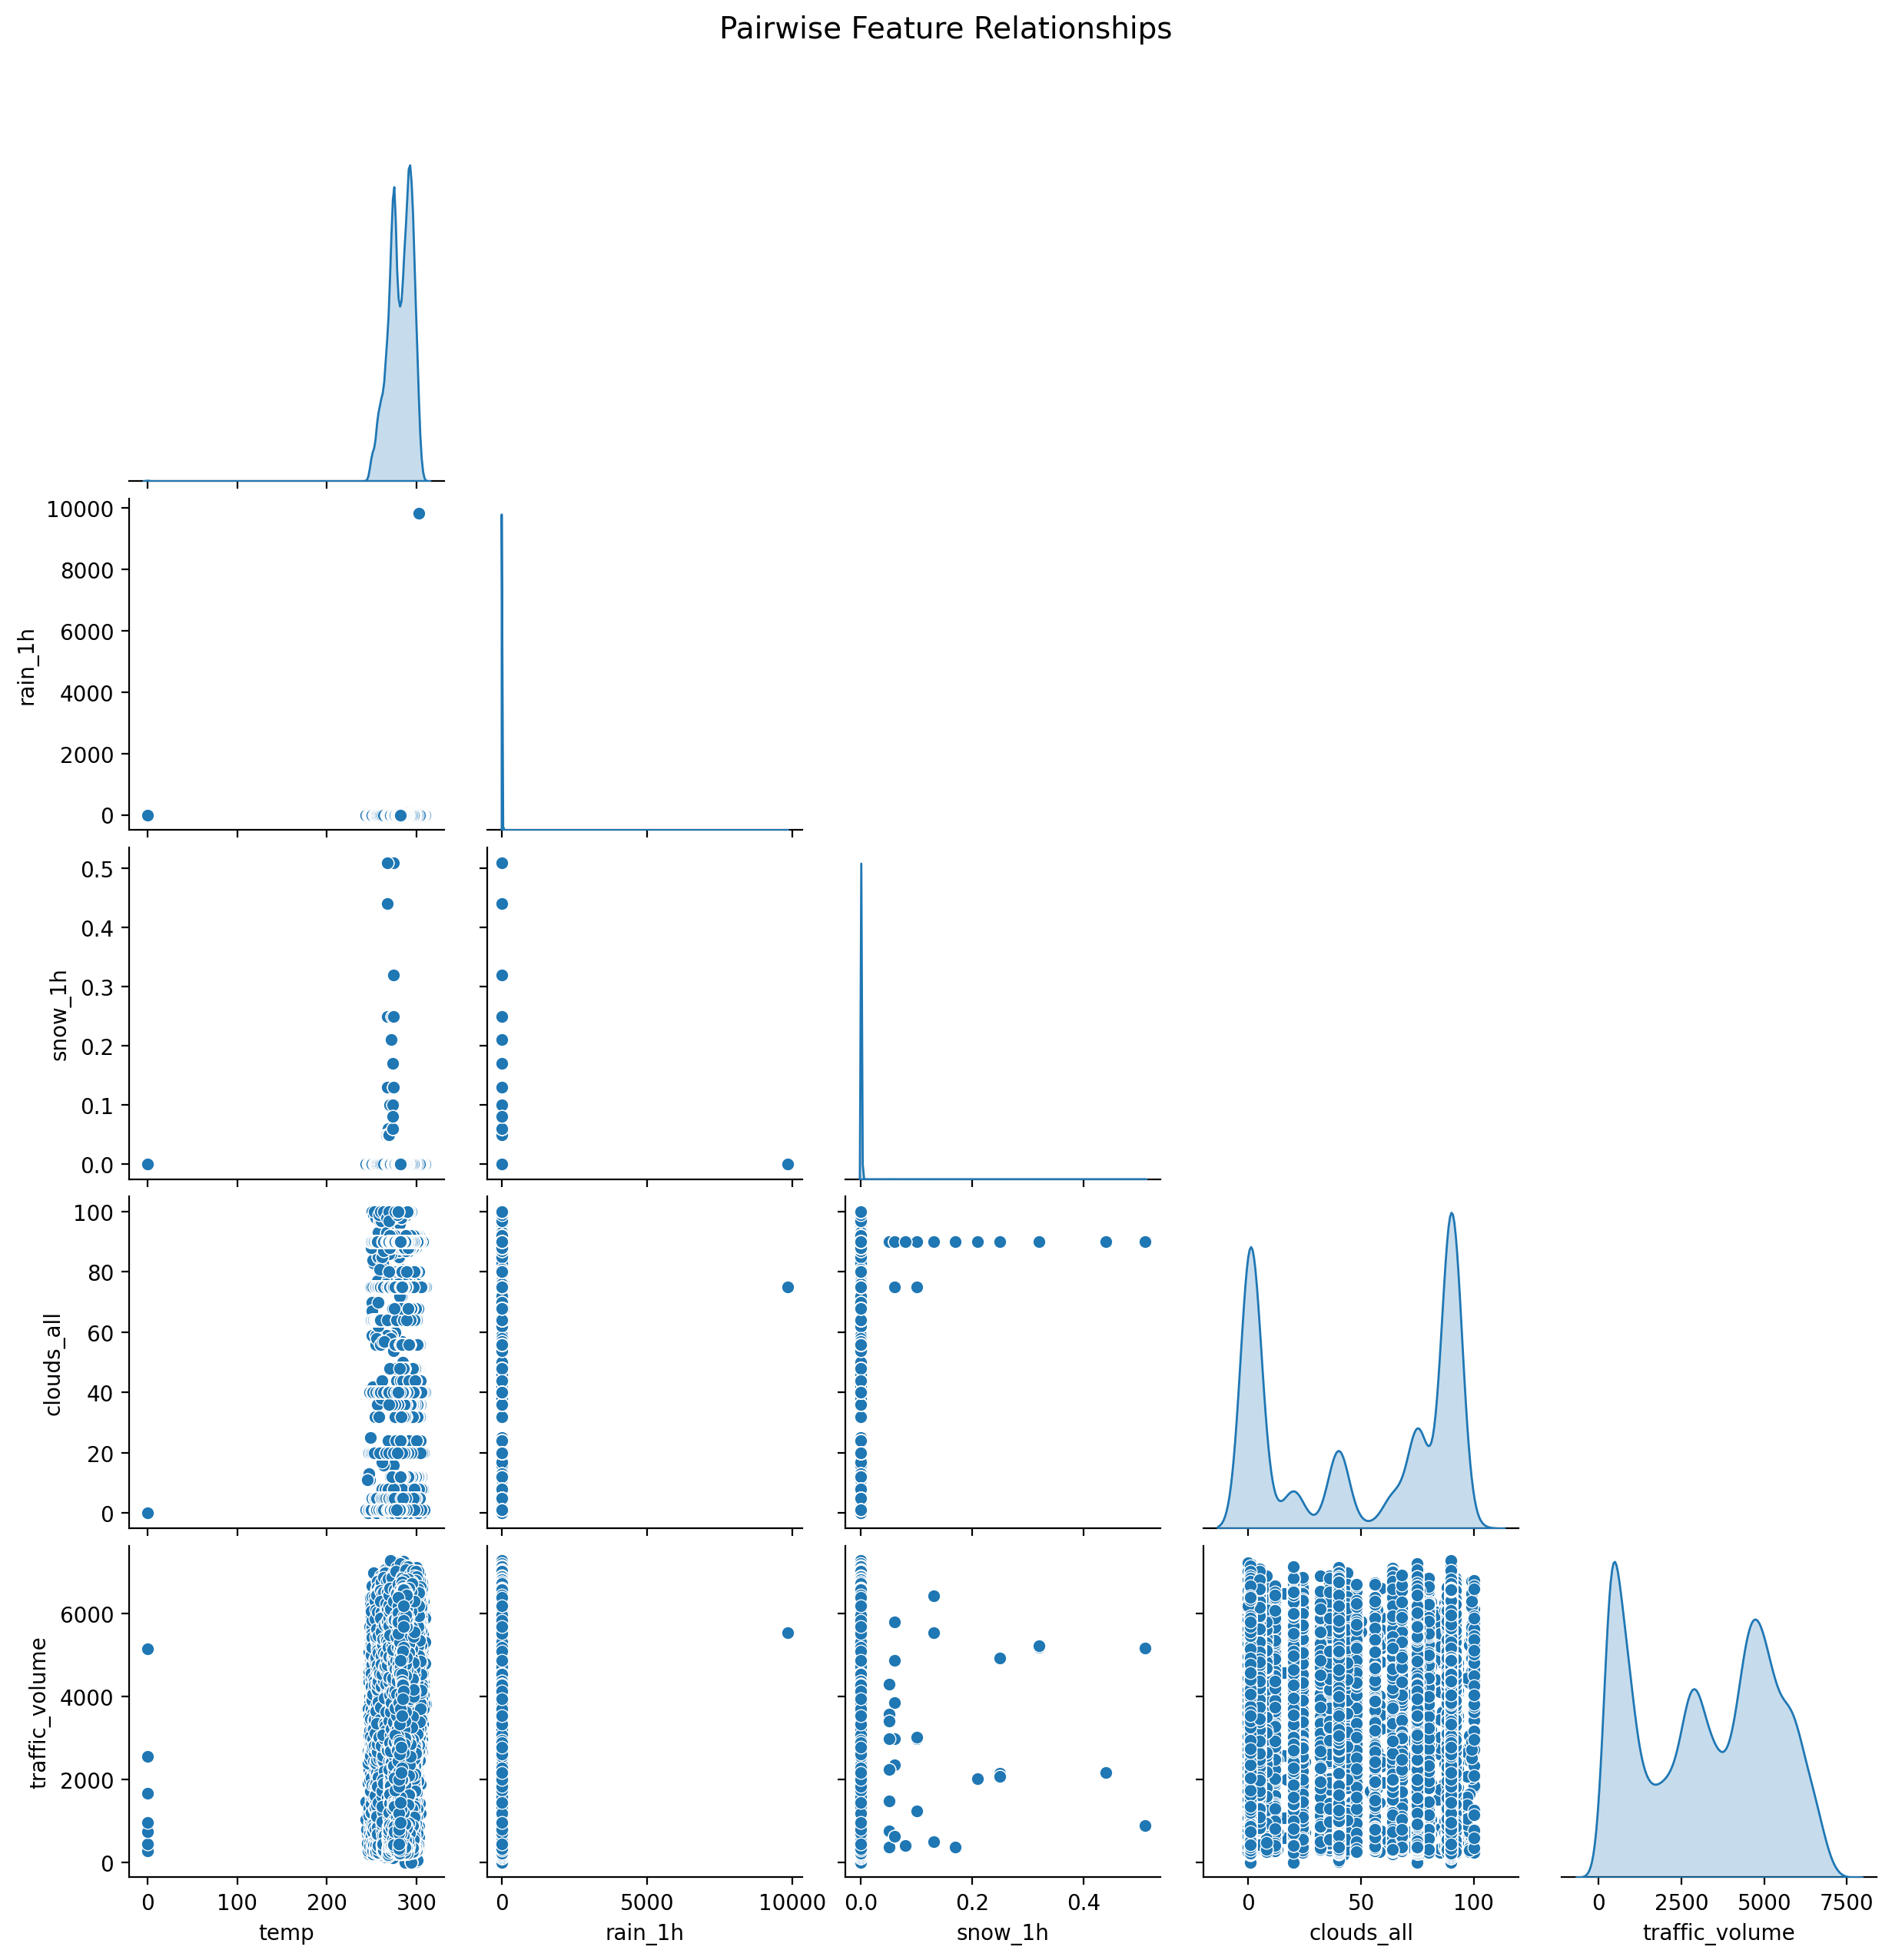

In [6]:
# Specify columns to visualize relationships between features
features_to_compare = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']

# Import necessary libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pairwise plot to observe relationships between selected features
sns.pairplot(df_raw[features_to_compare], diag_kind='kde', corner=True)
plt.suptitle("Pairwise Feature Relationships", y=1.02, fontsize=14)
plt.subplots_adjust(top=0.95)  # Adjust layout to accommodate the title
plt.show()


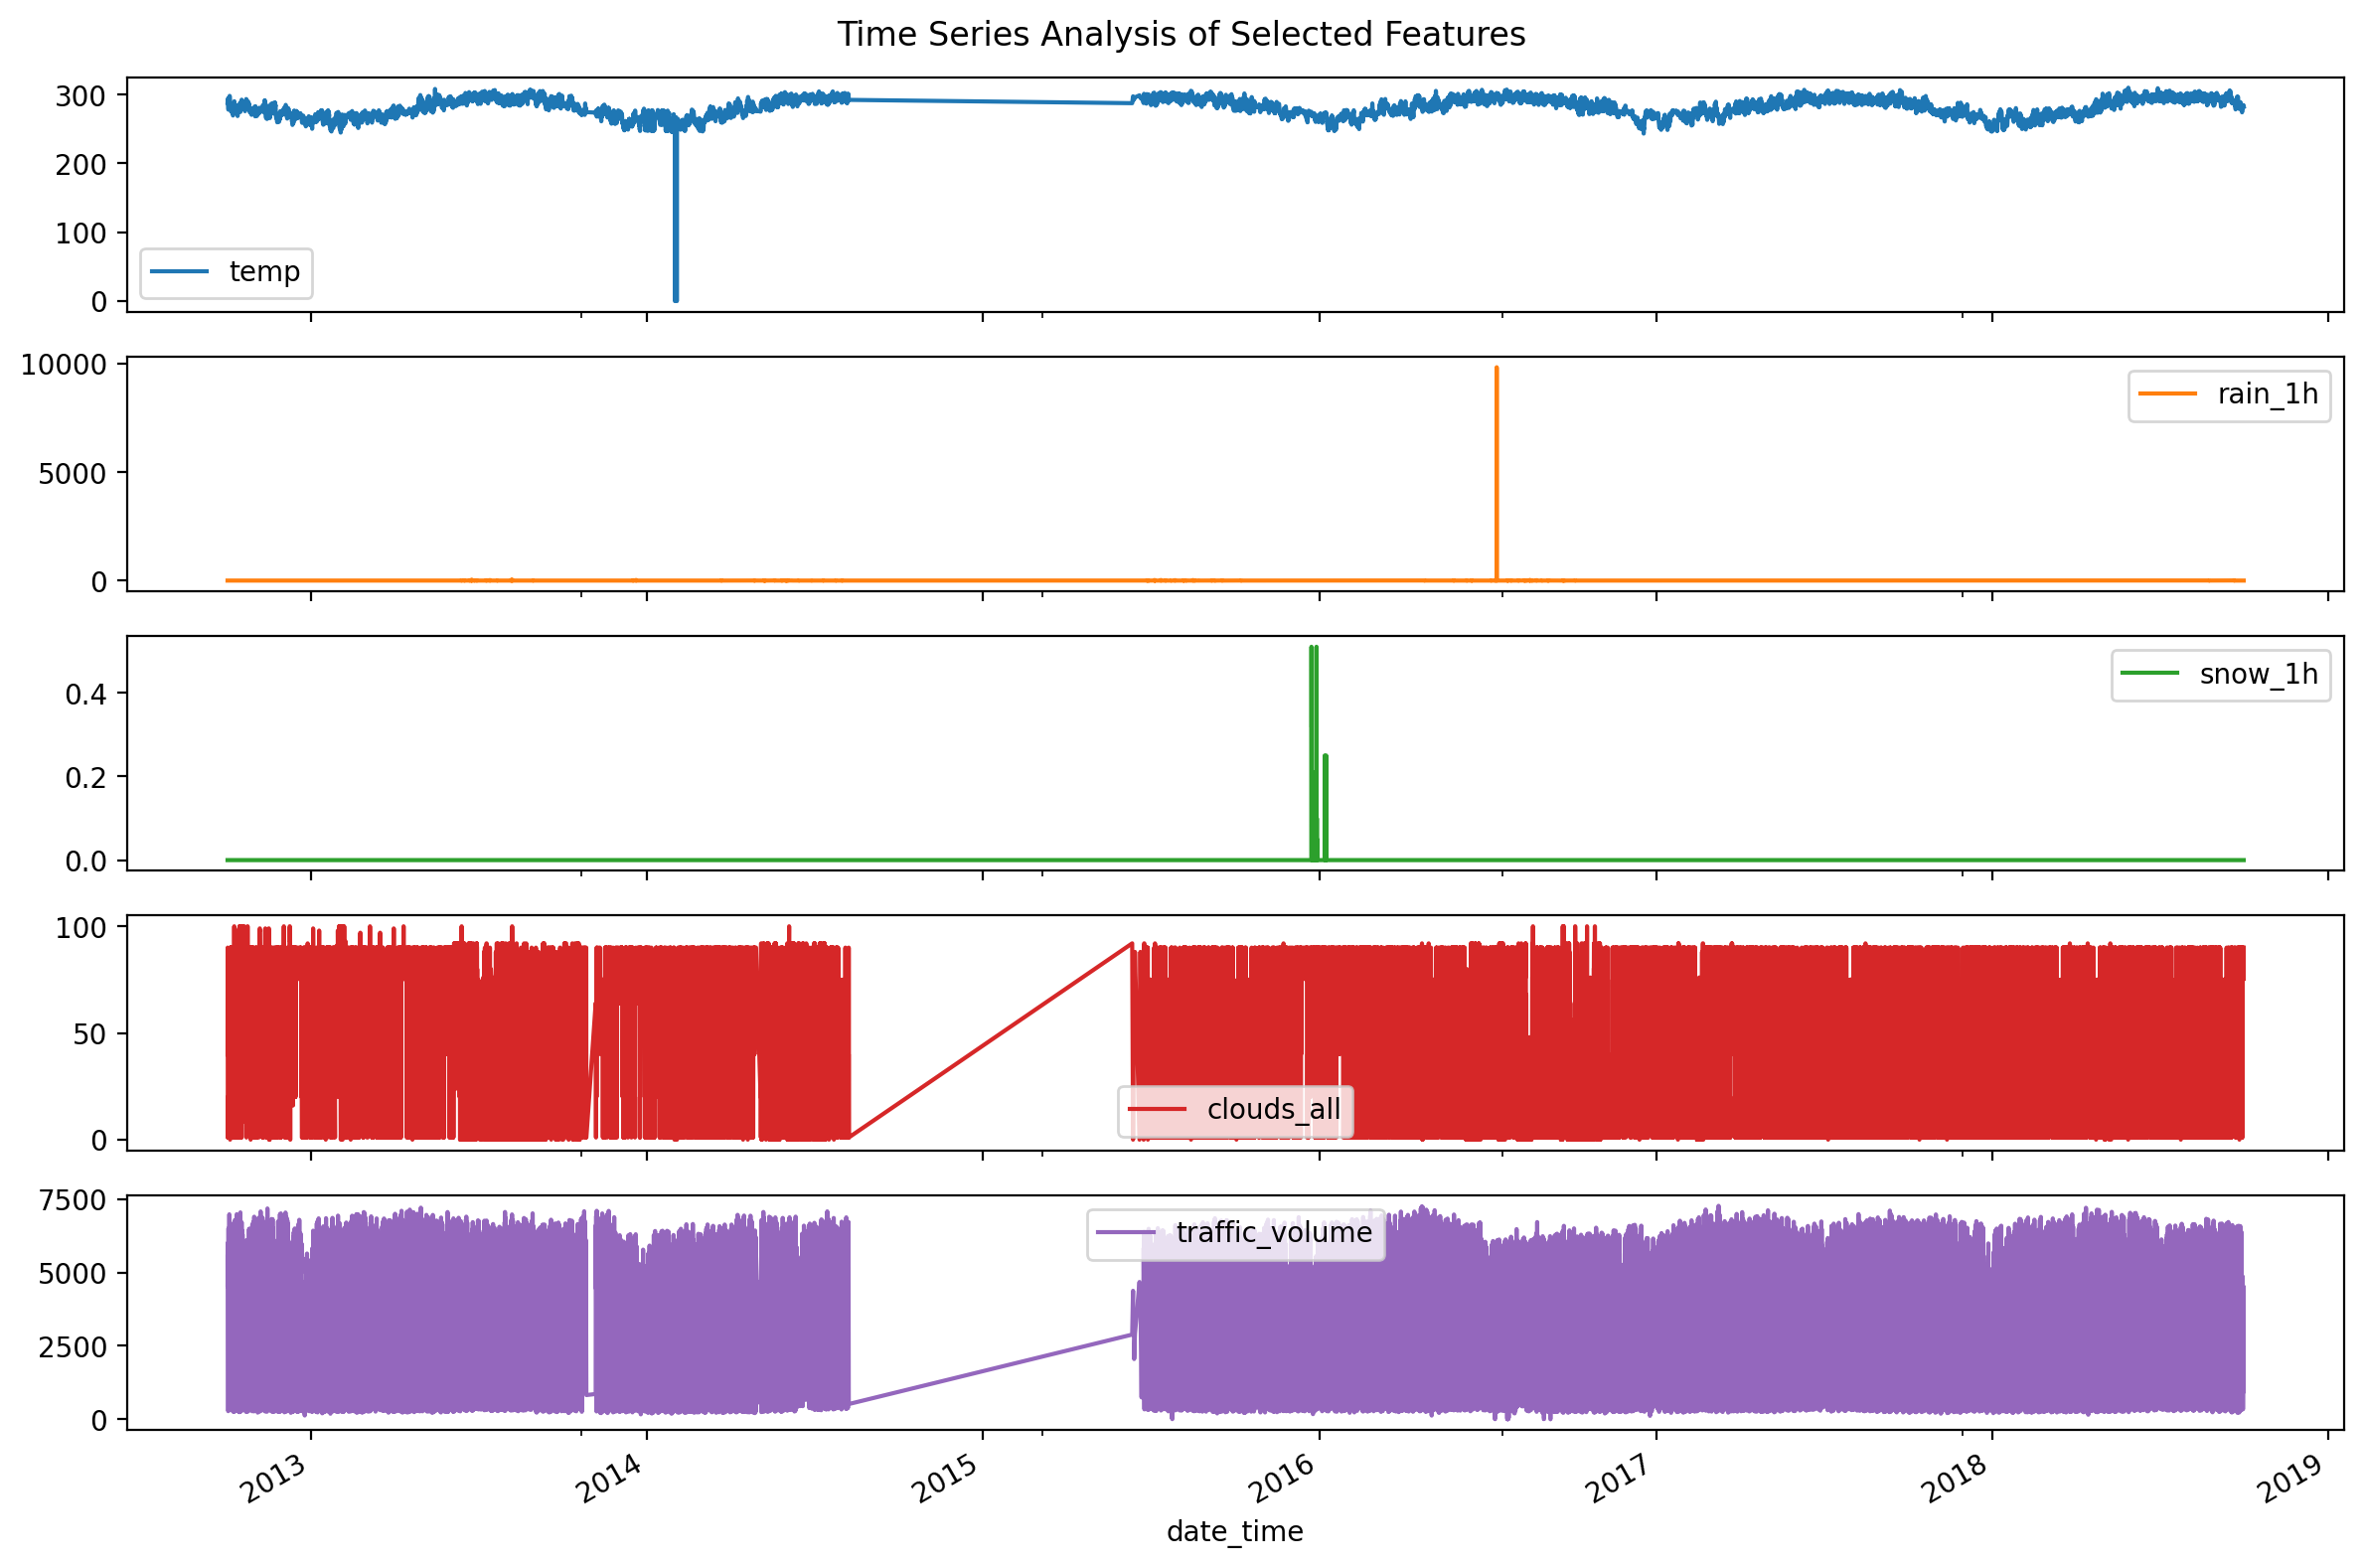

In [7]:
# Specify columns to include in visual analysis
features_to_plot = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']
selected_data = df_raw[features_to_plot]

# Generate separate plots for each feature to analyze trends over time
selected_data.plot(
    subplots=True, 
    figsize=(12, 8), 
    layout=(len(features_to_plot), 1), 
    sharex=True, 
    title="Time Series Analysis of Selected Features"
)

# Adjust layout to avoid overlap and enhance readability
plt.tight_layout()
plt.show()


temp  rain_1h  snow_1h  clouds_all  traffic_volume
date_time                                                               
2013-05-01 00:00:00 290.62     0.00     0.00           1             529
2013-05-01 02:00:00 290.32     0.00     0.00           1             283
2013-05-01 03:00:00 290.18     0.00     0.00           1             341
2013-05-01 04:00:00 290.18     0.00     0.00           1             746
2013-05-01 05:00:00 290.12     0.00     0.00          40            2561

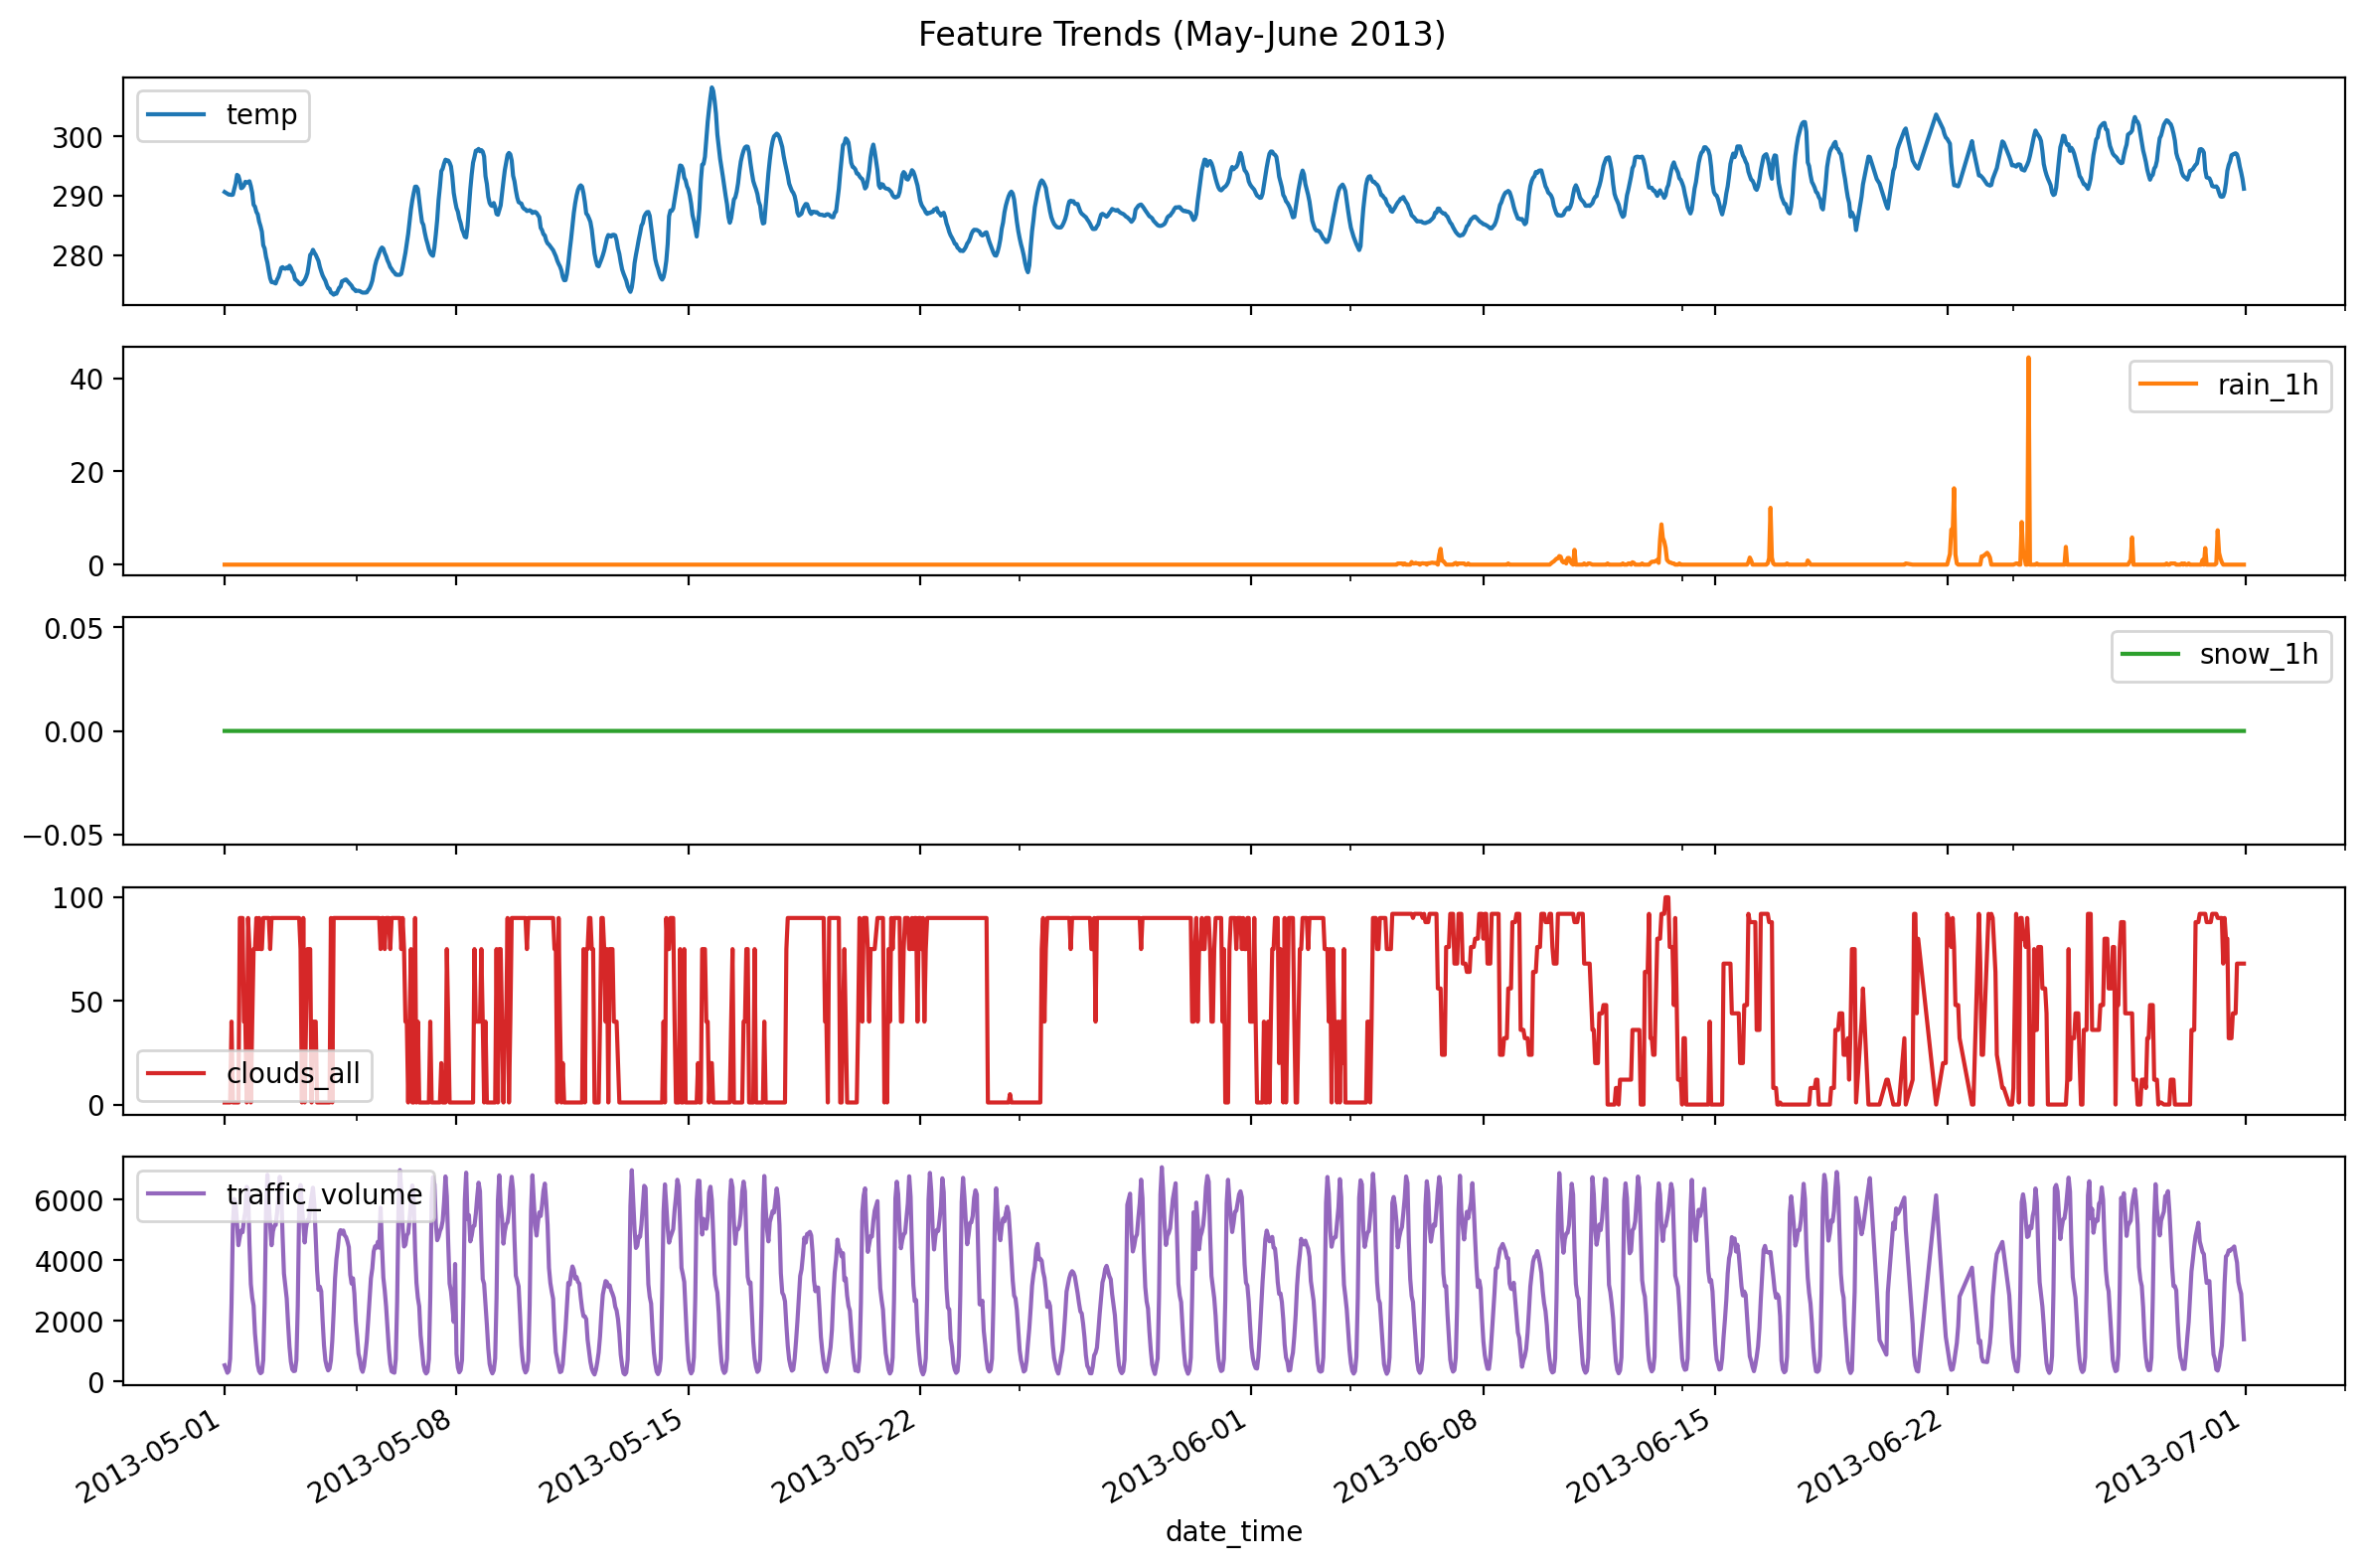

In [8]:
# Define the features to be visualized
analysis_columns = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']

# Load and filter data to show only records from May to June 2013
filtered_traffic_data = df_raw.loc['2013-05':'2013-06', analysis_columns]

# Display the initial rows of the filtered data for confirmation
display(filtered_traffic_data.head())

# Plot each feature in a separate subplot to observe trends
axes = filtered_traffic_data.plot(
    subplots=True, figsize=(12, 8), title="Feature Trends (May-June 2013)", legend=True
)

# Set layout adjustments for better display
plt.tight_layout()
plt.show()



Data is missing records between 2013-05 and 2013-07 for snow variable




holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2014-08-08 00:00:00    None 293.45     0.00     0.00          40       Clouds   
2014-08-08 01:00:00    None 292.38     0.00     0.00           1        Clear   
2015-06-11 20:00:00    None 287.59     0.00     0.00          92         Rain   

                    weather_description  traffic_volume  
date_time                                                
2014-08-08 00:00:00    scattered clouds             848  
2014-08-08 01:00:00        sky is clear             516  
2015-06-11 20:00:00          light rain            2886

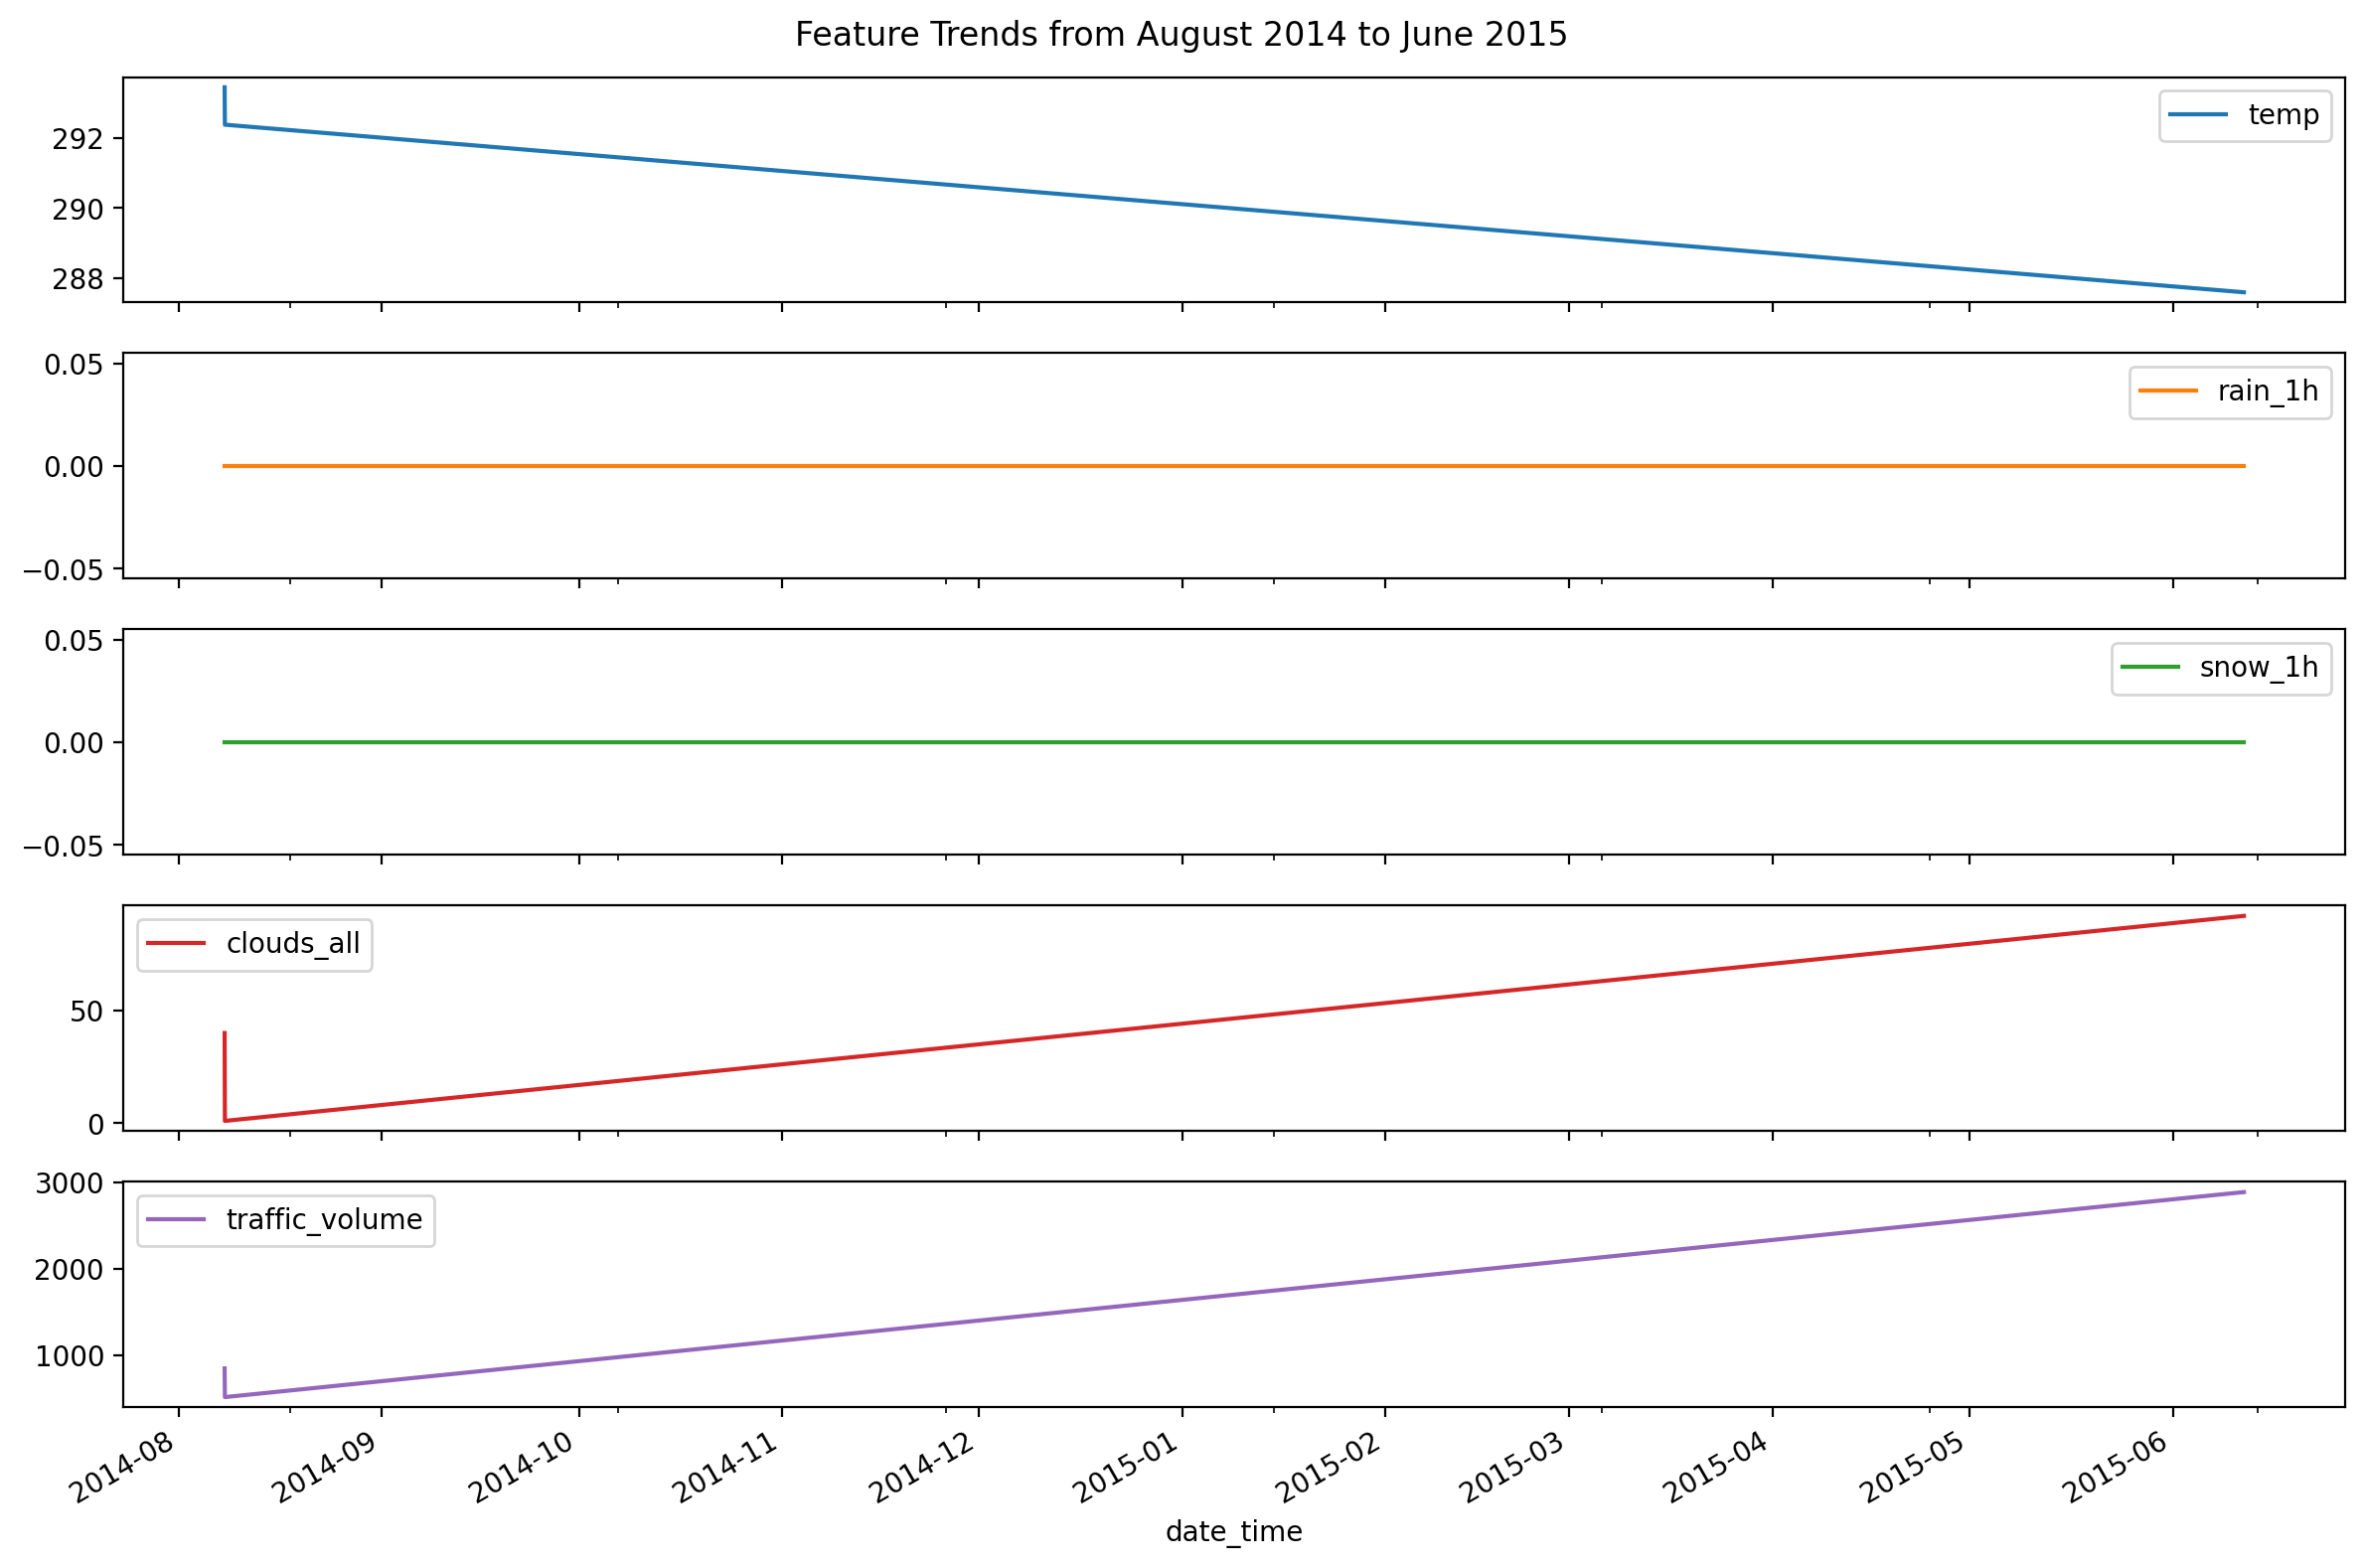

In [9]:
# Select the date range for analysis
date_filtered_data = df_raw.loc['2014-08-08':'2015-06-11']

# Display the first few rows to confirm the date range and data selection
display(date_filtered_data.head())

# Plot each column within the specified date range as individual subplots
date_filtered_data.plot(
    subplots=True, 
    figsize=(12, 8), 
    title="Feature Trends from August 2014 to June 2015",
    legend=True
)

# Optimize the layout for readability
plt.tight_layout()
plt.show()


### Statistics Of The Data

In [10]:
# Generate a summary of the dataset, treating datetime columns as numeric for temporal analysis
summary_stats = df_raw.describe(datetime_is_numeric=True).T

# Display the transposed summary for better readability
display(summary_stats)


count    mean     std  min     25%     50%     75%     max
temp           48204.00  281.21   13.34 0.00  272.16  282.45  291.81  310.07
rain_1h        48204.00    0.33   44.79 0.00    0.00    0.00    0.00 9831.30
snow_1h        48204.00    0.00    0.01 0.00    0.00    0.00    0.00    0.51
clouds_all     48204.00   49.36   39.02 0.00    1.00   64.00   90.00  100.00
traffic_volume 48204.00 3259.82 1986.86 0.00 1193.00 3380.00 4933.00 7280.00

In [11]:
# Generate descriptive statistics for categorical/object data types
object_summary = df_raw.describe(include='object').T

# Display the transposed summary for a clearer view of categorical data stats
display(object_summary)


count unique           top   freq
holiday              48204     12          None  48143
weather_main         48204     11        Clouds  15164
weather_description  48204     38  sky is clear  11665

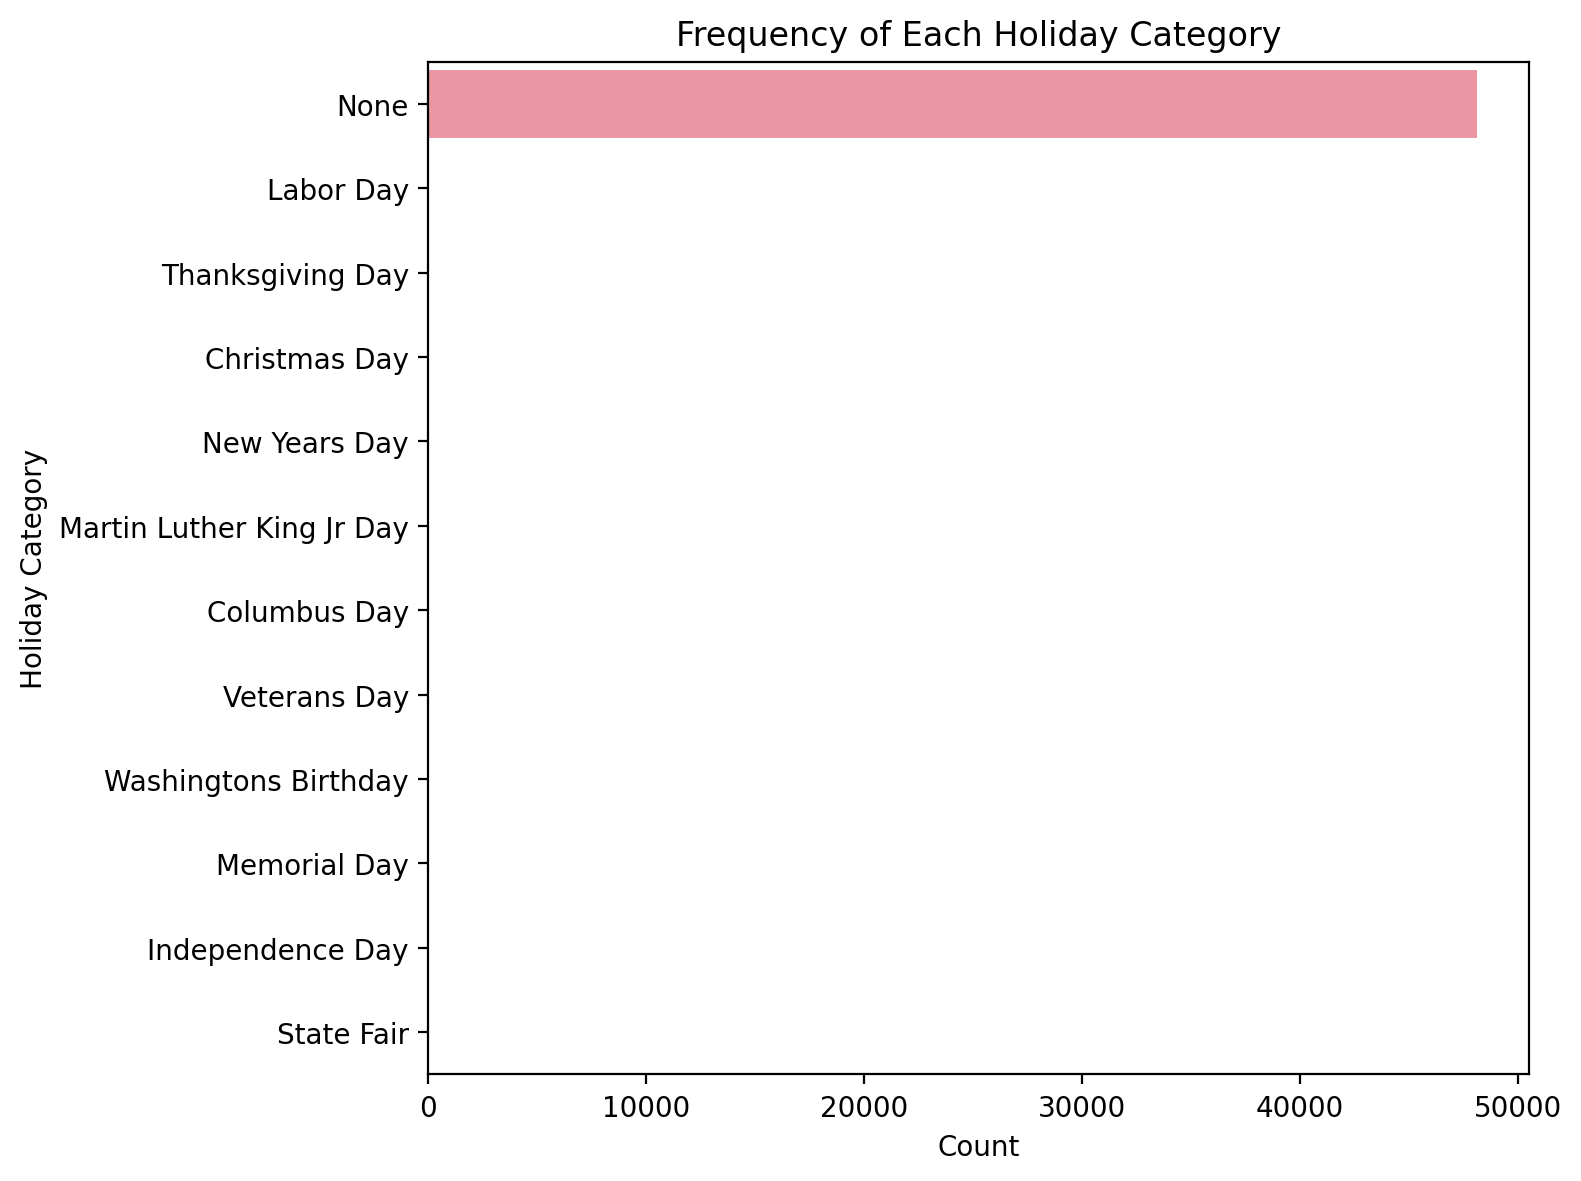

In [12]:
# Visualizing the frequency of each category in the 'holiday' column
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(data=df_raw, y='holiday', order=df_raw['holiday'].value_counts().index)
plt.title("Frequency of Each Holiday Category")
plt.xlabel("Count")
plt.ylabel("Holiday Category")
plt.tight_layout()
plt.show()


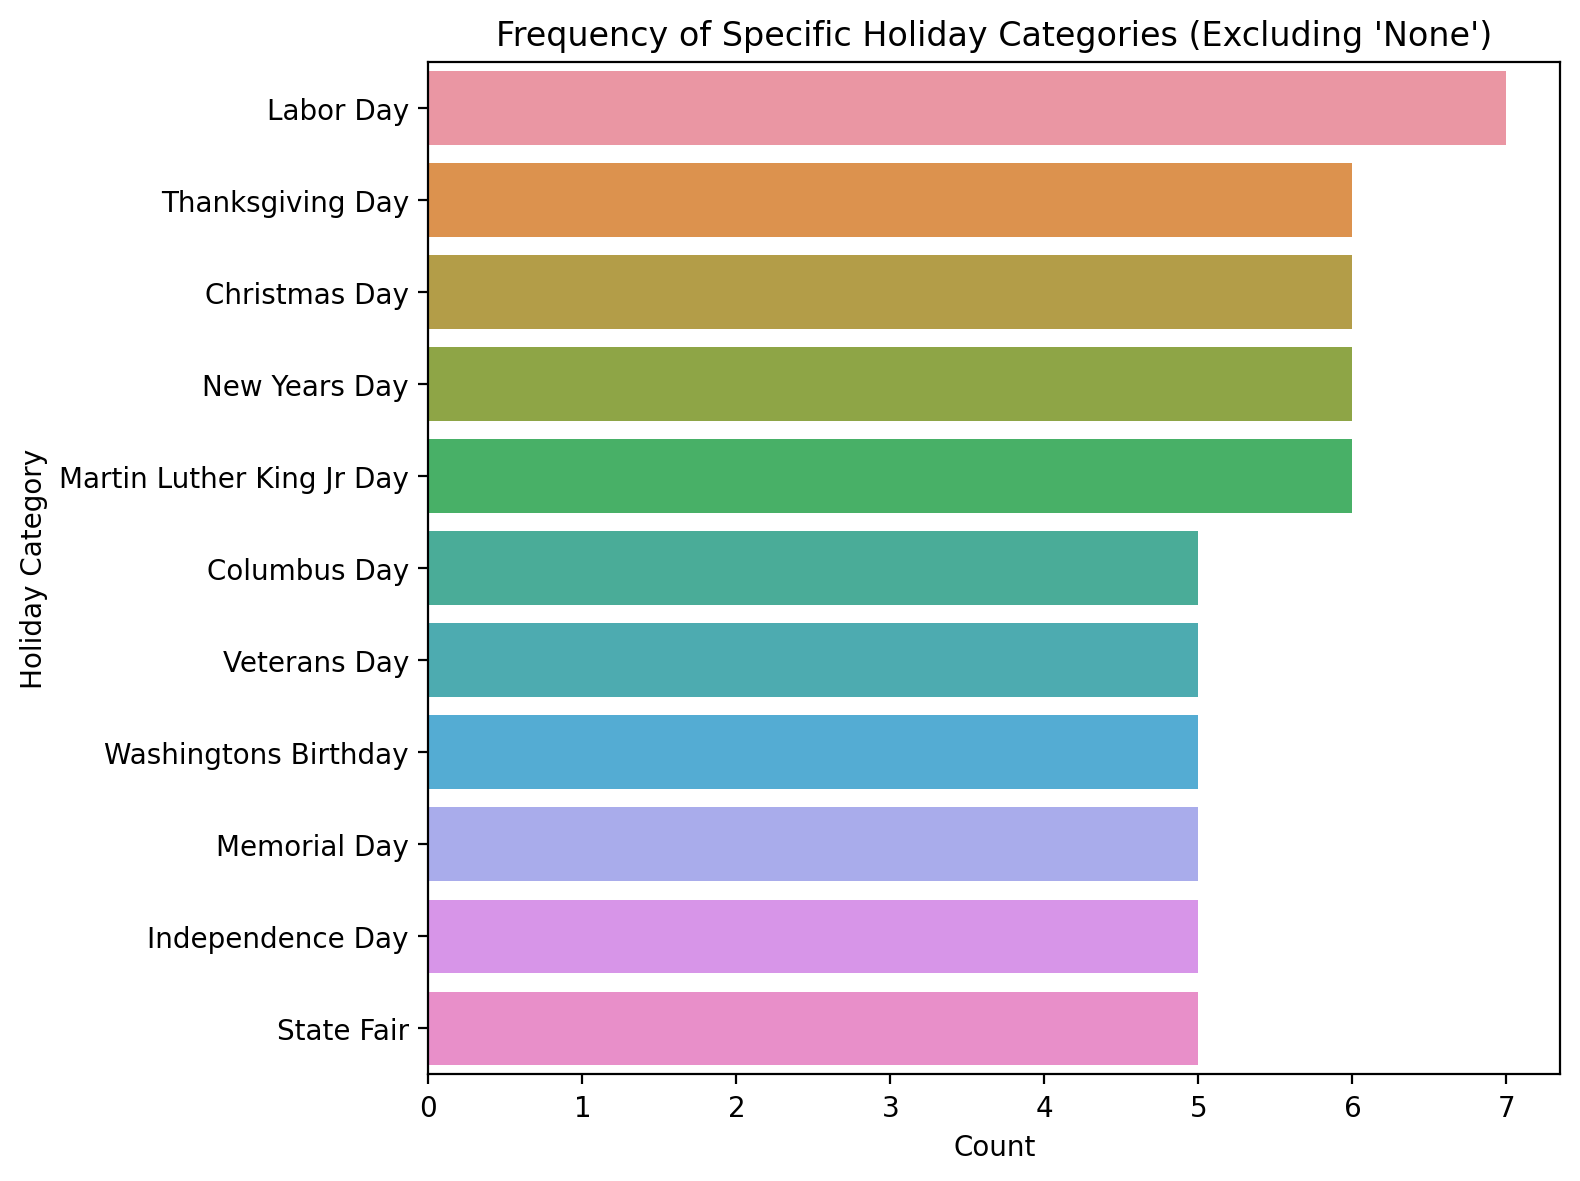

In [13]:
# Filter out rows where holiday is 'None' to focus on specific holidays
holiday_data = df_raw[df_raw['holiday'] != 'None']

# Set up the plot area
plt.figure(figsize=(8, 6))
sns.countplot(data=holiday_data, y='holiday', order=holiday_data['holiday'].value_counts().index)
plt.title("Frequency of Specific Holiday Categories (Excluding 'None')")
plt.xlabel("Count")
plt.ylabel("Holiday Category")
plt.tight_layout()
plt.show()


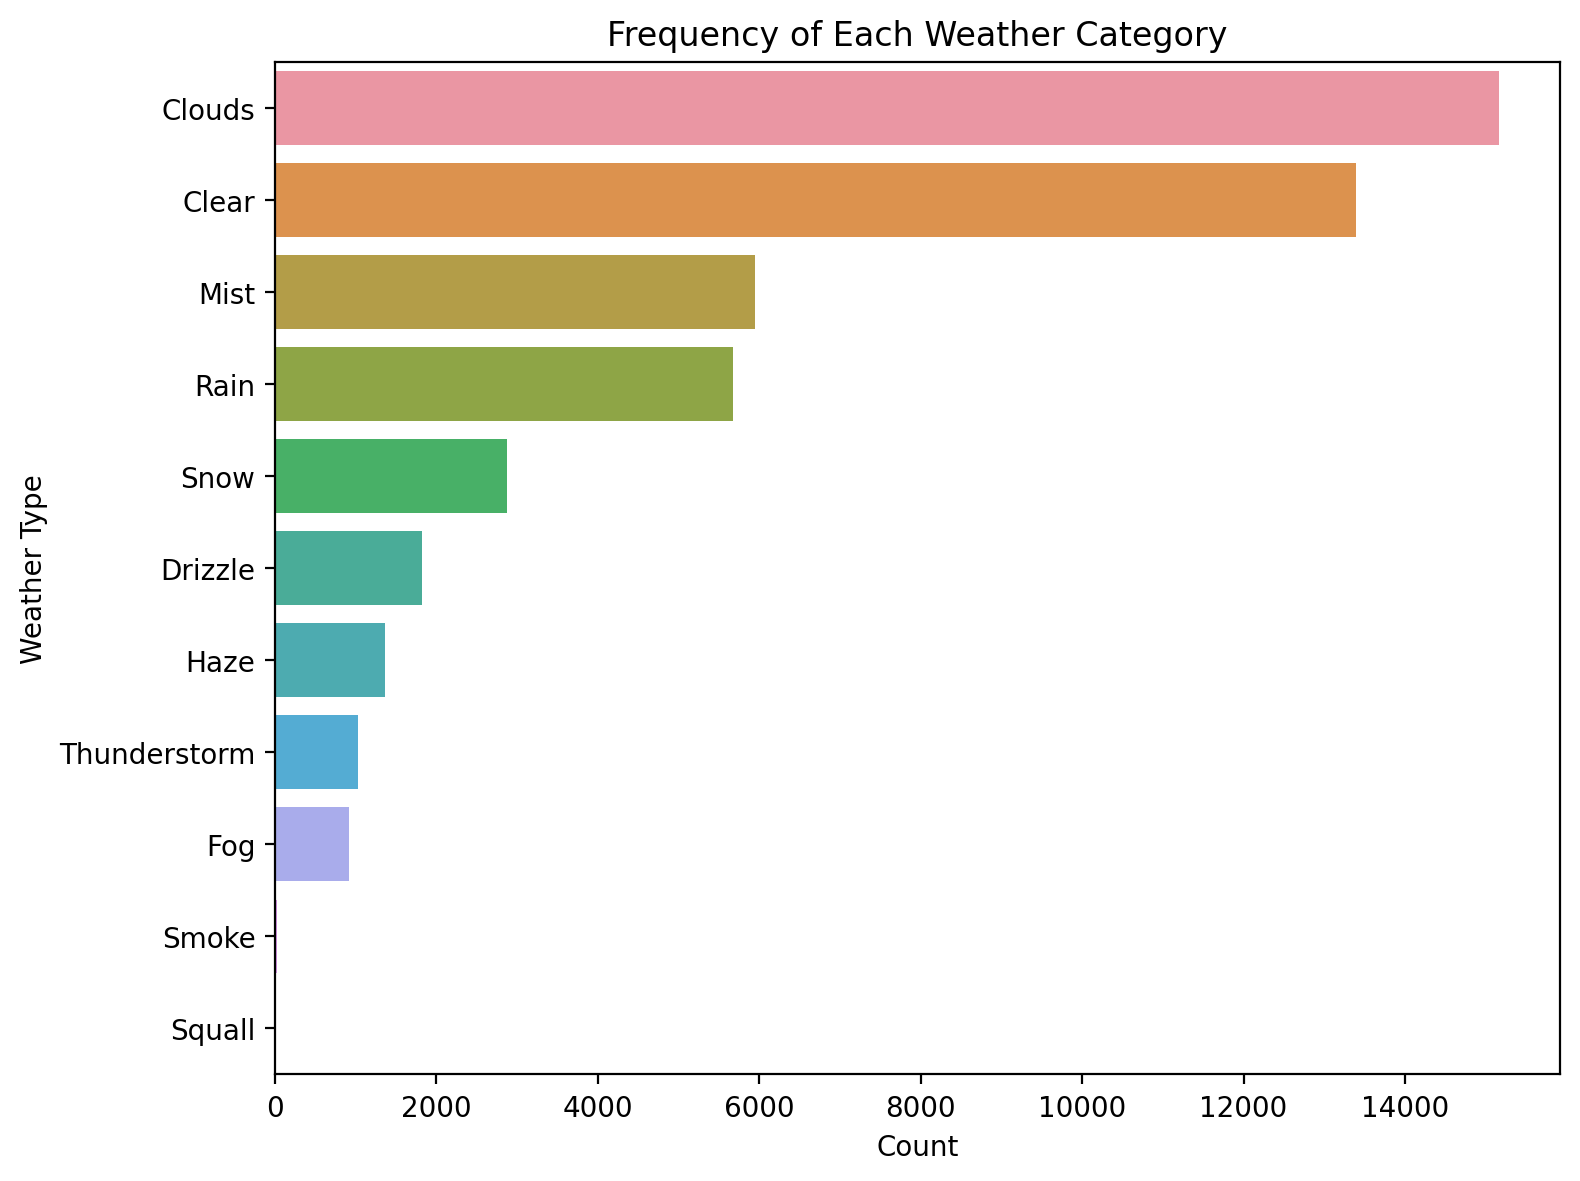

In [14]:
# Plot the frequency of each weather category in the 'weather_main' column
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(data=df_raw, y='weather_main', order=df_raw['weather_main'].value_counts().index)
plt.title("Frequency of Each Weather Category")
plt.xlabel("Count")
plt.ylabel("Weather Type")
plt.tight_layout()
plt.show()


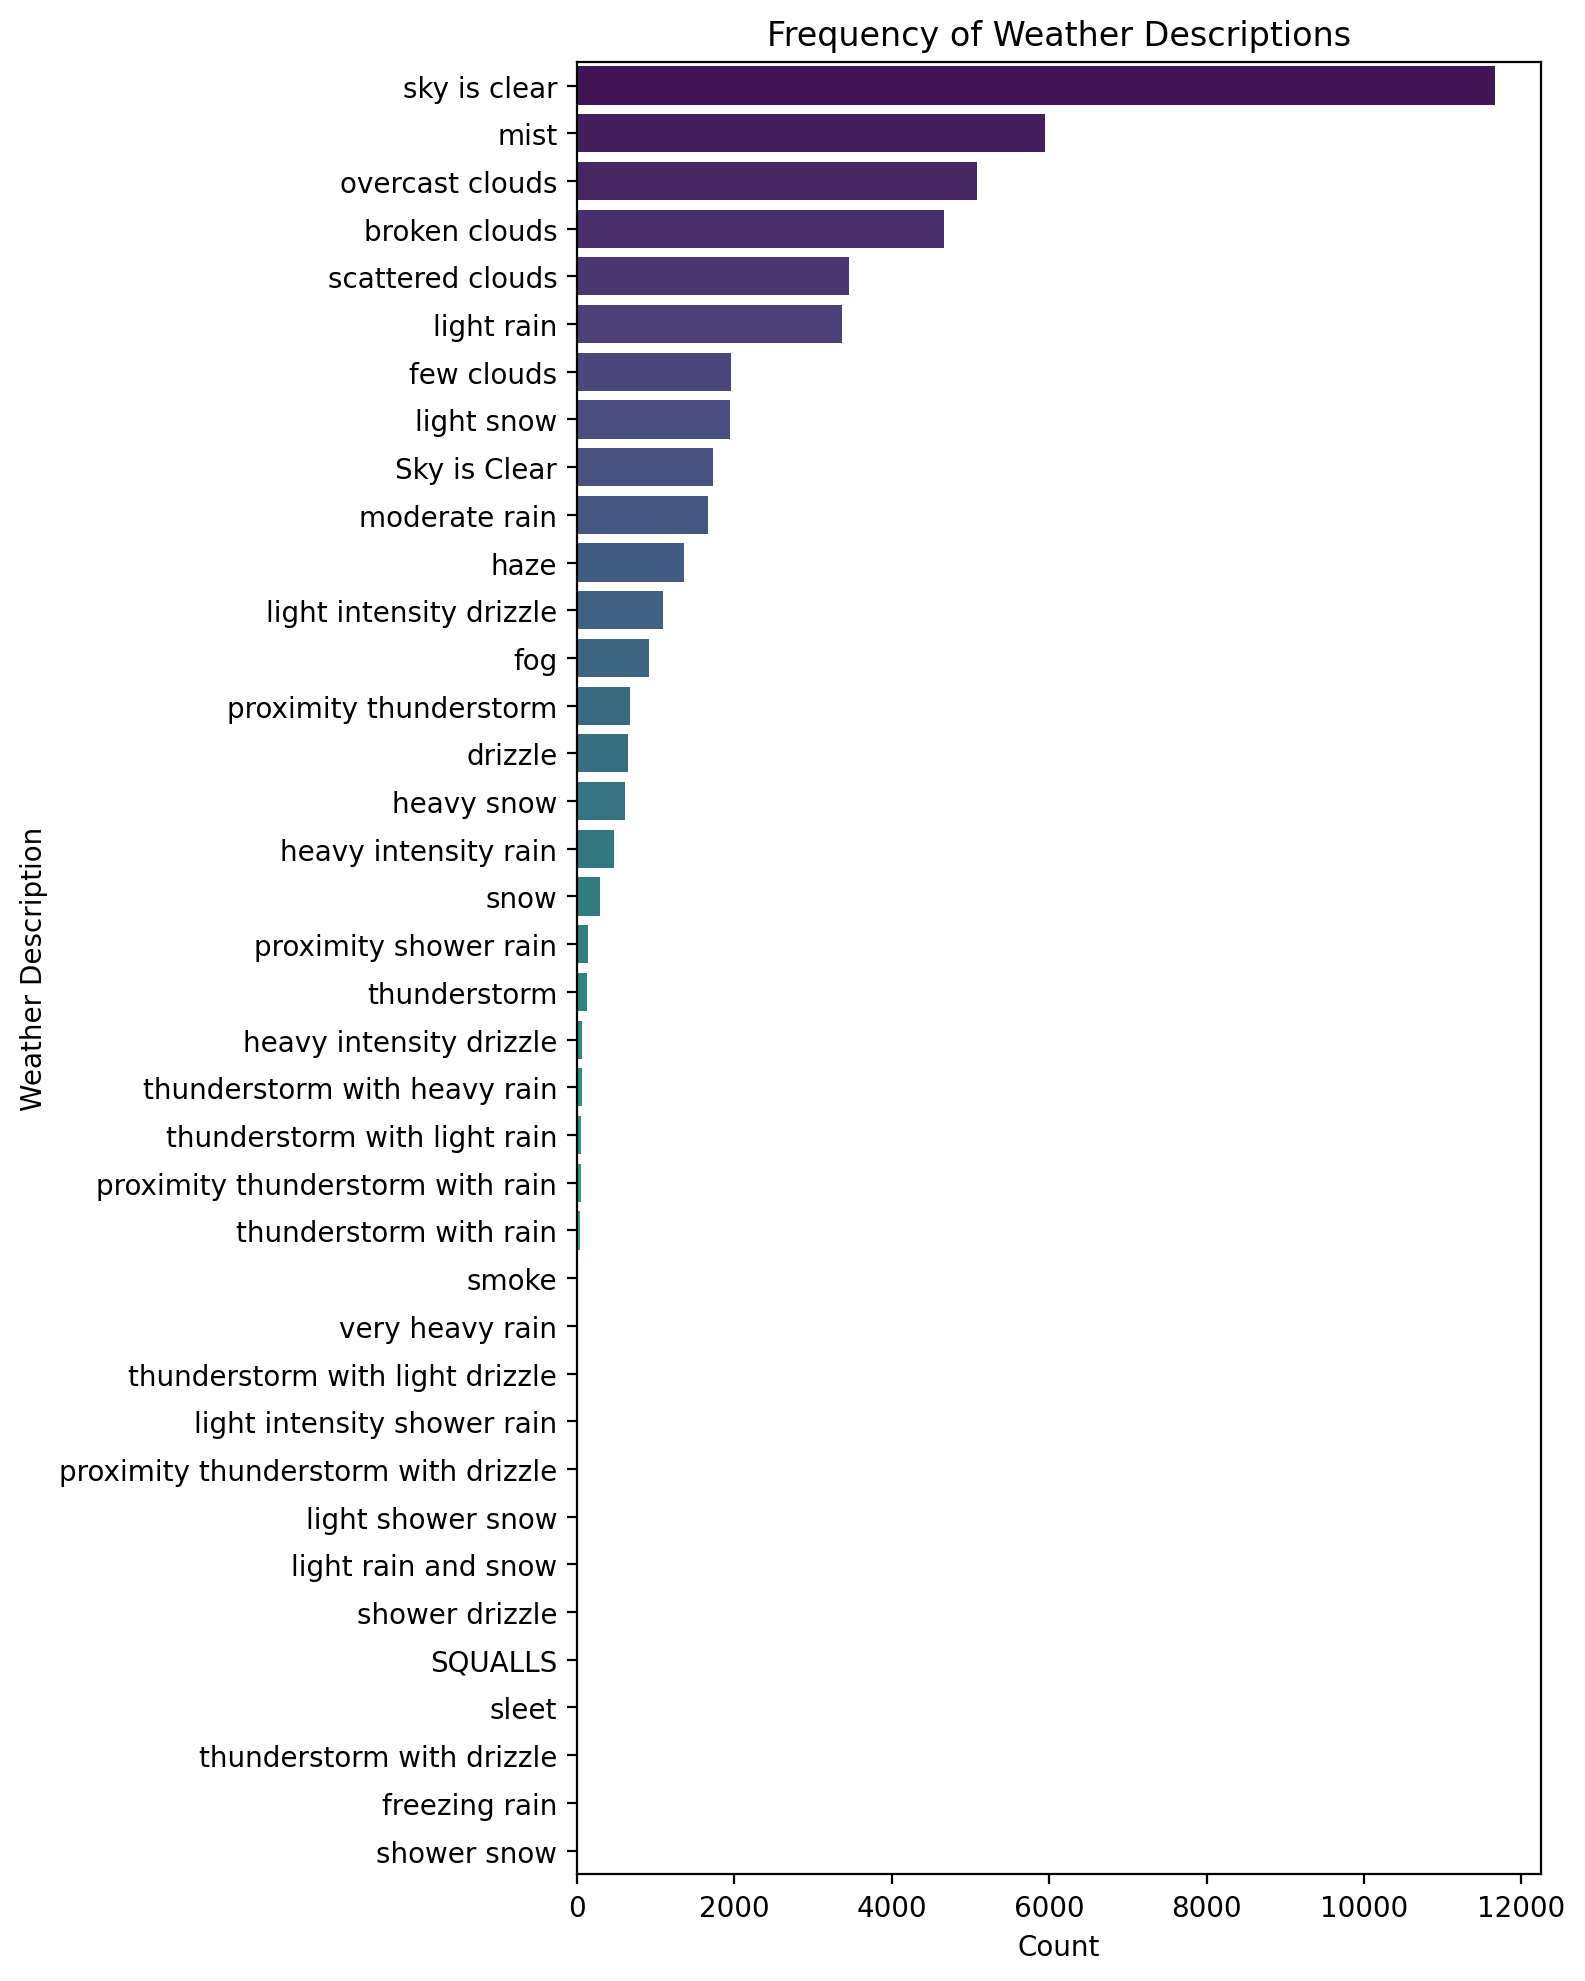

In [15]:
# Plotting the frequency of each weather description category for better understanding
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 10))  # Increased height for better display of categories
sns.countplot(
    data=df_raw, 
    y='weather_description', 
    order=df_raw['weather_description'].value_counts().index,
    palette="viridis"  # Added a color palette for visual appeal
)
plt.title("Frequency of Weather Descriptions")
plt.xlabel("Count")
plt.ylabel("Weather Description")
plt.tight_layout()
plt.show()


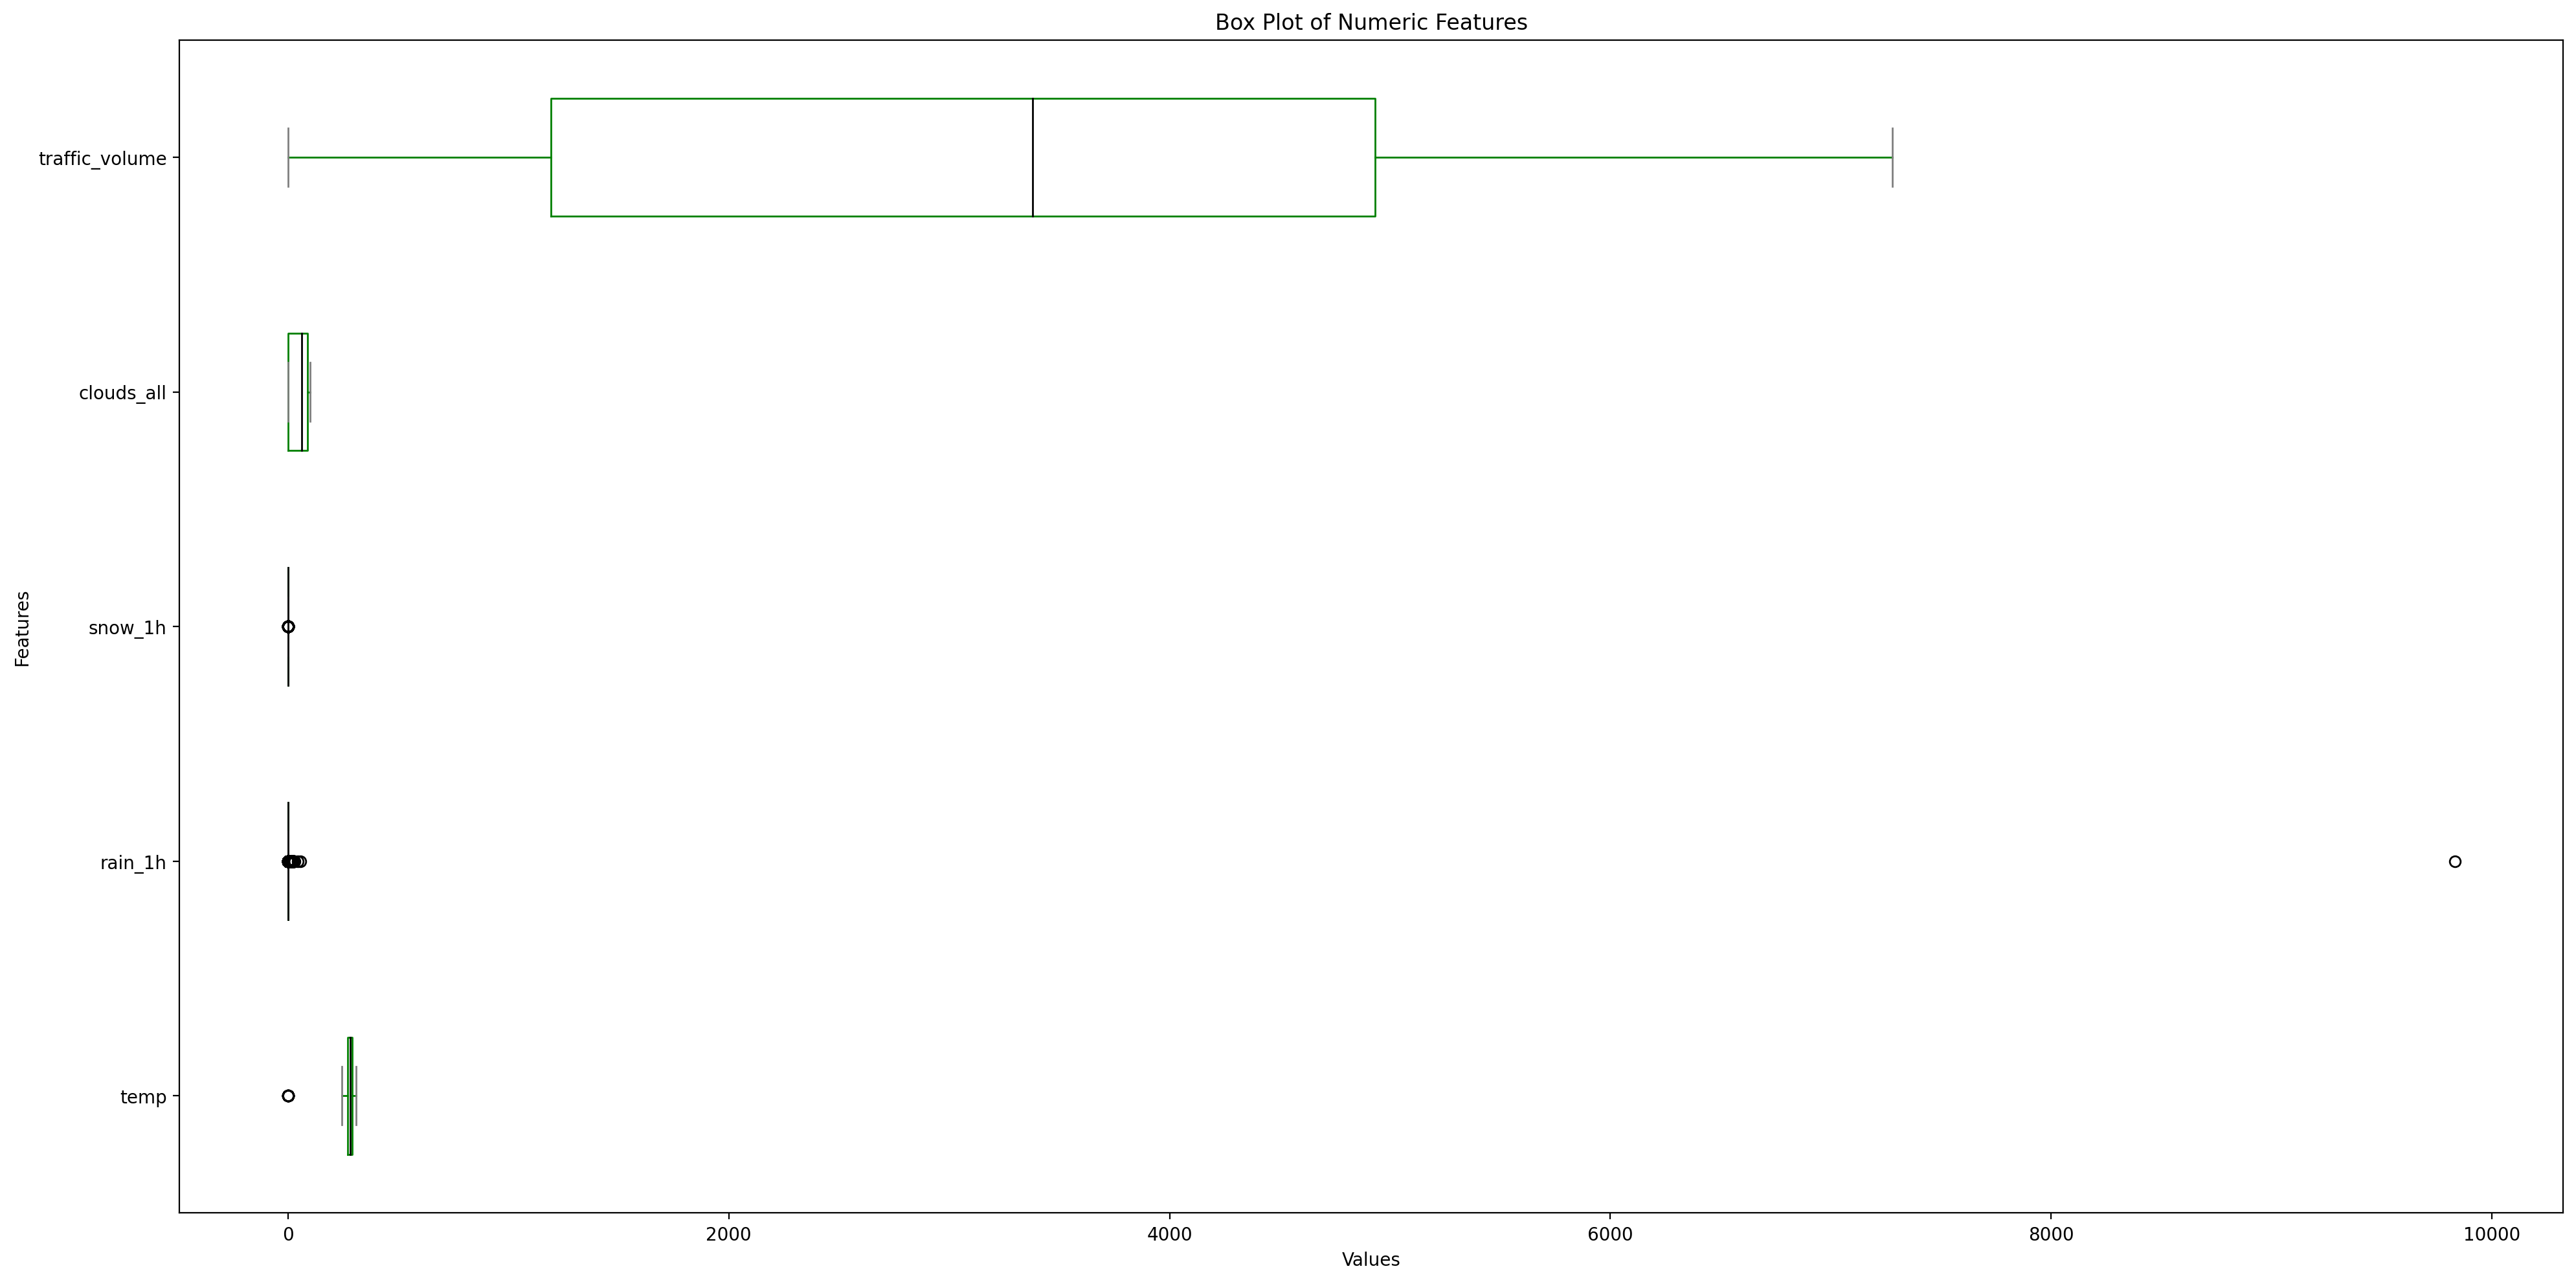

In [16]:
# Box plot to visualize the distribution and outliers of numeric columns
import matplotlib.pyplot as plt

df_raw.plot(
    kind='box',
    figsize=(20, 10),
    color=dict(boxes='Green', whiskers='Green', medians='Black', caps='Gray'),  # Custom colors for box plot elements
    vert=False
)
plt.title("Box Plot of Numeric Features")
plt.xlabel("Values")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


#### Temperature

In [17]:
# Filter rows where the temperature is exactly zero
zero_temp_records = df_raw[df_raw['temp'] == 0]

# Display the records with zero temperature
display(zero_temp_records)


holiday  temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                      
2014-01-31 03:00:00    None  0.00     0.00     0.00           0        Clear   
2014-01-31 04:00:00    None  0.00     0.00     0.00           0        Clear   
2014-01-31 05:00:00    None  0.00     0.00     0.00           0        Clear   
2014-01-31 06:00:00    None  0.00     0.00     0.00           0        Clear   
2014-02-02 03:00:00    None  0.00     0.00     0.00           0        Clear   
2014-02-02 04:00:00    None  0.00     0.00     0.00           0        Clear   
2014-02-02 05:00:00    None  0.00     0.00     0.00           0        Clear   
2014-02-02 06:00:00    None  0.00     0.00     0.00           0        Clear   
2014-02-02 07:00:00    None  0.00     0.00     0.00           0        Clear   
2014-02-02 08:00:00    None  0.00     0.00     0.00           0        Clear   

                    weather_description  traffic_volume  
date_time                                                
2014-01-31 03:00:00        sky is clear             361  
2014-01-31 04:00:00        sky is clear             734  
2014-01-31 05:00:00        sky is clear            2557  
2014-01-31 06:00:00        sky is clear            5150  
2014-02-02 03:00:00        sky is clear             291  
2014-02-02 04:00:00        sky is clear             284  
2014-02-02 05:00:00        sky is clear             434  
2014-02-02 06:00:00        sky is clear             739  
2014-02-02 07:00:00        sky is clear             962  
2014-02-02 08:00:00        sky is clear            1670

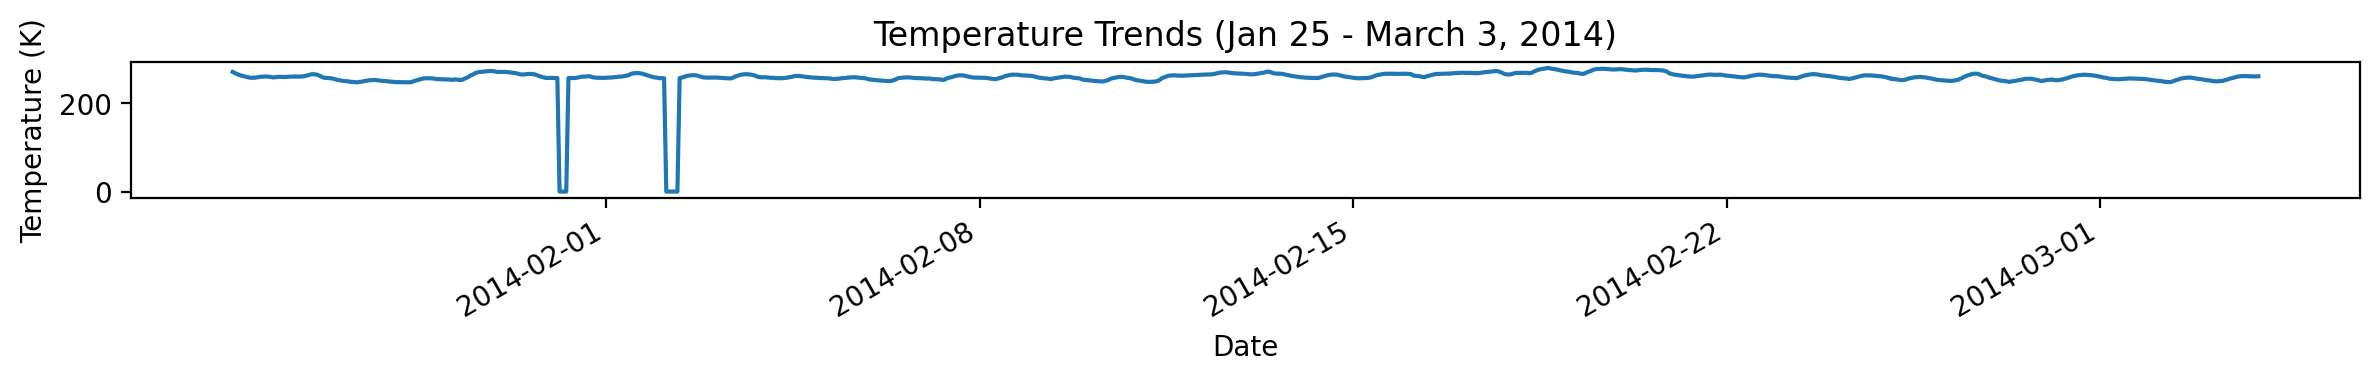

In [18]:
# Select a specific date range for the 'temp' column
temp_range_data = df_raw.loc['2014-01-25':'2014-03-03', 'temp']

# Plot the selected temperature data over the specified date range
temp_range_data.plot(figsize=(12, 2), title="Temperature Trends (Jan 25 - March 3, 2014)")
plt.xlabel("Date")
plt.ylabel("Temperature (K)")  # Assuming the temperature is in Kelvin
plt.tight_layout()
plt.show()


In [19]:
# Extract data for a specific date (January 31, 2014)
single_day_data = df_raw.loc['2014-01-31']

# Display the data for the selected date
display(single_day_data)


holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2014-01-31 00:00:00    None 255.93     0.00     0.00           0        Clear   
2014-01-31 01:00:00    None 255.93     0.00     0.00           0        Clear   
2014-01-31 02:00:00    None 255.93     0.00     0.00           0        Clear   
2014-01-31 03:00:00    None   0.00     0.00     0.00           0        Clear   
2014-01-31 04:00:00    None   0.00     0.00     0.00           0        Clear   
2014-01-31 05:00:00    None   0.00     0.00     0.00           0        Clear   
2014-01-31 06:00:00    None   0.00     0.00     0.00           0        Clear   
2014-01-31 07:00:00    None 255.93     0.00     0.00           0        Clear   
2014-01-31 08:00:00    None 255.93     0.00     0.00           0        Clear   
2014-01-31 09:00:00    None 255.93     0.00     0.00           0        Clear   
2014-01-31 10:00:00    None 255.84     0.00     0.00           0        Clear   
2014-01-31 11:00:00    None 256.88     0.00     0.00           0        Clear   
2014-01-31 12:00:00    None 258.10     0.00     0.00           0        Clear   
2014-01-31 13:00:00    None 258.80     0.25     0.00           0         Rain   
2014-01-31 14:00:00    None 259.22     0.25     0.00           0         Rain   
2014-01-31 15:00:00    None 259.80     0.00     0.00           0        Clear   
2014-01-31 16:00:00    None 259.86     0.00     0.00           0        Clear   
2014-01-31 17:00:00    None 259.24     0.00     0.00           0        Clear   
2014-01-31 18:00:00    None 257.37     0.00     0.00           0        Clear   
2014-01-31 19:00:00    None 256.88     0.00     0.00           0        Clear   
2014-01-31 20:00:00    None 256.45     0.00     0.00           0        Clear   
2014-01-31 21:00:00    None 256.27     0.00     0.00           0        Clear   
2014-01-31 22:00:00    None 256.30     0.00     0.00           0        Clear   
2014-01-31 23:00:00    None 256.21     0.00     0.00           0        Clear   

                    weather_description  traffic_volume  
date_time                                                
2014-01-31 00:00:00        sky is clear             644  
2014-01-31 01:00:00        sky is clear             390  
2014-01-31 02:00:00        sky is clear             313  
2014-01-31 03:00:00        sky is clear             361  
2014-01-31 04:00:00        sky is clear             734  
2014-01-31 05:00:00        sky is clear            2557  
2014-01-31 06:00:00        sky is clear            5150  
2014-01-31 07:00:00        sky is clear            5363  
2014-01-31 08:00:00        sky is clear            5269  
2014-01-31 09:00:00        sky is clear            4721  
2014-01-31 10:00:00        sky is clear            4548  
2014-01-31 11:00:00        sky is clear            4852  
2014-01-31 12:00:00        sky is clear            5010  
2014-01-31 13:00:00          light rain            5043  
2014-01-31 14:00:00          light rain            5524  
2014-01-31 15:00:00        sky is clear            5713  
2014-01-31 16:00:00        sky is clear            5979  
2014-01-31 17:00:00        sky is clear            5724  
2014-01-31 18:00:00        sky is clear            5115  
2014-01-31 19:00:00        sky is clear            3951  
2014-01-31 20:00:00        sky is clear            2930  
2014-01-31 21:00:00        sky is clear            2791  
2014-01-31 22:00:00        sky is clear            2964  
2014-01-31 23:00:00        sky is clear            1684

In [20]:
# Retrieve data for February 2, 2014
specific_day_data = df_raw.loc['2014-02-02']

# Display the data for the specified day
display(specific_day_data)


holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2014-02-02 00:00:00    None 255.59     0.00     0.00           0        Clear   
2014-02-02 01:00:00    None 255.48     0.00     0.00           0        Clear   
2014-02-02 02:00:00    None 255.37     0.00     0.00           0        Clear   
2014-02-02 03:00:00    None   0.00     0.00     0.00           0        Clear   
2014-02-02 04:00:00    None   0.00     0.00     0.00           0        Clear   
2014-02-02 05:00:00    None   0.00     0.00     0.00           0        Clear   
2014-02-02 06:00:00    None   0.00     0.00     0.00           0        Clear   
2014-02-02 07:00:00    None   0.00     0.00     0.00           0        Clear   
2014-02-02 08:00:00    None   0.00     0.00     0.00           0        Clear   
2014-02-02 09:00:00    None 255.62     0.00     0.00           0        Clear   
2014-02-02 10:00:00    None 257.04     0.00     0.00           0        Clear   
2014-02-02 11:00:00    None 258.17     0.00     0.00           0        Clear   
2014-02-02 12:00:00    None 260.39     0.00     0.00           0        Clear   
2014-02-02 13:00:00    None 261.19     0.00     0.00           1        Clear   
2014-02-02 14:00:00    None 261.96     0.00     0.00           1        Clear   
2014-02-02 15:00:00    None 262.21     0.00     0.00           1        Clear   
2014-02-02 16:00:00    None 262.12     0.00     0.00           1        Clear   
2014-02-02 17:00:00    None 261.26     0.00     0.00           1        Clear   
2014-02-02 18:00:00    None 259.50     0.00     0.00           1        Clear   
2014-02-02 19:00:00    None 258.06     0.00     0.00           1        Clear   
2014-02-02 20:00:00    None 257.20     0.00     0.00           1        Clear   
2014-02-02 21:00:00    None 256.97     0.00     0.00           1        Clear   
2014-02-02 22:00:00    None 256.66     0.00     0.00           1        Clear   
2014-02-02 23:00:00    None 257.00     0.00     0.00           1        Clear   

                    weather_description  traffic_volume  
date_time                                                
2014-02-02 00:00:00        sky is clear            1143  
2014-02-02 01:00:00        sky is clear             695  
2014-02-02 02:00:00        sky is clear             539  
2014-02-02 03:00:00        sky is clear             291  
2014-02-02 04:00:00        sky is clear             284  
2014-02-02 05:00:00        sky is clear             434  
2014-02-02 06:00:00        sky is clear             739  
2014-02-02 07:00:00        sky is clear             962  
2014-02-02 08:00:00        sky is clear            1670  
2014-02-02 09:00:00        sky is clear            2506  
2014-02-02 10:00:00        sky is clear            3114  
2014-02-02 11:00:00        sky is clear            3306  
2014-02-02 12:00:00        sky is clear            3655  
2014-02-02 13:00:00        sky is clear            3795  
2014-02-02 14:00:00        sky is clear            3944  
2014-02-02 15:00:00        sky is clear            3959  
2014-02-02 16:00:00        sky is clear            4295  
2014-02-02 17:00:00        sky is clear            3567  
2014-02-02 18:00:00        sky is clear            2185  
2014-02-02 19:00:00        sky is clear            1801  
2014-02-02 20:00:00        sky is clear            1748  
2014-02-02 21:00:00        sky is clear            2891  
2014-02-02 22:00:00        sky is clear            1721  
2014-02-02 23:00:00        sky is clear             942

In [21]:
import datetime
import numpy as np

# Define conditions to filter specific days and identify temperature anomalies
is_day_1 = df_raw.index.date == datetime.date(2014, 1, 31)
is_day_2 = df_raw.index.date == datetime.date(2014, 2, 2)
is_temp_zero = df_raw['temp'] == 0

# Create a copy of the DataFrame to modify without affecting the original
df_cleaned = df_raw.copy()

# Set zero temperatures to NaN to exclude them from calculations like the mean
df_cleaned.loc[is_temp_zero, 'temp'] = np.nan 

# Display rows where temperature was initially zero
display(df_cleaned[is_temp_zero])


holiday  temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                      
2014-01-31 03:00:00    None   NaN     0.00     0.00           0        Clear   
2014-01-31 04:00:00    None   NaN     0.00     0.00           0        Clear   
2014-01-31 05:00:00    None   NaN     0.00     0.00           0        Clear   
2014-01-31 06:00:00    None   NaN     0.00     0.00           0        Clear   
2014-02-02 03:00:00    None   NaN     0.00     0.00           0        Clear   
2014-02-02 04:00:00    None   NaN     0.00     0.00           0        Clear   
2014-02-02 05:00:00    None   NaN     0.00     0.00           0        Clear   
2014-02-02 06:00:00    None   NaN     0.00     0.00           0        Clear   
2014-02-02 07:00:00    None   NaN     0.00     0.00           0        Clear   
2014-02-02 08:00:00    None   NaN     0.00     0.00           0        Clear   

                    weather_description  traffic_volume  
date_time                                                
2014-01-31 03:00:00        sky is clear             361  
2014-01-31 04:00:00        sky is clear             734  
2014-01-31 05:00:00        sky is clear            2557  
2014-01-31 06:00:00        sky is clear            5150  
2014-02-02 03:00:00        sky is clear             291  
2014-02-02 04:00:00        sky is clear             284  
2014-02-02 05:00:00        sky is clear             434  
2014-02-02 06:00:00        sky is clear             739  
2014-02-02 07:00:00        sky is clear             962  
2014-02-02 08:00:00        sky is clear            1670

In [22]:
# Calculate the mean temperature for each specific day, excluding zeros (now NaN)
mean_temp_day_1 = df_cleaned[is_day_1].temp.mean()
mean_temp_day_2 = df_cleaned[is_day_2].temp.mean()

# Print the mean temperatures for each day
print("Mean Temperature on 2014-01-31 (excluding zero values):", mean_temp_day_1)
print("Mean Temperature on 2014-02-02 (excluding zero values):", mean_temp_day_2)


Mean Temperature on 2014-01-31 (excluding zero values): 257.14
Mean Temperature on 2014-02-02 (excluding zero values): 258.4327777777778


In [23]:
# Filter rows where temperature was zero on January 31, 2014
zero_temp_day_1 = df_cleaned[is_temp_zero & is_day_1]

# Display the filtered DataFrame
display(zero_temp_day_1)


holiday  temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                      
2014-01-31 03:00:00    None   NaN     0.00     0.00           0        Clear   
2014-01-31 04:00:00    None   NaN     0.00     0.00           0        Clear   
2014-01-31 05:00:00    None   NaN     0.00     0.00           0        Clear   
2014-01-31 06:00:00    None   NaN     0.00     0.00           0        Clear   

                    weather_description  traffic_volume  
date_time                                                
2014-01-31 03:00:00        sky is clear             361  
2014-01-31 04:00:00        sky is clear             734  
2014-01-31 05:00:00        sky is clear            2557  
2014-01-31 06:00:00        sky is clear            5150

In [24]:
# Filter rows where temperature was zero on February 2, 2014
zero_temp_day_2 = df_cleaned[is_temp_zero & is_day_2]

# Display the filtered DataFrame
display(zero_temp_day_2)


holiday  temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                      
2014-02-02 03:00:00    None   NaN     0.00     0.00           0        Clear   
2014-02-02 04:00:00    None   NaN     0.00     0.00           0        Clear   
2014-02-02 05:00:00    None   NaN     0.00     0.00           0        Clear   
2014-02-02 06:00:00    None   NaN     0.00     0.00           0        Clear   
2014-02-02 07:00:00    None   NaN     0.00     0.00           0        Clear   
2014-02-02 08:00:00    None   NaN     0.00     0.00           0        Clear   

                    weather_description  traffic_volume  
date_time                                                
2014-02-02 03:00:00        sky is clear             291  
2014-02-02 04:00:00        sky is clear             284  
2014-02-02 05:00:00        sky is clear             434  
2014-02-02 06:00:00        sky is clear             739  
2014-02-02 07:00:00        sky is clear             962  
2014-02-02 08:00:00        sky is clear            1670

Set the bad temp values to the mean of the day that it occured on

In [25]:
# Replace zero temperatures on January 31, 2014, with the mean temperature of that day
df_cleaned.loc[is_temp_zero & is_day_1, 'temp'] = mean_temp_day_1

# Display the rows where the temperature was adjusted
display(df_cleaned.loc[is_temp_zero & is_day_1])


holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2014-01-31 03:00:00    None 257.14     0.00     0.00           0        Clear   
2014-01-31 04:00:00    None 257.14     0.00     0.00           0        Clear   
2014-01-31 05:00:00    None 257.14     0.00     0.00           0        Clear   
2014-01-31 06:00:00    None 257.14     0.00     0.00           0        Clear   

                    weather_description  traffic_volume  
date_time                                                
2014-01-31 03:00:00        sky is clear             361  
2014-01-31 04:00:00        sky is clear             734  
2014-01-31 05:00:00        sky is clear            2557  
2014-01-31 06:00:00        sky is clear            5150

In [26]:
# Replace zero temperatures on February 2, 2014, with the mean temperature of that day
df_cleaned.loc[is_temp_zero & is_day_2, 'temp'] = mean_temp_day_2

# Display the rows where the temperature was adjusted
display(df_cleaned.loc[is_temp_zero & is_day_2])


holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2014-02-02 03:00:00    None 258.43     0.00     0.00           0        Clear   
2014-02-02 04:00:00    None 258.43     0.00     0.00           0        Clear   
2014-02-02 05:00:00    None 258.43     0.00     0.00           0        Clear   
2014-02-02 06:00:00    None 258.43     0.00     0.00           0        Clear   
2014-02-02 07:00:00    None 258.43     0.00     0.00           0        Clear   
2014-02-02 08:00:00    None 258.43     0.00     0.00           0        Clear   

                    weather_description  traffic_volume  
date_time                                                
2014-02-02 03:00:00        sky is clear             291  
2014-02-02 04:00:00        sky is clear             284  
2014-02-02 05:00:00        sky is clear             434  
2014-02-02 06:00:00        sky is clear             739  
2014-02-02 07:00:00        sky is clear             962  
2014-02-02 08:00:00        sky is clear            1670

In [27]:
# Check the temperature data for both days (January 31 and February 2) after assigning the mean to zero values
days_to_check = df_cleaned.loc[is_day_1 | is_day_2]

# Display the data for the selected days to verify adjustments
display(days_to_check)


holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2014-01-31 00:00:00    None 255.93     0.00     0.00           0        Clear   
2014-01-31 01:00:00    None 255.93     0.00     0.00           0        Clear   
2014-01-31 02:00:00    None 255.93     0.00     0.00           0        Clear   
2014-01-31 03:00:00    None 257.14     0.00     0.00           0        Clear   
2014-01-31 04:00:00    None 257.14     0.00     0.00           0        Clear   
2014-01-31 05:00:00    None 257.14     0.00     0.00           0        Clear   
2014-01-31 06:00:00    None 257.14     0.00     0.00           0        Clear   
2014-01-31 07:00:00    None 255.93     0.00     0.00           0        Clear   
2014-01-31 08:00:00    None 255.93     0.00     0.00           0        Clear   
2014-01-31 09:00:00    None 255.93     0.00     0.00           0        Clear   
2014-01-31 10:00:00    None 255.84     0.00     0.00           0        Clear   
2014-01-31 11:00:00    None 256.88     0.00     0.00           0        Clear   
2014-01-31 12:00:00    None 258.10     0.00     0.00           0        Clear   
2014-01-31 13:00:00    None 258.80     0.25     0.00           0         Rain   
2014-01-31 14:00:00    None 259.22     0.25     0.00           0         Rain   
2014-01-31 15:00:00    None 259.80     0.00     0.00           0        Clear   
2014-01-31 16:00:00    None 259.86     0.00     0.00           0        Clear   
2014-01-31 17:00:00    None 259.24     0.00     0.00           0        Clear   
2014-01-31 18:00:00    None 257.37     0.00     0.00           0        Clear   
2014-01-31 19:00:00    None 256.88     0.00     0.00           0        Clear   
2014-01-31 20:00:00    None 256.45     0.00     0.00           0        Clear   
2014-01-31 21:00:00    None 256.27     0.00     0.00           0        Clear   
2014-01-31 22:00:00    None 256.30     0.00     0.00           0        Clear   
2014-01-31 23:00:00    None 256.21     0.00     0.00           0        Clear   
2014-02-02 00:00:00    None 255.59     0.00     0.00           0        Clear   
2014-02-02 01:00:00    None 255.48     0.00     0.00           0        Clear   
2014-02-02 02:00:00    None 255.37     0.00     0.00           0        Clear   
2014-02-02 03:00:00    None 258.43     0.00     0.00           0        Clear   
2014-02-02 04:00:00    None 258.43     0.00     0.00           0        Clear   
2014-02-02 05:00:00    None 258.43     0.00     0.00           0        Clear   
2014-02-02 06:00:00    None 258.43     0.00     0.00           0        Clear   
2014-02-02 07:00:00    None 258.43     0.00     0.00           0        Clear   
2014-02-02 08:00:00    None 258.43     0.00     0.00           0        Clear   
2014-02-02 09:00:00    None 255.62     0.00     0.00           0        Clear   
2014-02-02 10:00:00    None 257.04     0.00     0.00           0        Clear   
2014-02-02 11:00:00    None 258.17     0.00     0.00           0        Clear   
2014-02-02 12:00:00    None 260.39     0.00     0.00           0        Clear   
2014-02-02 13:00:00    None 261.19     0.00     0.00           1        Clear   
2014-02-02 14:00:00    None 261.96     0.00     0.00           1        Clear   
2014-02-02 15:00:00    None 262.21     0.00     0.00           1        Clear   
2014-02-02 16:00:00    None 262.12     0.00     0.00           1        Clear   
2014-02-02 17:00:00    None 261.26     0.00     0.00           1        Clear   
2014-02-02 18:00:00    None 259.50     0.00     0.00           1        Clear   
2014-02-02 19:00:00    None 258.06     0.00     0.00           1        Clear   
2014-02-02 20:00:00    None 257.20     0.00     0.00           1        Clear   
2014-02-02 21:00:00    None 256.97     0.00     0.00           1        Clear   
2014-02-02 22:00:00    None 256.66     0.00     0.00           1        Clear   
2014-02-02 23:00:00    None 257.00     0.00     0.0

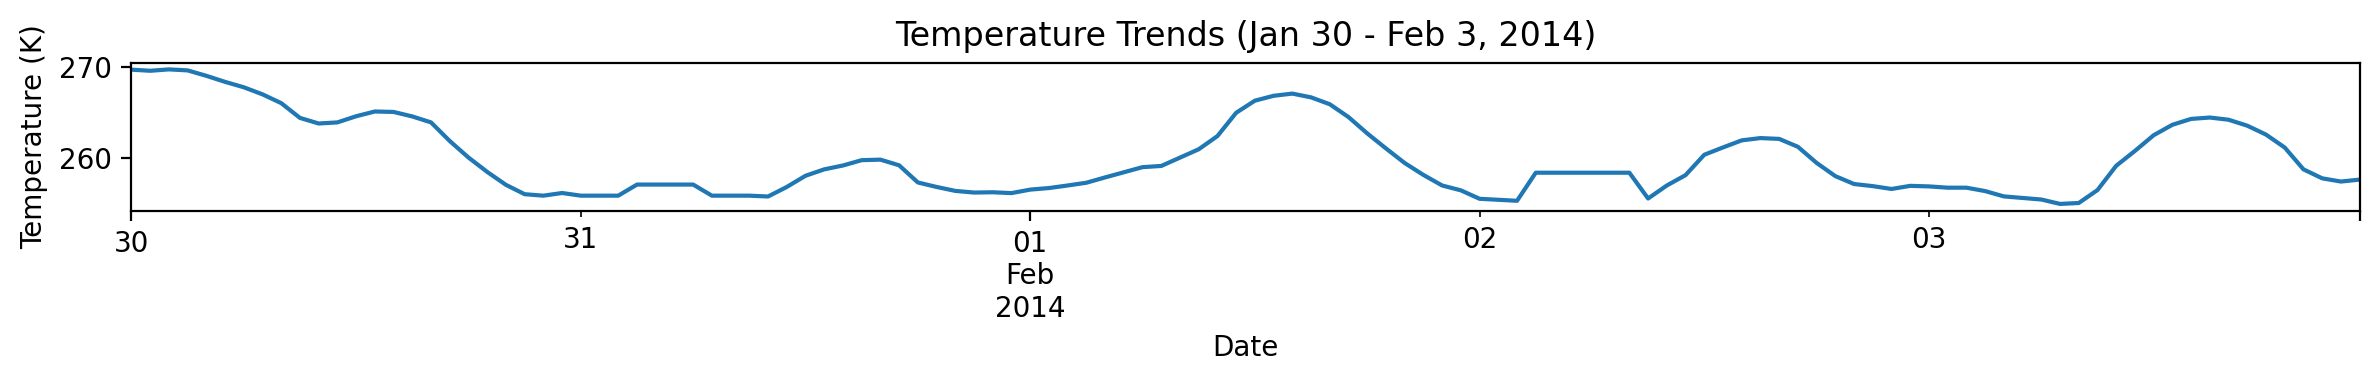

In [28]:
# Select the temperature data for the specified date range, including adjusted values
temperature_range = df_cleaned['temp']['2014-01-30':'2014-02-03']

# Plot the temperature data over the specified period
temperature_range.plot(figsize=(12, 2), title="Temperature Trends (Jan 30 - Feb 3, 2014)")
plt.xlabel("Date")
plt.ylabel("Temperature (K)")  # Adjust if temperature is in another unit
plt.tight_layout()
plt.show()


#### Rain

Rain seems to have only 1 record with extreme value, I'll just set to the general mean value of rain.

In [29]:
# Filter records where the rainfall in one hour exceeds 100 mm
heavy_rain_records = df_cleaned[df_cleaned['rain_1h'] > 100]

# Display the records with significant rainfall
display(heavy_rain_records)


holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2016-07-11 17:00:00    None 302.11  9831.30     0.00          75         Rain   

                    weather_description  traffic_volume  
date_time                                                
2016-07-11 17:00:00     very heavy rain            5535

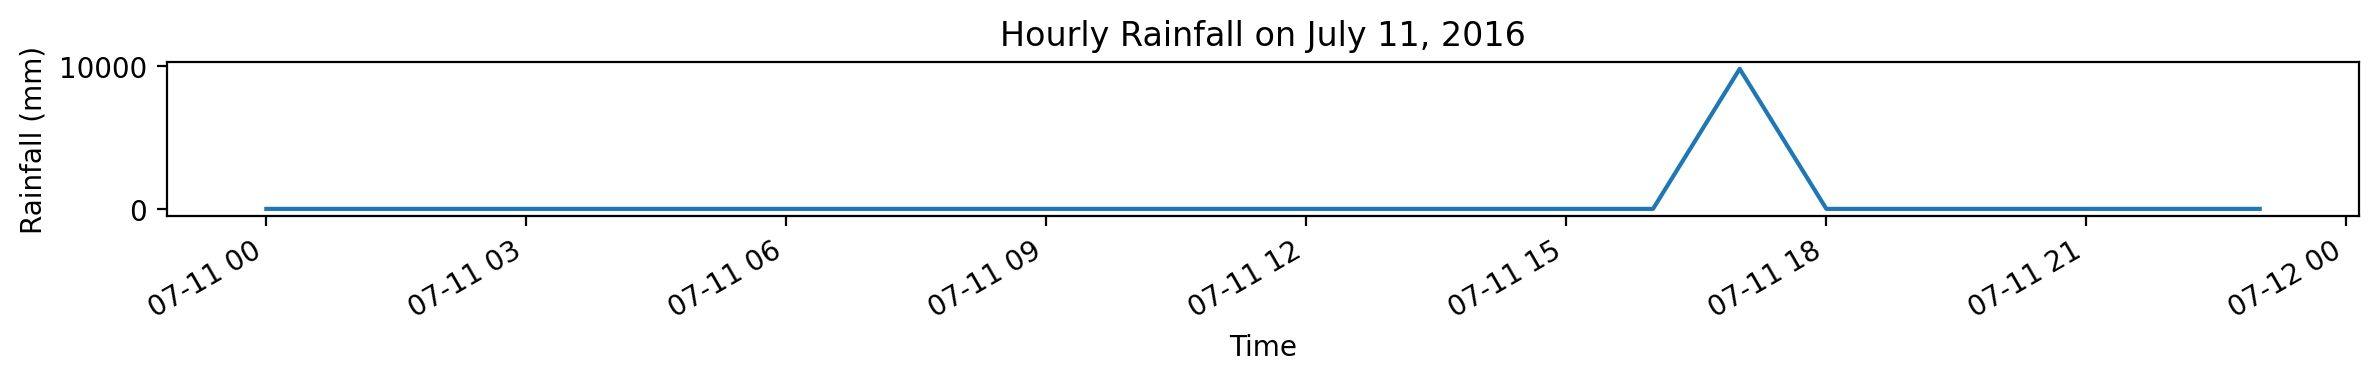

In [30]:
# Select the rainfall data for a specific date (July 11, 2016)
rainfall_july_11 = df_cleaned.loc['2016-07-11', 'rain_1h']

# Plot the hourly rainfall data for the specified date
rainfall_july_11.plot(figsize=(12, 2), title="Hourly Rainfall on July 11, 2016")
plt.xlabel("Time")
plt.ylabel("Rainfall (mm)")
plt.tight_layout()
plt.show()


In [31]:
# Create a copy of the DataFrame to work on, preserving the original data
adjusted_df = df_cleaned.copy()

# Set the rainfall value at a specific timestamp to NaN, then replace it with the mean rainfall
adjusted_df.loc['2016-07-11 17:00:00', 'rain_1h'] = np.nan  # Set to NaN initially
adjusted_df.loc['2016-07-11 17:00:00', 'rain_1h'] = adjusted_df['rain_1h'].mean()  # Replace with mean rainfall

# Display the modified row to verify the update
display(adjusted_df.loc['2016-07-11 17:00:00'])


holiday                           None
temp                            302.11
rain_1h                           0.13
snow_1h                           0.00
clouds_all                          75
weather_main                      Rain
weather_description    very heavy rain
traffic_volume                    5535
Name: 2016-07-11 17:00:00, dtype: object

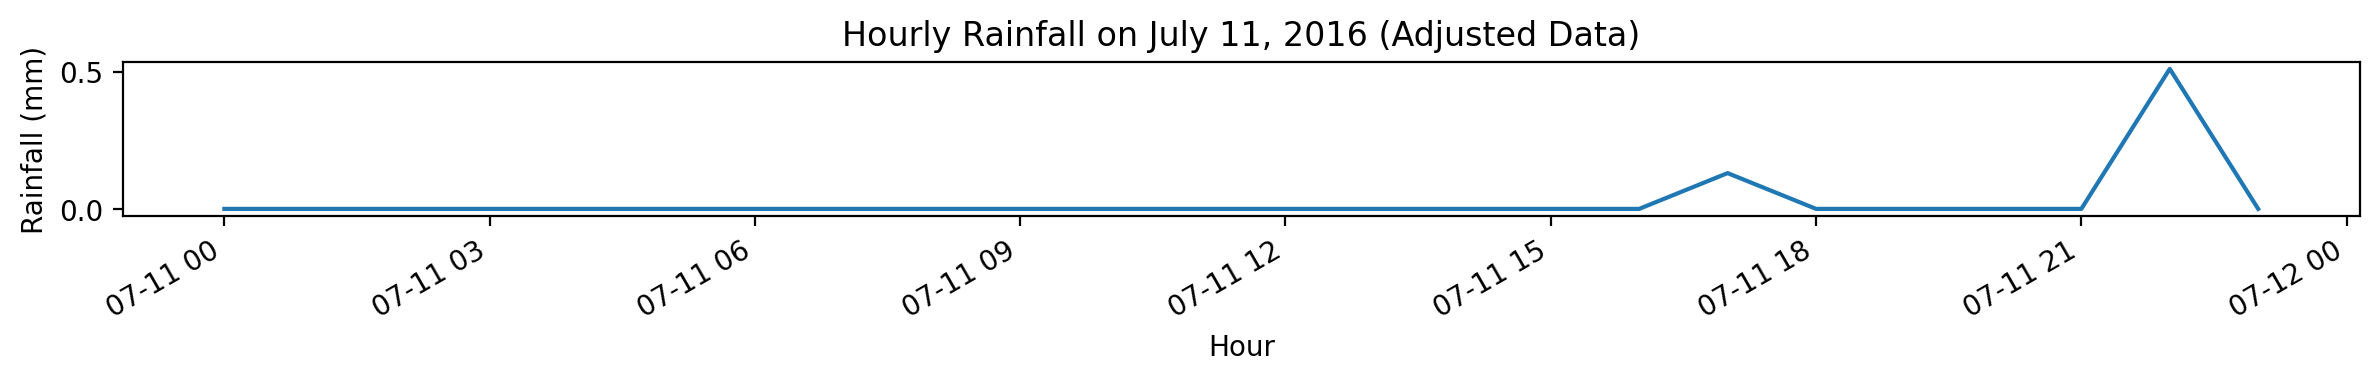

In [32]:
# Select hourly rainfall data specifically for July 11, 2016, from the adjusted DataFrame
rainfall_july_11_values = adjusted_df.loc['2016-07-11', 'rain_1h']

# Plot the rainfall values for this date to visualize hourly trends
rainfall_july_11_values.plot(
    figsize=(12, 2), 
    title="Hourly Rainfall on July 11, 2016 (Adjusted Data)"
)
plt.xlabel("Hour")
plt.ylabel("Rainfall (mm)")
plt.tight_layout()  # Ensures optimal spacing
plt.show()


#### Snow

In [33]:
# Filter records where snowfall in one hour exceeds 0.2 mm
significant_snowfall = adjusted_df[adjusted_df['snow_1h'] > 0.2]

# Display records with substantial snowfall
display(significant_snowfall)


holiday   temp  rain_1h  snow_1h  clouds_all weather_main  \
date_time                                                                       
2015-12-23 12:00:00    None 274.33     0.98     0.51          90         Rain   
2015-12-23 12:00:00    None 274.33     0.98     0.51          90         Snow   
2015-12-23 12:00:00    None 274.33     0.98     0.51          90         Mist   
2015-12-23 12:00:00    None 274.33     0.98     0.51          90          Fog   
2015-12-23 14:00:00    None 273.74     0.00     0.32          90         Snow   
2015-12-23 14:00:00    None 273.74     0.00     0.32          90         Mist   
2015-12-23 14:00:00    None 273.74     0.00     0.32          90         Rain   
2015-12-23 16:00:00    None 273.86     0.00     0.32          90         Snow   
2015-12-23 16:00:00    None 273.86     0.00     0.32          90         Mist   
2015-12-26 09:00:00    None 271.17     0.00     0.21          90         Snow   
2015-12-28 21:00:00    None 267.25     0.00     0.25          90         Snow   
2015-12-28 21:00:00    None 267.25     0.00     0.25          90         Mist   
2015-12-28 22:00:00    None 267.14     0.00     0.44          90         Snow   
2015-12-28 22:00:00    None 267.14     0.00     0.44          90         Mist   
2015-12-28 23:00:00    None 267.06     0.00     0.51          90         Snow   
2015-12-28 23:00:00    None 267.06     0.00     0.51          90         Mist   
2016-01-06 21:00:00    None 272.47     0.00     0.25          90         Snow   
2016-01-06 21:00:00    None 272.47     0.00     0.25          90         Mist   
2016-01-08 13:00:00    None 273.80     0.00     0.25          90         Snow   
2016-01-08 13:00:00    None 273.80     0.00     0.25          90         Mist   

                    weather_description  traffic_volume  
date_time                                                
2015-12-23 12:00:00       moderate rain            5167  
2015-12-23 12:00:00                snow            5167  
2015-12-23 12:00:00                mist            5167  
2015-12-23 12:00:00                 fog            5167  
2015-12-23 14:00:00          light snow            5182  
2015-12-23 14:00:00                mist            5182  
2015-12-23 14:00:00       moderate rain            5182  
2015-12-23 16:00:00          light snow            5222  
2015-12-23 16:00:00                mist            5222  
2015-12-26 09:00:00          light snow            2013  
2015-12-28 21:00:00                snow            2149  
2015-12-28 21:00:00                mist            2149  
2015-12-28 22:00:00                snow            2165  
2015-12-28 22:00:00                mist            2165  
2015-12-28 23:00:00                snow             888  
2015-12-28 23:00:00                mist             888  
2016-01-06 21:00:00          light snow            2077  
2016-01-06 21:00:00                mist            2077  
2016-01-08 13:00:00          light snow            4933  
2016-01-08 13:00:00                mist            4933

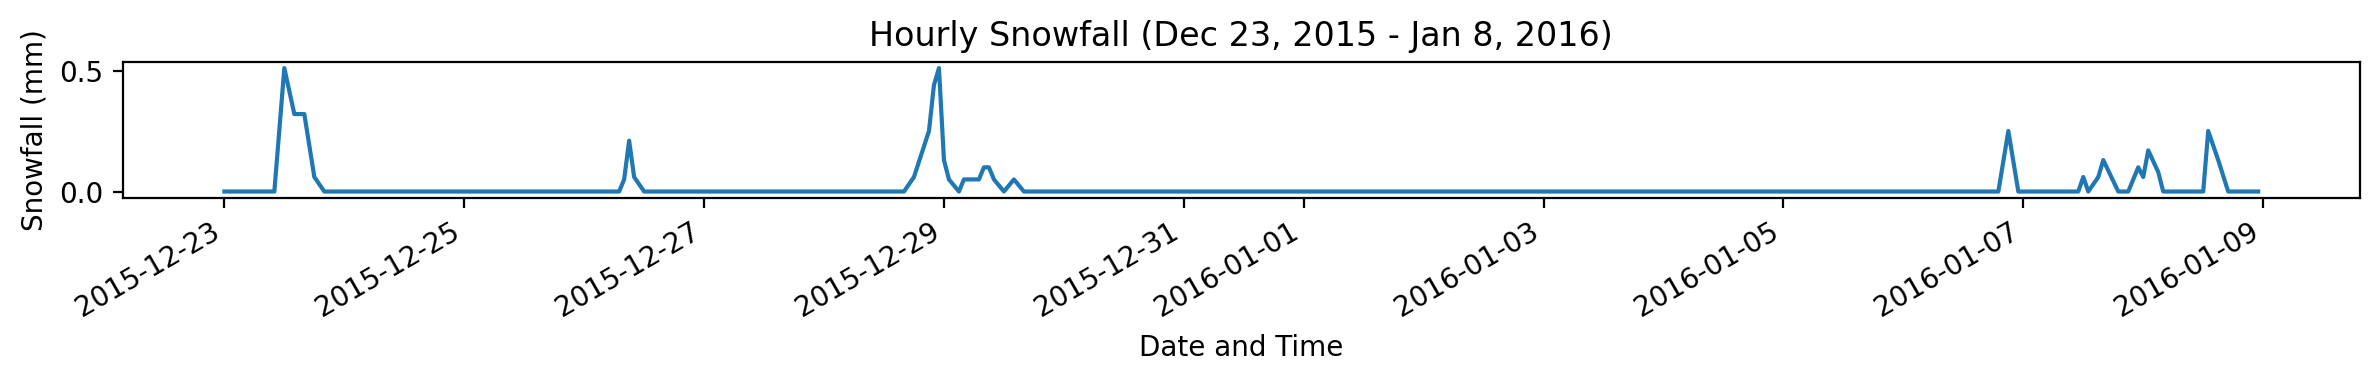

In [34]:
# Select snowfall data within the specified date range (December 23, 2015, to January 8, 2016)
snowfall_range = adjusted_df.loc['2015-12-23':'2016-01-08', 'snow_1h']

# Plot snowfall data for the selected range to observe hourly trends
snowfall_range.plot(
    figsize=(12, 2), 
    title="Hourly Snowfall (Dec 23, 2015 - Jan 8, 2016)"
)
plt.xlabel("Date and Time")
plt.ylabel("Snowfall (mm)")
plt.tight_layout()  # Adjust layout for optimal spacing
plt.show()


### Cleaned Data Overview

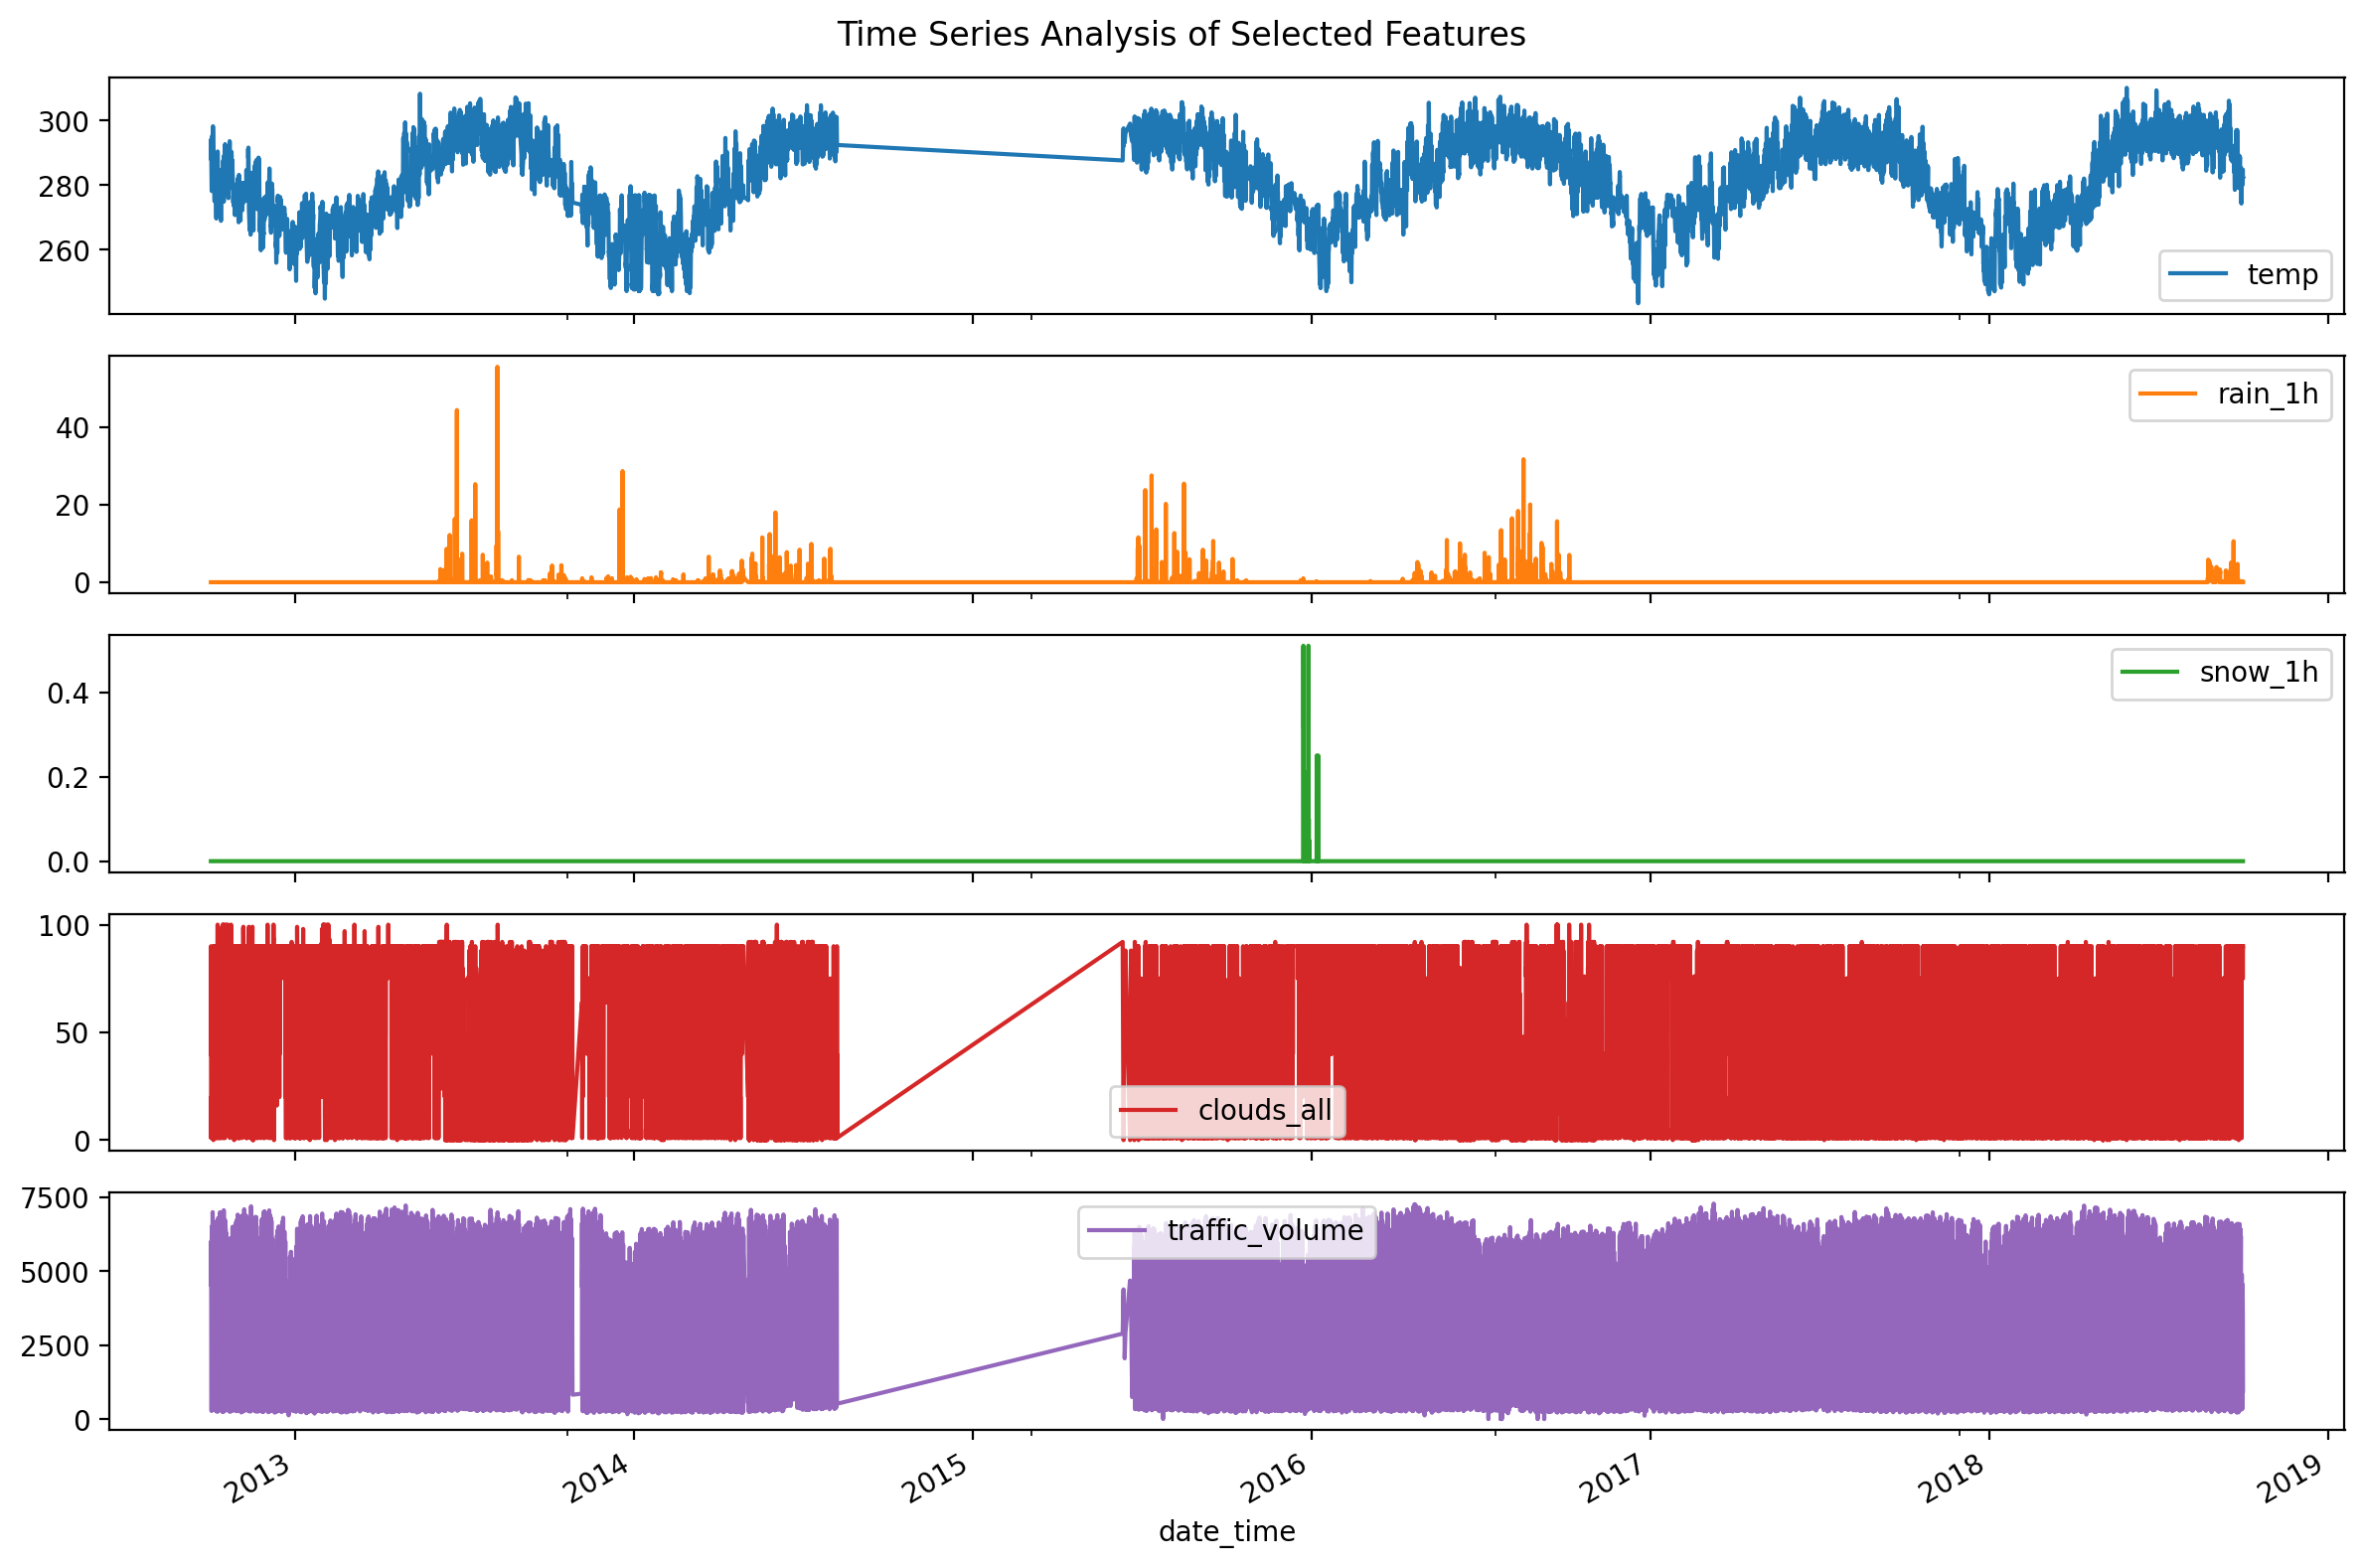

In [35]:
plot_columns = ['temp', 'rain_1h', 'snow_1h', 'clouds_all','traffic_volume']
# Select columns of interest for visualization
features_to_plot = adjusted_df[plot_columns]

# Create subplots for each selected feature to observe trends over time
features_to_plot.plot(
    subplots=True, 
    figsize=(12, 8), 
    title="Time Series Analysis of Selected Features"
)

# Adjust layout to avoid overlapping subplots
plt.tight_layout()

# Display the plots
plt.show()


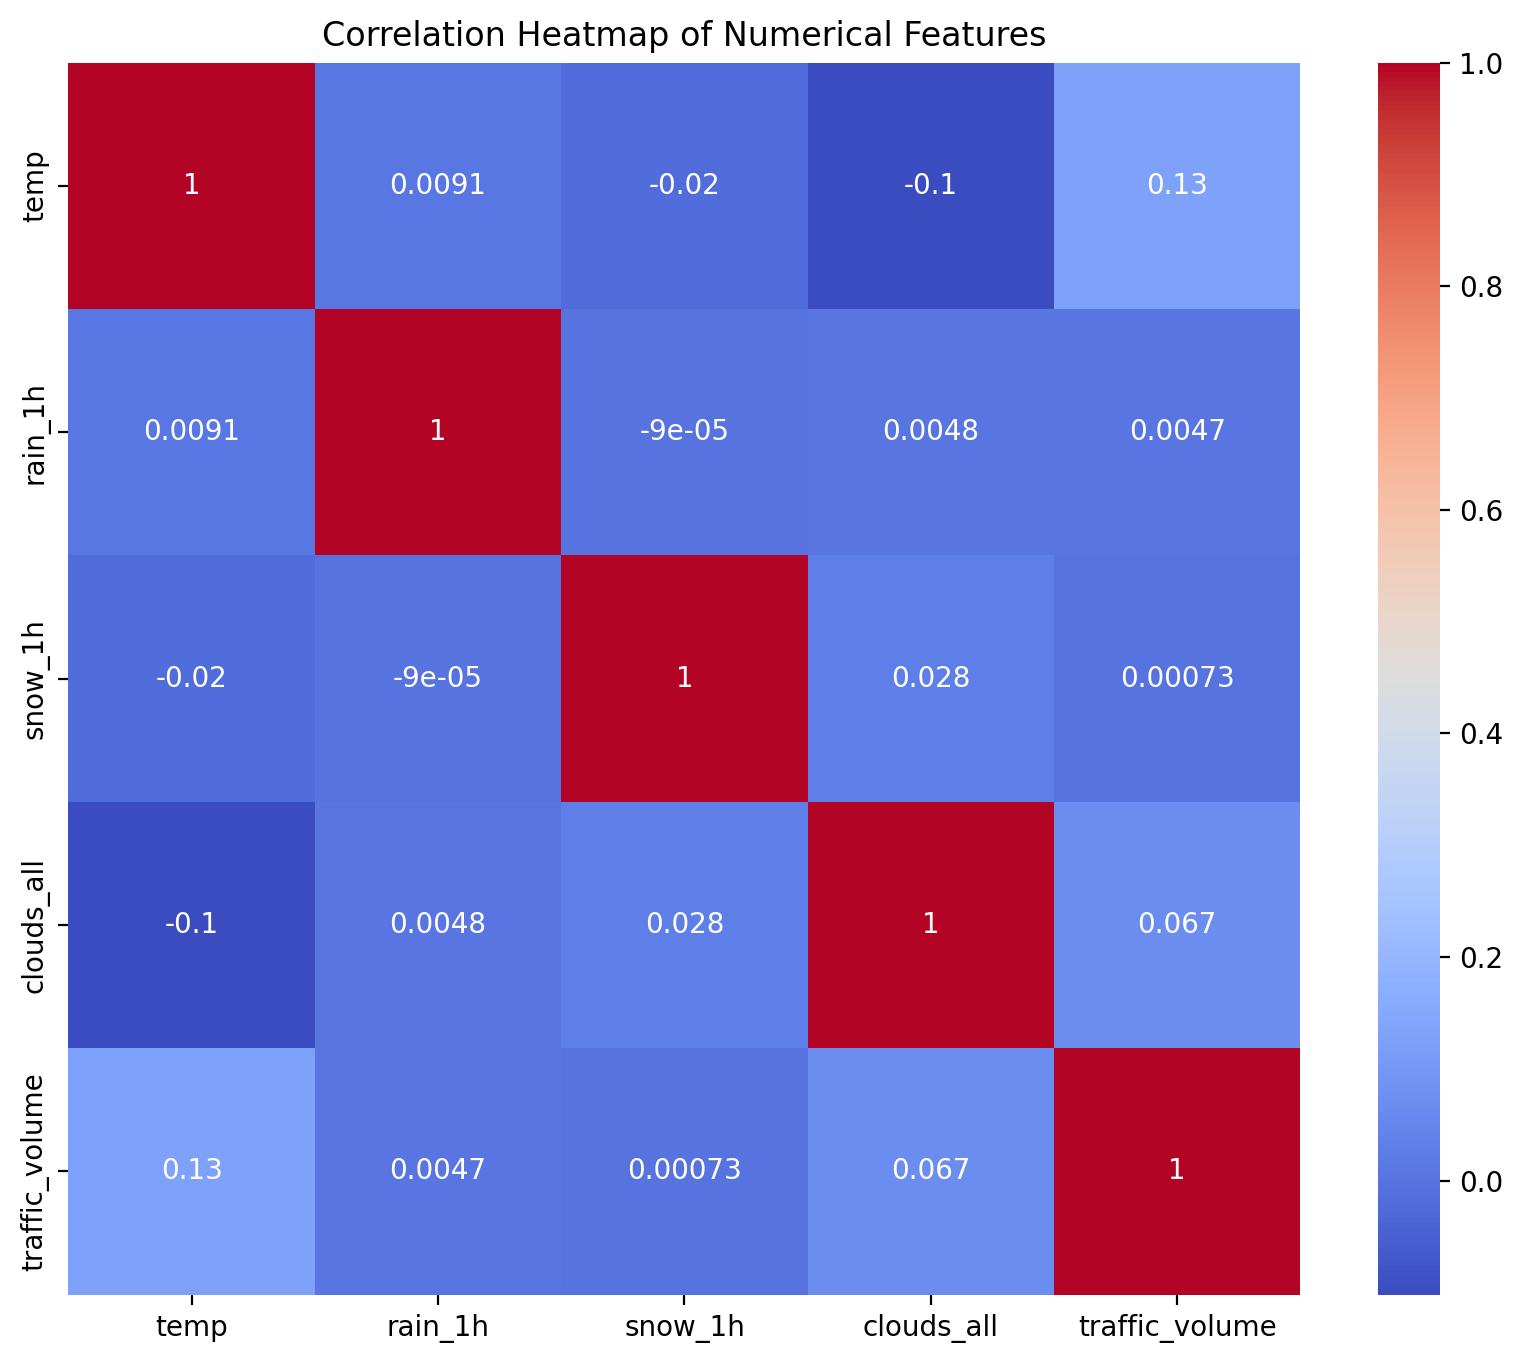

In [36]:
# Check correlation between numerical features to identify relationships
plt.figure(figsize=(10, 8))
correlation_matrix = df_raw.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


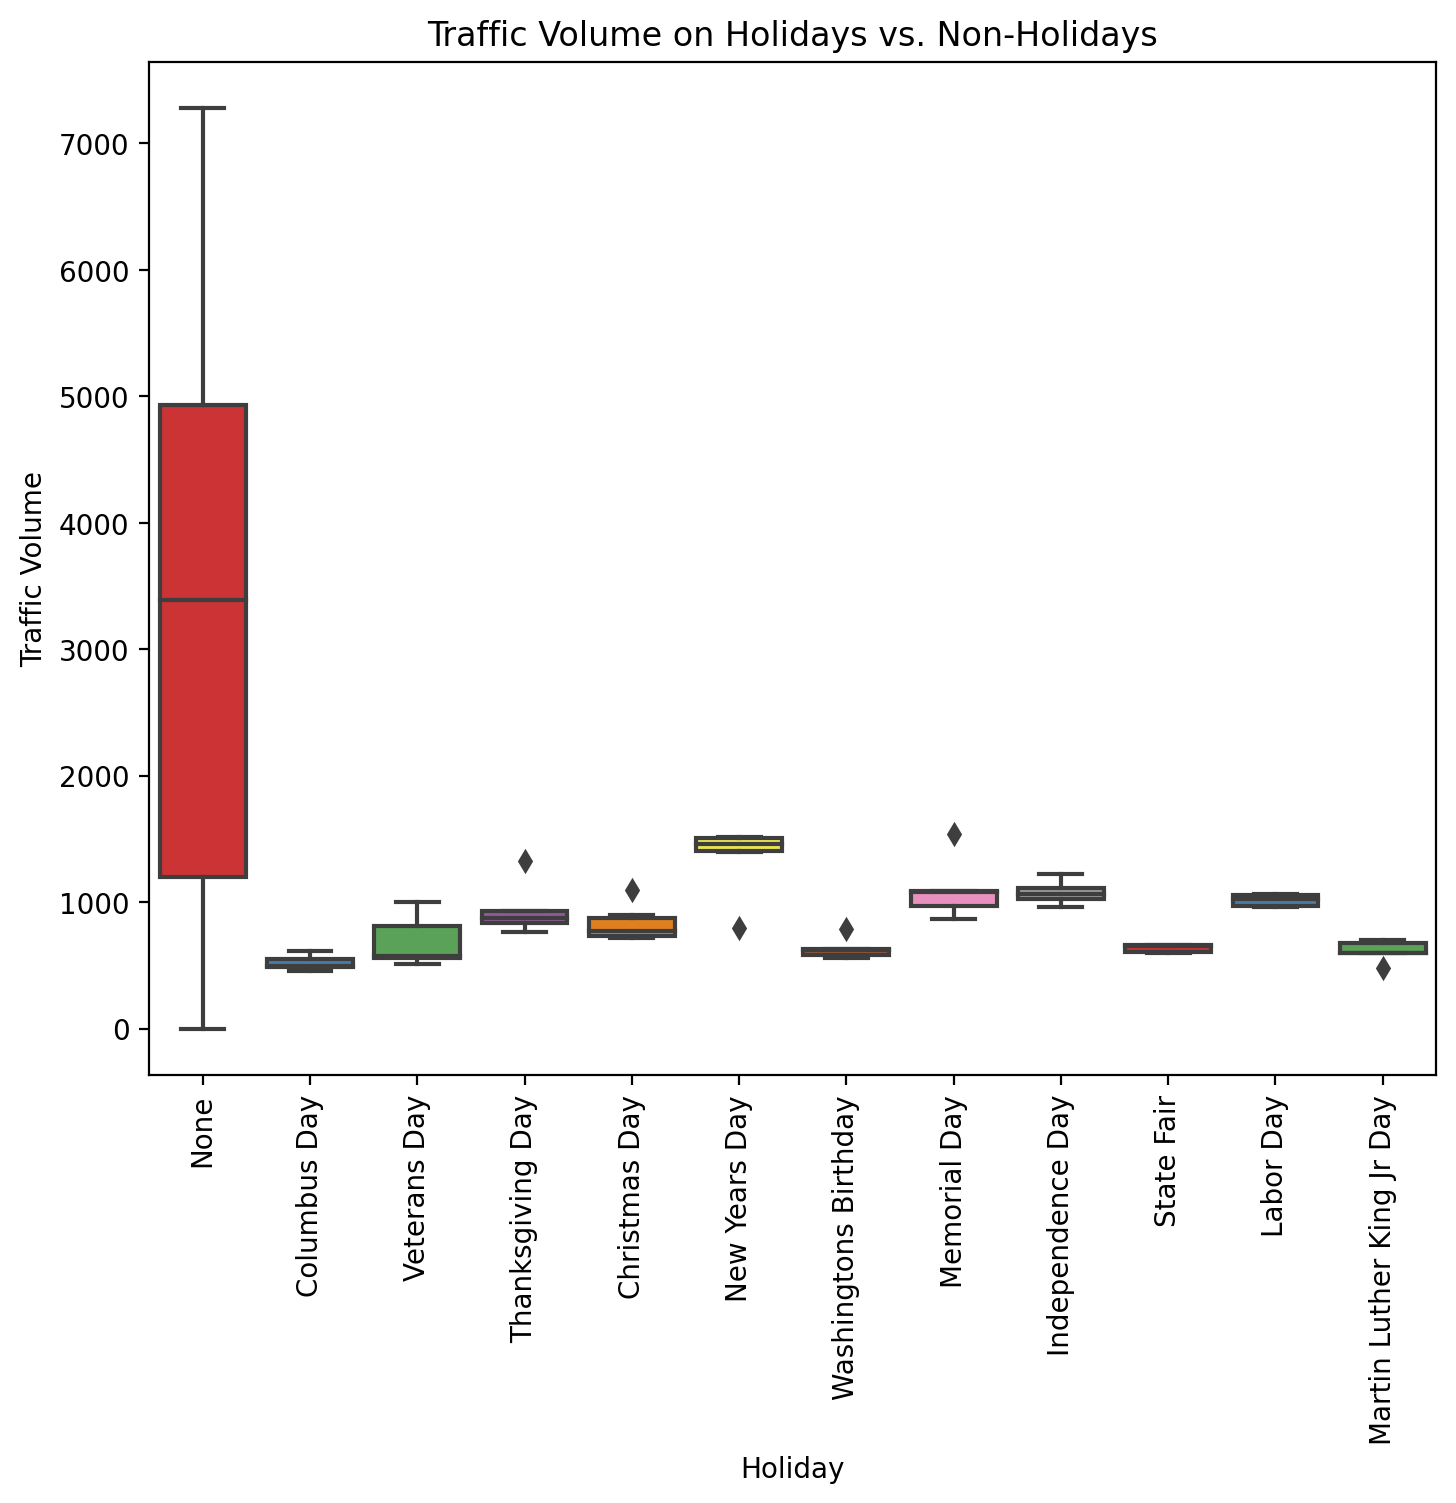

In [37]:
# Plot traffic volume for holidays vs non-holidays
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_raw, x='holiday', y='traffic_volume', palette="Set1")
plt.title("Traffic Volume on Holidays vs. Non-Holidays")
plt.xlabel("Holiday")
plt.ylabel("Traffic Volume")
plt.tight_layout()
plt.xticks(rotation=90)  # Rotate x-axis labels by 45 degrees

plt.show()



### Feature engineering


#### Weather_main and Weather description

In [38]:
# Create a copy of the DataFrame to make adjustments without modifying the original
df_adjusted = adjusted_df.copy()

# Drop the 'weather_description' column from the DataFrame
df_adjusted.drop(columns=['weather_description'], inplace=True)

# Display information about the modified DataFrame to verify the change
df_adjusted.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         48204 non-null  object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   traffic_volume  48204 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 3.9+ MB


In [39]:
# Apply one-hot encoding to the 'weather_main' column and add the new columns to the DataFrame
df_encoded = pd.get_dummies(df_adjusted, columns=['weather_main'], prefix='weather')

# Display the structure of the updated DataFrame to confirm the encoding
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   holiday               48204 non-null  object 
 1   temp                  48204 non-null  float64
 2   rain_1h               48204 non-null  float64
 3   snow_1h               48204 non-null  float64
 4   clouds_all            48204 non-null  int64  
 5   traffic_volume        48204 non-null  int64  
 6   weather_Clear         48204 non-null  uint8  
 7   weather_Clouds        48204 non-null  uint8  
 8   weather_Drizzle       48204 non-null  uint8  
 9   weather_Fog           48204 non-null  uint8  
 10  weather_Haze          48204 non-null  uint8  
 11  weather_Mist          48204 non-null  uint8  
 12  weather_Rain          48204 non-null  uint8  
 13  weather_Smoke         48204 non-null  uint8  
 14  weather_Snow          48204 non-nul

#### Holidays and Weekends

In [40]:
# Create a copy of the DataFrame to make additional modifications
df_holiday_encoded = df_encoded.copy()

# Transform the 'holiday' column into a binary column, indicating if it’s a holiday
df_holiday_encoded['is_holiday'] = df_holiday_encoded.pop('holiday').apply(lambda x: 1 if x != 'None' else 0)

# Display information about the modified DataFrame to verify the transformation
df_holiday_encoded.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temp                  48204 non-null  float64
 1   rain_1h               48204 non-null  float64
 2   snow_1h               48204 non-null  float64
 3   clouds_all            48204 non-null  int64  
 4   traffic_volume        48204 non-null  int64  
 5   weather_Clear         48204 non-null  uint8  
 6   weather_Clouds        48204 non-null  uint8  
 7   weather_Drizzle       48204 non-null  uint8  
 8   weather_Fog           48204 non-null  uint8  
 9   weather_Haze          48204 non-null  uint8  
 10  weather_Mist          48204 non-null  uint8  
 11  weather_Rain          48204 non-null  uint8  
 12  weather_Smoke         48204 non-null  uint8  
 13  weather_Snow          48204 non-null  uint8  
 14  weather_Squall        48204 non-nul

In [41]:
# Display sample rows where the 'is_holiday' column indicates it is not a holiday (value is 0)
non_holiday_samples = df_holiday_encoded[df_holiday_encoded['is_holiday'] == 0].head()

# Show the sample data for verification
display(non_holiday_samples)


temp  rain_1h  snow_1h  clouds_all  traffic_volume  \
date_time                                                                  
2012-10-02 09:00:00 288.28     0.00     0.00          40            5545   
2012-10-02 10:00:00 289.36     0.00     0.00          75            4516   
2012-10-02 11:00:00 289.58     0.00     0.00          90            4767   
2012-10-02 12:00:00 290.13     0.00     0.00          90            5026   
2012-10-02 13:00:00 291.14     0.00     0.00          75            4918   

                     weather_Clear  weather_Clouds  weather_Drizzle  \
date_time                                                             
2012-10-02 09:00:00              0               1                0   
2012-10-02 10:00:00              0               1                0   
2012-10-02 11:00:00              0               1                0   
2012-10-02 12:00:00              0               1                0   
2012-10-02 13:00:00              0               1                0   

                     weather_Fog  weather_Haze  weather_Mist  weather_Rain  \
date_time                                                                    
2012-10-02 09:00:00            0             0             0             0   
2012-10-02 10:00:00            0             0             0             0   
2012-10-02 11:00:00            0             0             0             0   
2012-10-02 12:00:00            0             0             0             0   
2012-10-02 13:00:00            0             0             0             0   

                     weather_Smoke  weather_Snow  weather_Squall  \
date_time                                                          
2012-10-02 09:00:00              0             0               0   
2012-10-02 10:00:00              0             0               0   
2012-10-02 11:00:00              0             0               0   
2012-10-02 12:00:00              0             0               0   
2012-10-02 13:00:00              0             0               0   

                     weather_Thunderstorm  is_holiday  
date_time                                              
2012-10-02 09:00:00                     0           0  
2012-10-02 10:00:00                     0           0  
2012-10-02 11:00:00                     0           0  
2012-10-02 12:00:00                     0           0  
2012-10-02 13:00:00                     0           0

In [42]:
# Display sample rows where the 'is_holiday' column indicates it is a holiday (value is 1)
holiday_samples = df_holiday_encoded[df_holiday_encoded['is_holiday'] == 1].head()

# Show the sample data for verification
display(holiday_samples)


temp  rain_1h  snow_1h  clouds_all  traffic_volume  \
date_time                                                         
2012-10-08 273.08     0.00     0.00          20             455   
2012-11-12 288.12     0.00     0.00          87            1000   
2012-11-22 278.54     0.00     0.00          20             919   
2012-12-25 264.40     0.00     0.00          90             803   
2013-01-01 263.49     0.00     0.00          58            1439   

            weather_Clear  weather_Clouds  weather_Drizzle  weather_Fog  \
date_time                                                                 
2012-10-08              0               1                0            0   
2012-11-12              1               0                0            0   
2012-11-22              0               0                0            0   
2012-12-25              0               1                0            0   
2013-01-01              0               1                0            0   

            weather_Haze  weather_Mist  weather_Rain  weather_Smoke  \
date_time                                                             
2012-10-08             0             0             0              0   
2012-11-12             0             0             0              0   
2012-11-22             0             1             0              0   
2012-12-25             0             0             0              0   
2013-01-01             0             0             0              0   

            weather_Snow  weather_Squall  weather_Thunderstorm  is_holiday  
date_time                                                                   
2012-10-08             0               0                     0           1  
2012-11-12             0               0                     0           1  
2012-11-22             0               0                     0           1  
2012-12-25             0               0                     0           1  
2013-01-01             0               0                     0           1

In [43]:
# Create a new column 'is_weekend' to indicate if the day is a weekend (1 for Saturday/Sunday, 0 for other days)
df_holiday_encoded['is_weekend'] = df_holiday_encoded.index.day_name().map(
    lambda x: 1 if x in ['Saturday', 'Sunday'] else 0
)


# Display the DataFrame information to verify the new column
df_holiday_encoded.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temp                  48204 non-null  float64
 1   rain_1h               48204 non-null  float64
 2   snow_1h               48204 non-null  float64
 3   clouds_all            48204 non-null  int64  
 4   traffic_volume        48204 non-null  int64  
 5   weather_Clear         48204 non-null  uint8  
 6   weather_Clouds        48204 non-null  uint8  
 7   weather_Drizzle       48204 non-null  uint8  
 8   weather_Fog           48204 non-null  uint8  
 9   weather_Haze          48204 non-null  uint8  
 10  weather_Mist          48204 non-null  uint8  
 11  weather_Rain          48204 non-null  uint8  
 12  weather_Smoke         48204 non-null  uint8  
 13  weather_Snow          48204 non-null  uint8  
 14  weather_Squall        48204 non-nul

In [44]:
# Display the first few rows to verify the new column
df_holiday_encoded.head()


temp  rain_1h  snow_1h  clouds_all  traffic_volume  \
date_time                                                                  
2012-10-02 09:00:00 288.28     0.00     0.00          40            5545   
2012-10-02 10:00:00 289.36     0.00     0.00          75            4516   
2012-10-02 11:00:00 289.58     0.00     0.00          90            4767   
2012-10-02 12:00:00 290.13     0.00     0.00          90            5026   
2012-10-02 13:00:00 291.14     0.00     0.00          75            4918   

                     weather_Clear  weather_Clouds  weather_Drizzle  \
date_time                                                             
2012-10-02 09:00:00              0               1                0   
2012-10-02 10:00:00              0               1                0   
2012-10-02 11:00:00              0               1                0   
2012-10-02 12:00:00              0               1                0   
2012-10-02 13:00:00              0               1                0   

                     weather_Fog  weather_Haze  weather_Mist  weather_Rain  \
date_time                                                                    
2012-10-02 09:00:00            0             0             0             0   
2012-10-02 10:00:00            0             0             0             0   
2012-10-02 11:00:00            0             0             0             0   
2012-10-02 12:00:00            0             0             0             0   
2012-10-02 13:00:00            0             0             0             0   

                     weather_Smoke  weather_Snow  weather_Squall  \
date_time                                                          
2012-10-02 09:00:00              0             0               0   
2012-10-02 10:00:00              0             0               0   
2012-10-02 11:00:00              0             0               0   
2012-10-02 12:00:00              0             0               0   
2012-10-02 13:00:00              0             0               0   

                     weather_Thunderstorm  is_holiday  is_weekend  
date_time                                                          
2012-10-02 09:00:00                     0           0           0  
2012-10-02 10:00:00                     0           0           0  
2012-10-02 11:00:00                     0           0           0  
2012-10-02 12:00:00                     0           0           0  
2012-10-02 13:00:00                     0           0           0

In [45]:
# Filter the DataFrame to get rows that are not weekends (weekdays)
weekday_days = df_holiday_encoded[df_holiday_encoded['is_weekend'] == 0].index.day_name()

# Display the days of the week that are weekdays (Monday through Friday)
display(weekday_days)

Index(['Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       ...
       'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday', 'Friday',
       'Friday', 'Friday', 'Friday'],
      dtype='object', name='date_time', length=34501)

In [46]:
# Filter the DataFrame to get rows that are weekends (Saturday or Sunday)
weekend_days = df_holiday_encoded[df_holiday_encoded['is_weekend'] == 1].index.day_name()

# Display the days of the week that are weekends (Saturday and Sunday)
display(weekend_days)


Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday',
       ...
       'Sunday', 'Sunday', 'Sunday', 'Sunday', 'Sunday', 'Sunday', 'Sunday',
       'Sunday', 'Sunday', 'Sunday'],
      dtype='object', name='date_time', length=13703)

#### Time

In [47]:
timestamp_s = df_holiday_encoded.index.map(datetime.datetime.timestamp)
print(timestamp_s)

Float64Index([1349186400.0, 1349190000.0, 1349193600.0, 1349197200.0,
              1349200800.0, 1349204400.0, 1349208000.0, 1349211600.0,
              1349215200.0, 1349218800.0,
              ...
              1538337600.0, 1538337600.0, 1538341200.0, 1538344800.0,
              1538348400.0, 1538352000.0, 1538355600.0, 1538359200.0,
              1538362800.0, 1538366400.0],
             dtype='float64', name='date_time', length=48204)


In [48]:
day = 24*60*60
year = (365.2425)*day

df_holiday_encoded['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_holiday_encoded['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_holiday_encoded['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_holiday_encoded['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df_holiday_encoded

temp  rain_1h  snow_1h  clouds_all  traffic_volume  \
date_time                                                                  
2012-10-02 09:00:00 288.28     0.00     0.00          40            5545   
2012-10-02 10:00:00 289.36     0.00     0.00          75            4516   
2012-10-02 11:00:00 289.58     0.00     0.00          90            4767   
2012-10-02 12:00:00 290.13     0.00     0.00          90            5026   
2012-10-02 13:00:00 291.14     0.00     0.00          75            4918   
...                    ...      ...      ...         ...             ...   
2018-09-30 19:00:00 283.45     0.00     0.00          75            3543   
2018-09-30 20:00:00 282.76     0.00     0.00          90            2781   
2018-09-30 21:00:00 282.73     0.00     0.00          90            2159   
2018-09-30 22:00:00 282.09     0.00     0.00          90            1450   
2018-09-30 23:00:00 282.12     0.00     0.00          90             954   

                     weather_Clear  weather_Clouds  weather_Drizzle  \
date_time                                                             
2012-10-02 09:00:00              0               1                0   
2012-10-02 10:00:00              0               1                0   
2012-10-02 11:00:00              0               1                0   
2012-10-02 12:00:00              0               1                0   
2012-10-02 13:00:00              0               1                0   
...                            ...             ...              ...   
2018-09-30 19:00:00              0               1                0   
2018-09-30 20:00:00              0               1                0   
2018-09-30 21:00:00              0               0                0   
2018-09-30 22:00:00              0               1                0   
2018-09-30 23:00:00              0               1                0   

                     weather_Fog  weather_Haze  ...  weather_Smoke  \
date_time                                       ...                  
2012-10-02 09:00:00            0             0  ...              0   
2012-10-02 10:00:00            0             0  ...              0   
2012-10-02 11:00:00            0             0  ...              0   
2012-10-02 12:00:00            0             0  ...              0   
2012-10-02 13:00:00            0             0  ...              0   
...                          ...           ...  ...            ...   
2018-09-30 19:00:00            0             0  ...              0   
2018-09-30 20:00:00            0             0  ...              0   
2018-09-30 21:00:00            0             0  ...              0   
2018-09-30 22:00:00            0             0  ...              0   
2018-09-30 23:00:00            0             0  ...              0   

                     weather_Snow  weather_Squall  weather_Thunderstorm  \
date_time                                                                 
2012-10-02 09:00:00             0               0                     0   
2012-10-02 10:00:00             0               0                     0   
2012-10-02 11:00:00             0               0                     0   
2012-10-02 12:00:00             0               0                     0   
2012-10-02 13:00:00             0               0                     0   
...                           ...             ...                   ...   
2018-09-30 19:00:00             0               0                     0   
2018-09-30 20:00:00             0               0                     0   
2018-09-30 21:00:00             0               0                     1   
2018-09-30 22:00:00             0               0                     0   
2018-09-30 23:00:00             0               0                     0   

                     is_holiday  is_weekend  Day sin  Day cos  Year sin  \
date_time                                                                 
2012-10-02 09:00:00           0           0    -0.50    -0.87     -1.00 

Text(0.5, 1.0, 'Time of day signal')

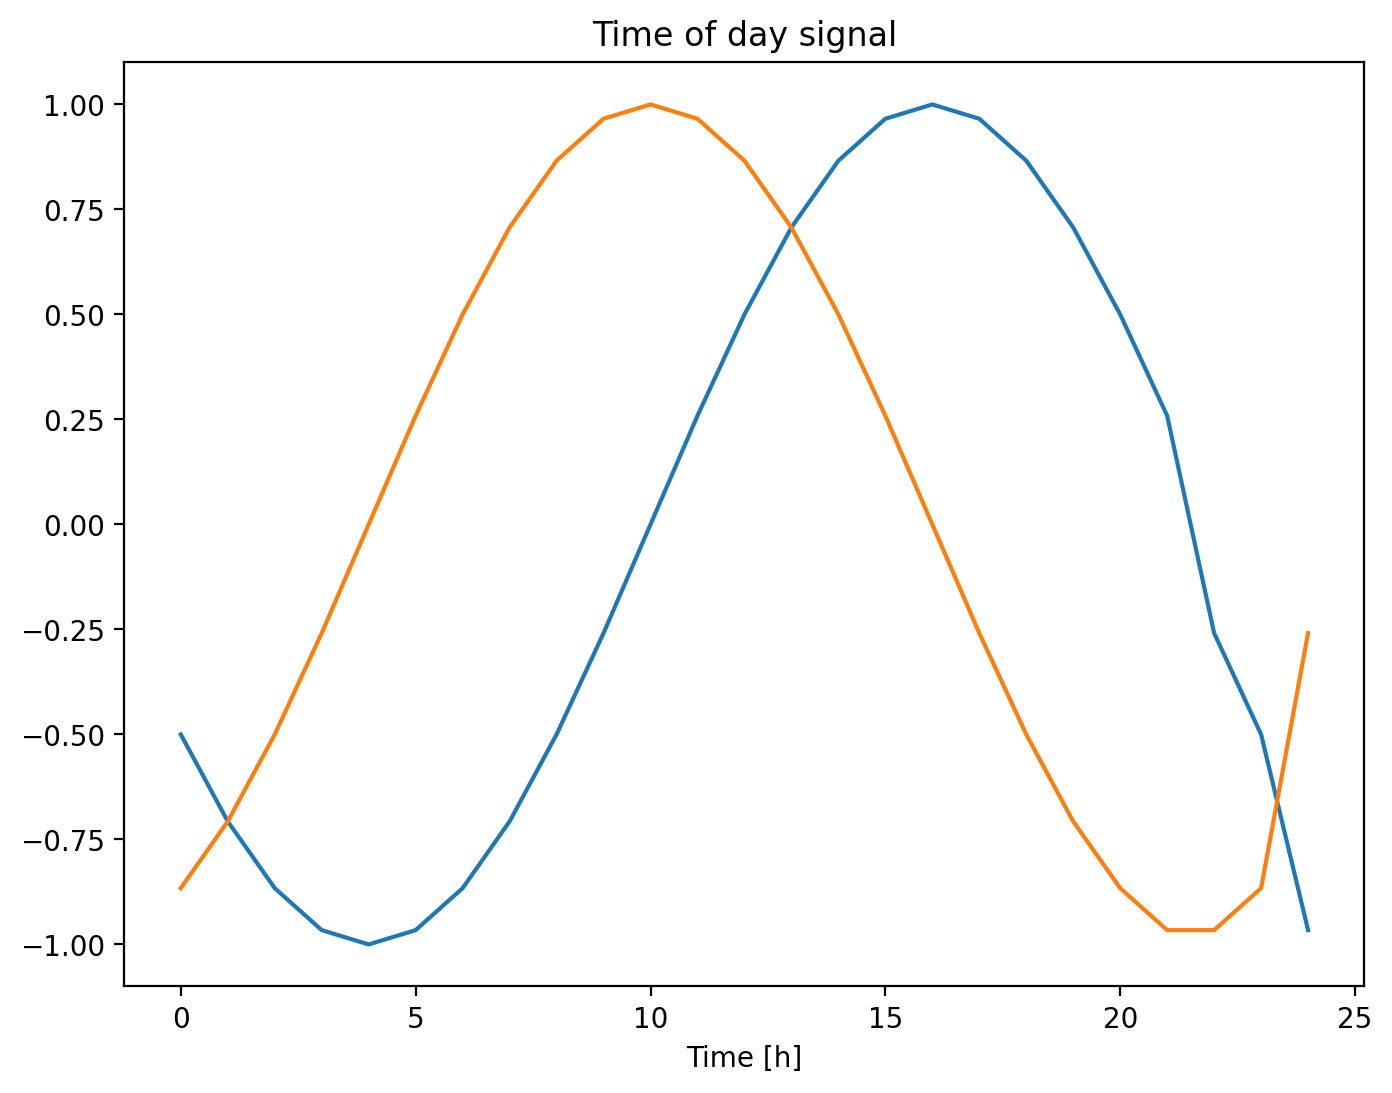

In [49]:
plt.plot(np.array(df_holiday_encoded['Day sin'])[:25])
plt.plot(np.array(df_holiday_encoded['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

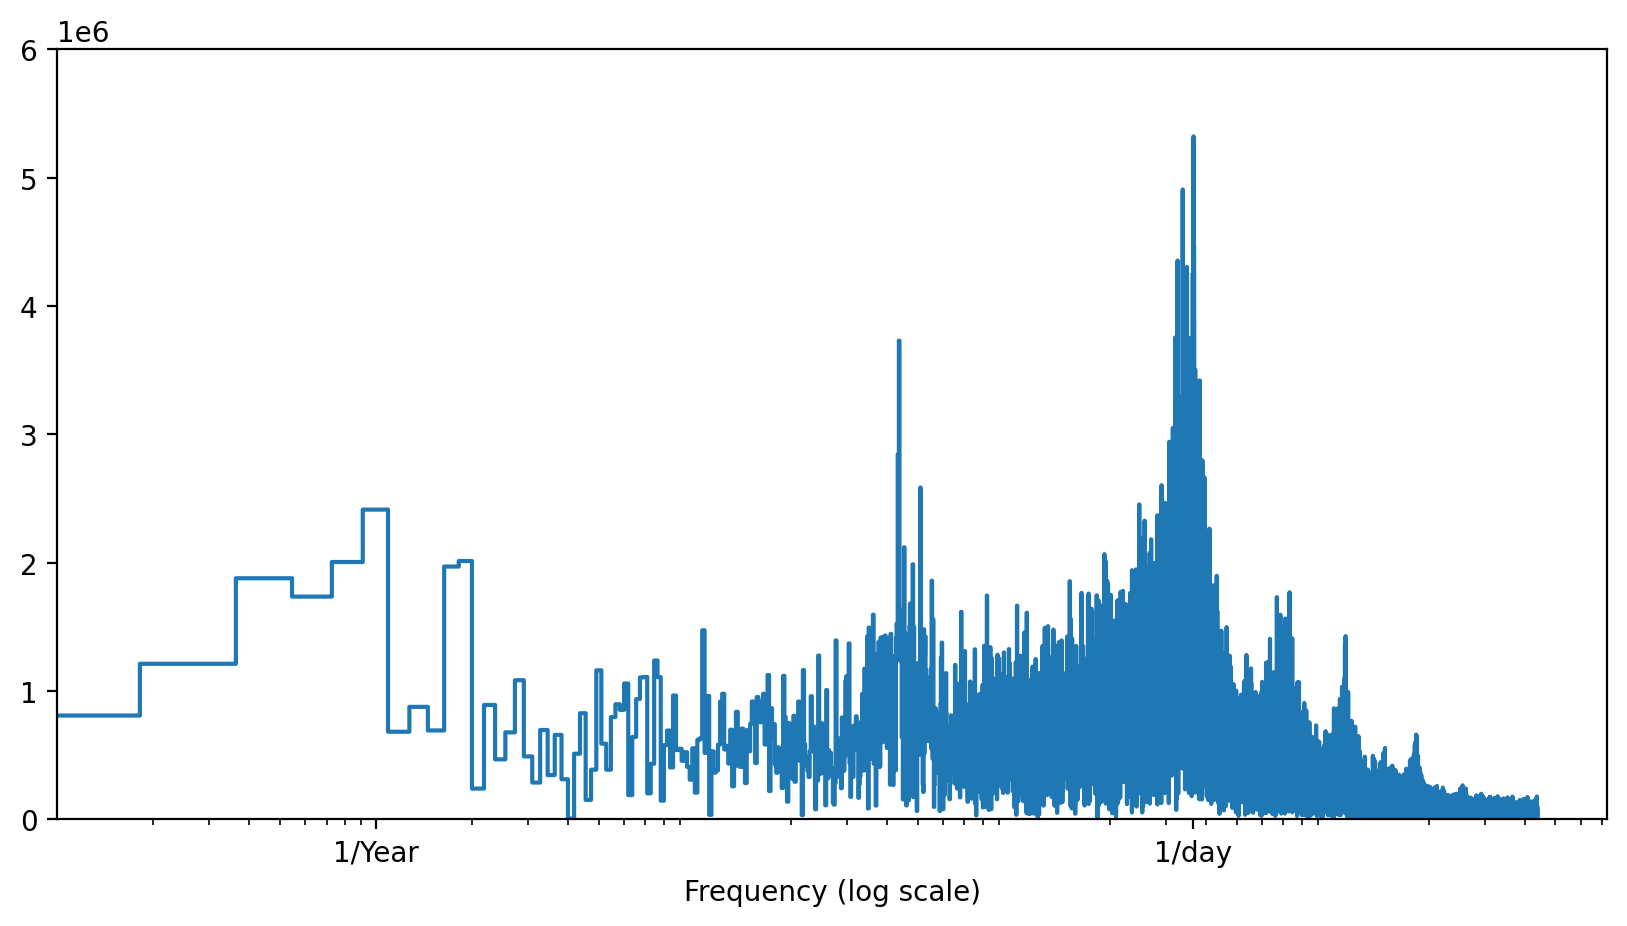

In [50]:
fft = tf.signal.rfft(df_holiday_encoded['traffic_volume'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_holiday_encoded['traffic_volume'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.figure(figsize=(10, 5))
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 6e6)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

Let's also break down the date_time components into other fields.

In [51]:
df_holiday_encoded['dayofweek'] = df_holiday_encoded.index.dayofweek
df_holiday_encoded['day'] = df_holiday_encoded.index.day
df_holiday_encoded['month'] = df_holiday_encoded.index.month
df_holiday_encoded['year'] = df_holiday_encoded.index.year
df_holiday_encoded['day_hour'] = df_holiday_encoded.index.hour

### Reorder dataframe columns

In [52]:
df_5 = df_holiday_encoded.copy()

In [53]:
df_5.insert(0, 'traffic_volume', df_5.pop('traffic_volume'))
df_5.insert(1, 'Day sin', df_5.pop('Day sin'))
df_5.insert(2, 'Day cos', df_5.pop('Day cos'))
df_5.insert(3, 'Year sin', df_5.pop('Year sin'))
df_5.insert(4, 'Year cos', df_5.pop('Year cos'))
df_5.insert(5, 'temp', df_5.pop('temp'))
df_5.insert(6, 'clouds_all', df_5.pop('clouds_all'))
df_5.insert(7, 'rain_1h', df_5.pop('rain_1h'))
df_5.insert(8, 'snow_1h', df_5.pop('snow_1h'))
df_5.insert(9, 'is_weekend', df_5.pop('is_weekend'))
df_5.insert(10, 'is_holiday', df_5.pop('is_holiday'))

### Save clean data

In [54]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   traffic_volume        48204 non-null  int64  
 1   Day sin               48204 non-null  float64
 2   Day cos               48204 non-null  float64
 3   Year sin              48204 non-null  float64
 4   Year cos              48204 non-null  float64
 5   temp                  48204 non-null  float64
 6   clouds_all            48204 non-null  int64  
 7   rain_1h               48204 non-null  float64
 8   snow_1h               48204 non-null  float64
 9   is_weekend            48204 non-null  int64  
 10  is_holiday            48204 non-null  int64  
 11  weather_Clear         48204 non-null  uint8  
 12  weather_Clouds        48204 non-null  uint8  
 13  weather_Drizzle       48204 non-null  uint8  
 14  weather_Fog           48204 non-nul

In [55]:
df_5.to_csv('metro_interstate_clean.zip',
          compression=dict(method='zip', archive_name='metro_interstate_clean.csv'),
          index=True)

## Prepare for timeseries data processing

### Load clean data


In [56]:
df_clean = pd.read_csv('metro_interstate_clean.zip', parse_dates=['date_time'], index_col='date_time')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   traffic_volume        48204 non-null  int64  
 1   Day sin               48204 non-null  float64
 2   Day cos               48204 non-null  float64
 3   Year sin              48204 non-null  float64
 4   Year cos              48204 non-null  float64
 5   temp                  48204 non-null  float64
 6   clouds_all            48204 non-null  int64  
 7   rain_1h               48204 non-null  float64
 8   snow_1h               48204 non-null  float64
 9   is_weekend            48204 non-null  int64  
 10  is_holiday            48204 non-null  int64  
 11  weather_Clear         48204 non-null  int64  
 12  weather_Clouds        48204 non-null  int64  
 13  weather_Drizzle       48204 non-null  int64  
 14  weather_Fog           48204 non-nul

In [57]:
df_clean.describe().T

count    mean     std     min     25%     50%     75%  \
traffic_volume       48204.00 3259.82 1986.86    0.00 1193.00 3380.00 4933.00   
Day sin              48204.00    0.01    0.71   -1.00   -0.71    0.00    0.71   
Day cos              48204.00   -0.01    0.71   -1.00   -0.71   -0.00    0.71   
Year sin             48204.00    0.01    0.70   -1.00   -0.67   -0.01    0.71   
Year cos             48204.00   -0.03    0.72   -1.00   -0.74   -0.09    0.71   
temp                 48204.00  281.26   12.71  243.39  272.16  282.45  291.81   
clouds_all           48204.00   49.36   39.02    0.00    1.00   64.00   90.00   
rain_1h              48204.00    0.13    1.00    0.00    0.00    0.00    0.00   
snow_1h              48204.00    0.00    0.01    0.00    0.00    0.00    0.00   
is_weekend           48204.00    0.28    0.45    0.00    0.00    0.00    1.00   
is_holiday           48204.00    0.00    0.04    0.00    0.00    0.00    0.00   
weather_Clear        48204.00    0.28    0.45    0.00    0.00    0.00    1.00   
weather_Clouds       48204.00    0.31    0.46    0.00    0.00    0.00    1.00   
weather_Drizzle      48204.00    0.04    0.19    0.00    0.00    0.00    0.00   
weather_Fog          48204.00    0.02    0.14    0.00    0.00    0.00    0.00   
weather_Haze         48204.00    0.03    0.17    0.00    0.00    0.00    0.00   
weather_Mist         48204.00    0.12    0.33    0.00    0.00    0.00    0.00   
weather_Rain         48204.00    0.12    0.32    0.00    0.00    0.00    0.00   
weather_Smoke        48204.00    0.00    0.02    0.00    0.00    0.00    0.00   
weather_Snow         48204.00    0.06    0.24    0.00    0.00    0.00    0.00   
weather_Squall       48204.00    0.00    0.01    0.00    0.00    0.00    0.00   
weather_Thunderstorm 48204.00    0.02    0.14    0.00    0.00    0.00    0.00   
dayofweek            48204.00    2.98    2.01    0.00    1.00    3.00    5.00   
day                  48204.00   15.74    8.72    1.00    8.00   16.00   23.00   
month                48204.00    6.51    3.40    1.00    4.00    7.00    9.00   
year                 48204.00 2015.51    1.89 2012.00 2014.00 2016.00 2017.00   
day_hour             48204.00   11.40    6.94    0.00    5.00   11.00   17.00   

                         max  
traffic_volume       7280.00  
Day sin                 1.00  
Day cos                 1.00  
Year sin                1.00  
Year cos                1.00  
temp                  310.07  
clouds_all            100.00  
rain_1h                55.63  
snow_1h                 0.51  
is_weekend              1.00  
is_holiday              1.00  
weather_Clear           1.00  
weather_Clouds          1.00  
weather_Drizzle         1.00  
weather_Fog             1.00  
weather_Haze            1.00  
weather_Mist            1.00  
weather_Rain            1.00  
weather_Smoke           1.00  
weather_Snow            1.00  
weather_Squall          1.00  
weather_Thunderstorm    1.00  
dayofweek               6.00  
day                    31.00  
month                  12.00  
year                 2018.00  
day_hour               23.00

Let's check for duplicate hourly entries, these are records having the same date_hour, which is not right as per the expectation of hourly samples.


In [58]:
df_clean.index.duplicated().sum()

7629

### Split the data

In [59]:
column_indices = {name: i for i, name in enumerate(df_clean.columns)}
print('Full dataset:\t', df_clean.shape[0])
num_features = df_clean.shape[1]
print('Number of features:', num_features)

Full dataset:	 48204
Number of features: 27


In [60]:
sorted(column_indices.items(), key=lambda x: x[1])

[('traffic_volume', 0),
 ('Day sin', 1),
 ('Day cos', 2),
 ('Year sin', 3),
 ('Year cos', 4),
 ('temp', 5),
 ('clouds_all', 6),
 ('rain_1h', 7),
 ('snow_1h', 8),
 ('is_weekend', 9),
 ('is_holiday', 10),
 ('weather_Clear', 11),
 ('weather_Clouds', 12),
 ('weather_Drizzle', 13),
 ('weather_Fog', 14),
 ('weather_Haze', 15),
 ('weather_Mist', 16),
 ('weather_Rain', 17),
 ('weather_Smoke', 18),
 ('weather_Snow', 19),
 ('weather_Squall', 20),
 ('weather_Thunderstorm', 21),
 ('dayofweek', 22),
 ('day', 23),
 ('month', 24),
 ('year', 25),
 ('day_hour', 26)]

The split distribution without timeseries resampling to 1 hour samples (Has duplicates)

In [61]:
train_df0 = df_clean[:-15000]
#train_df = df_clean[:'2014-08-07']
print('train_df:\t', train_df0.shape[0])
val_df0 = df_clean[-15000:-5000]
#val_df = df_clean['2015-06-12':][:-5000]
print('val_df:\t\t', val_df0.shape[0])
test_df0 = df_clean[-5000:]
print('test_df:\t', test_df0.shape[0])

train_df:	 33204
val_df:		 10000
test_df:	 5000


In [62]:
train_df = df_clean[:-15000].resample('1H').mean().pad()
print('train_df:\t', train_df.shape[0])
val_df = df_clean[-15000:-5000].resample('1H').mean().pad()
print('val_df:\t\t', val_df.shape[0])
test_df = df_clean[-5000:].resample('1H').mean().pad()
print('test_df:\t', test_df.shape[0])
kaggle_df = df_clean[-5000:]
print('kaggle_df:\t', kaggle_df.shape[0])

train_df:	 40110
val_df:		 8359
test_df:	 4083
kaggle_df:	 5000


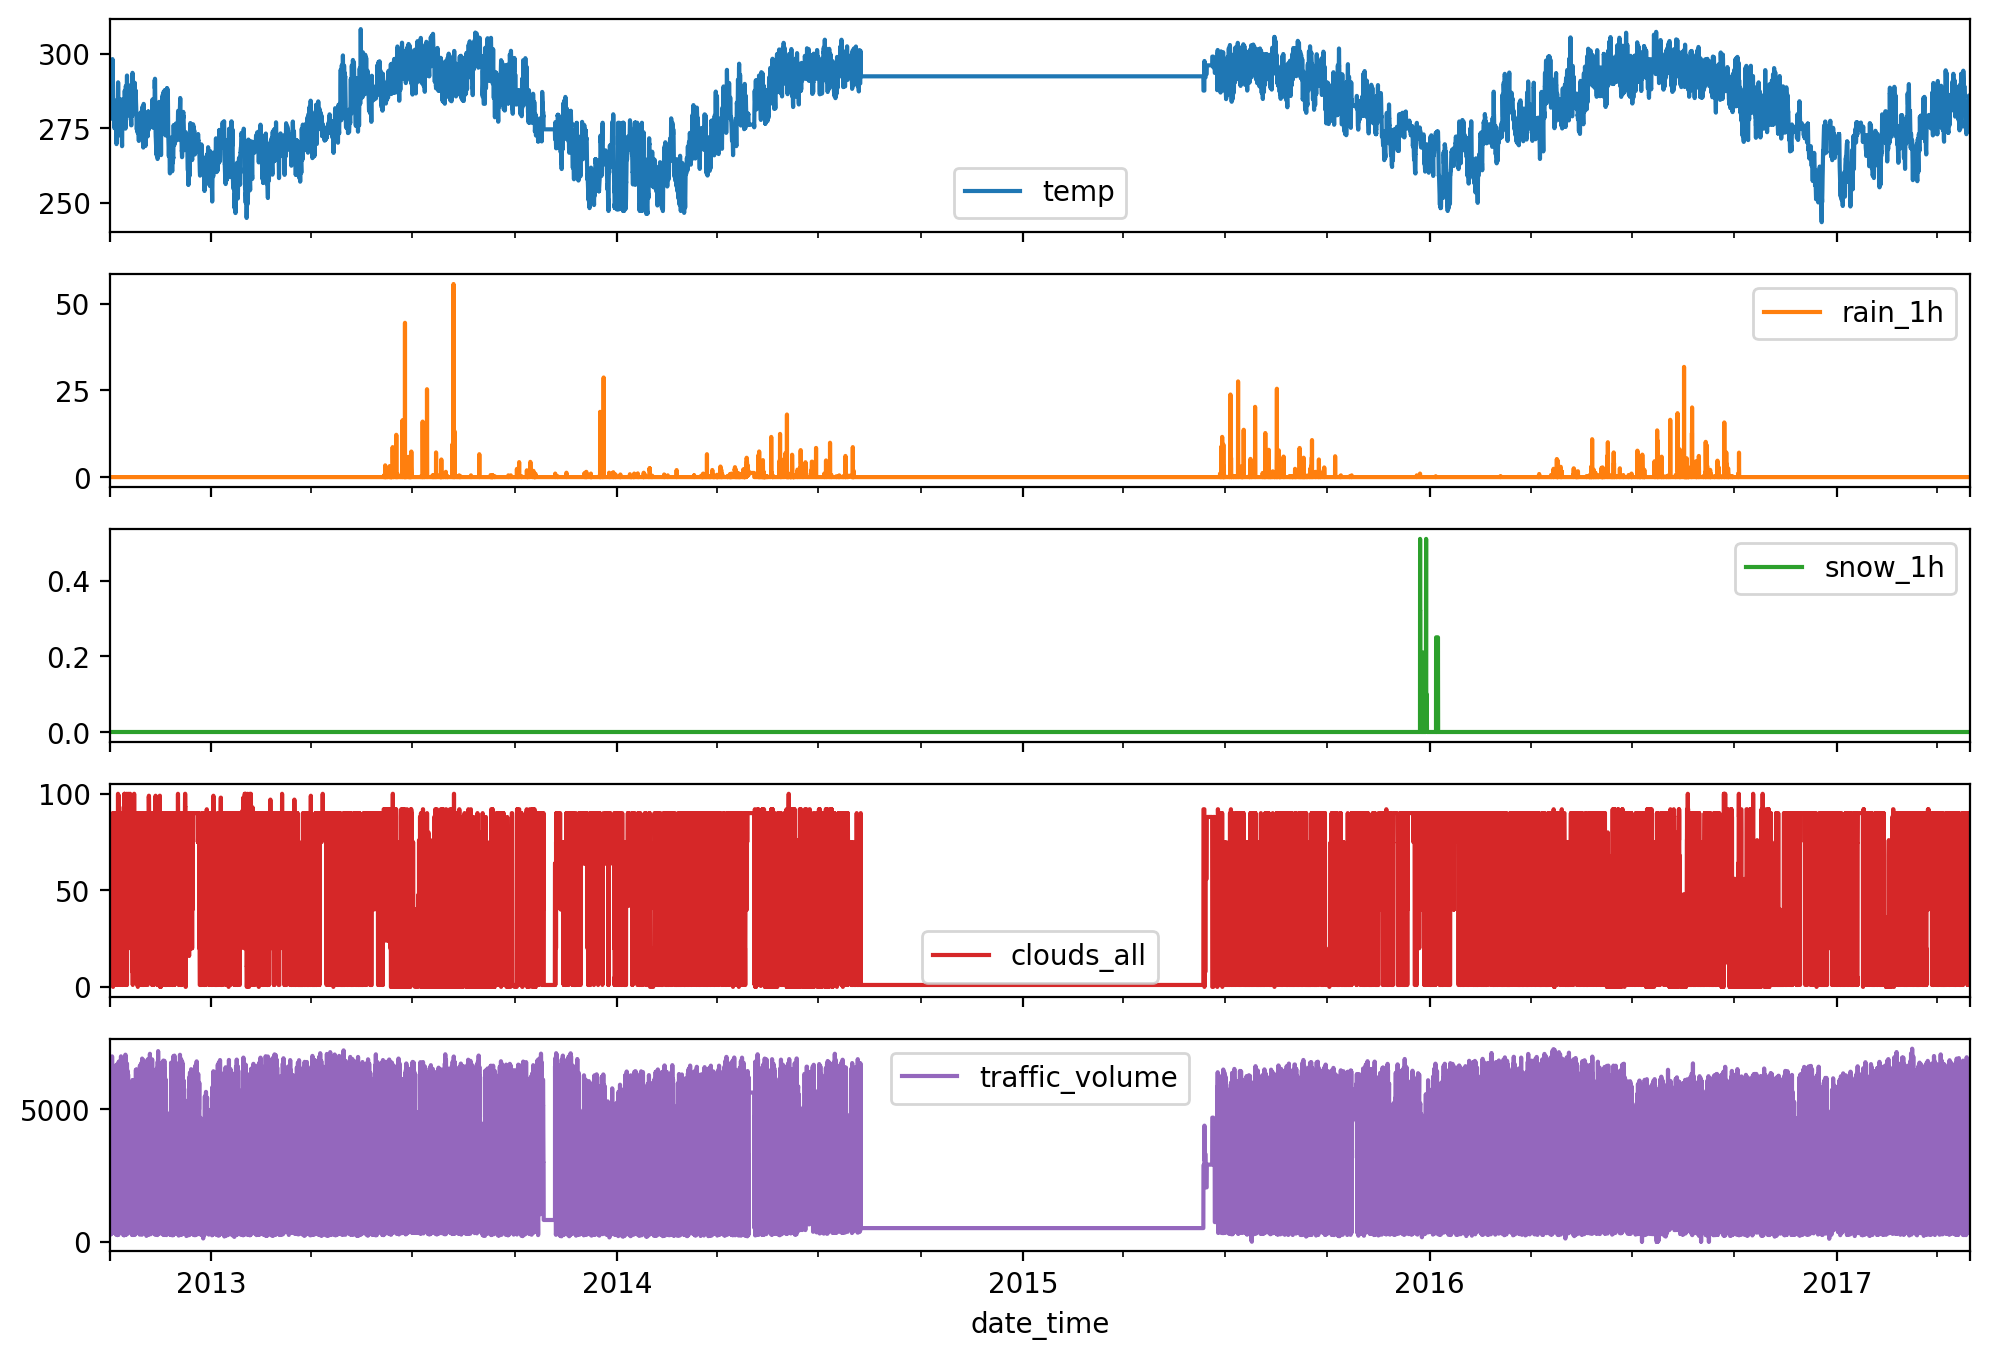

In [63]:
plot_features = train_df[plot_columns]
_ = plot_features.plot(subplots=True, figsize=(12,8))

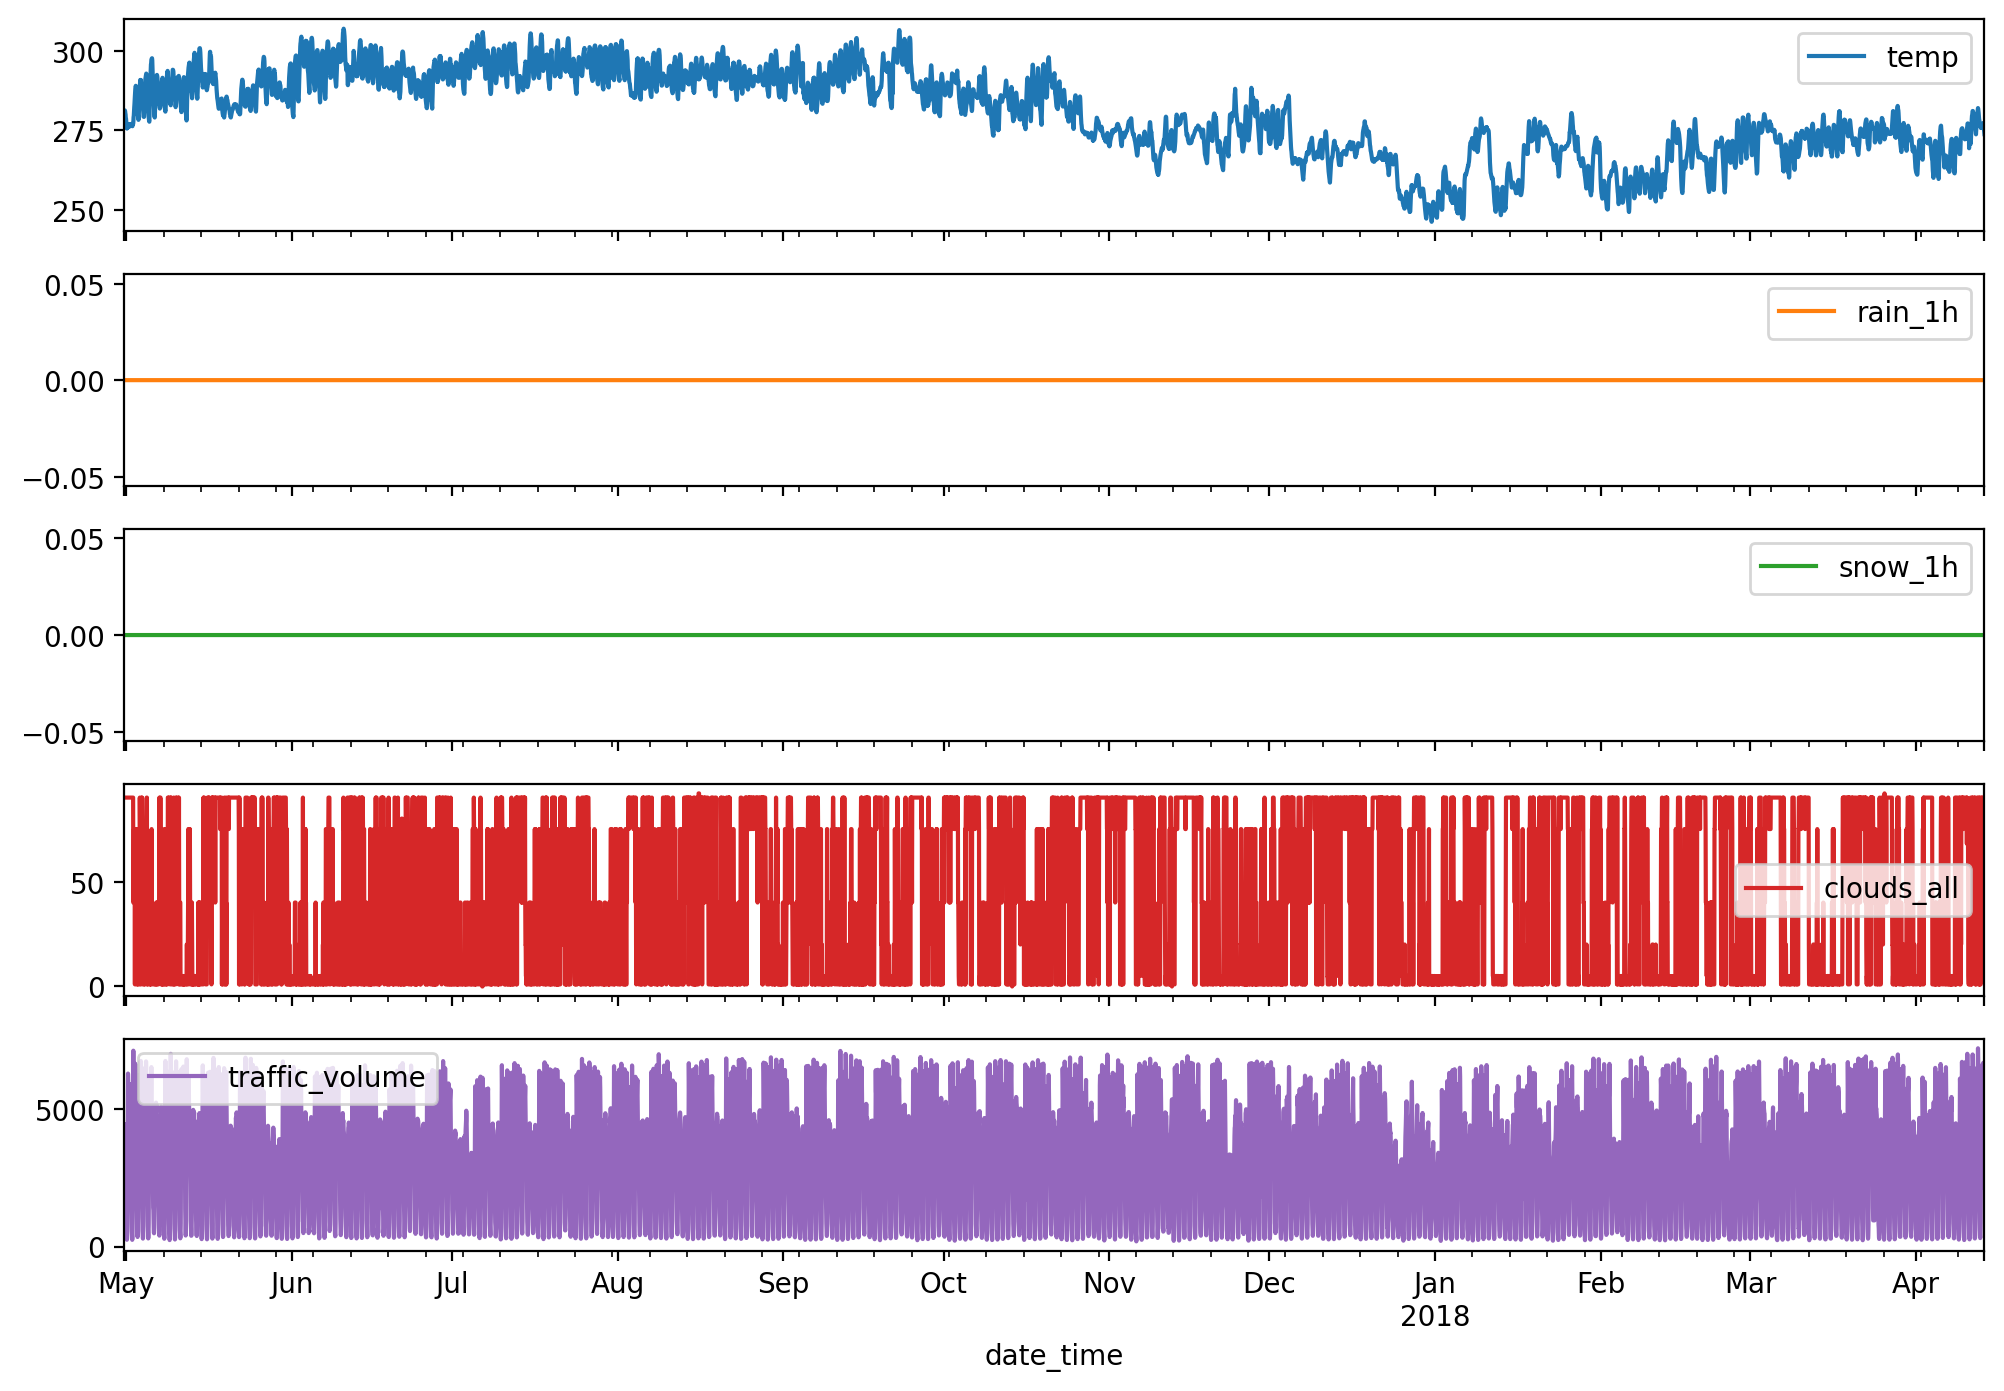

In [64]:
plot_features = val_df[plot_columns]
_ = plot_features.plot(subplots=True, figsize=(12,8))

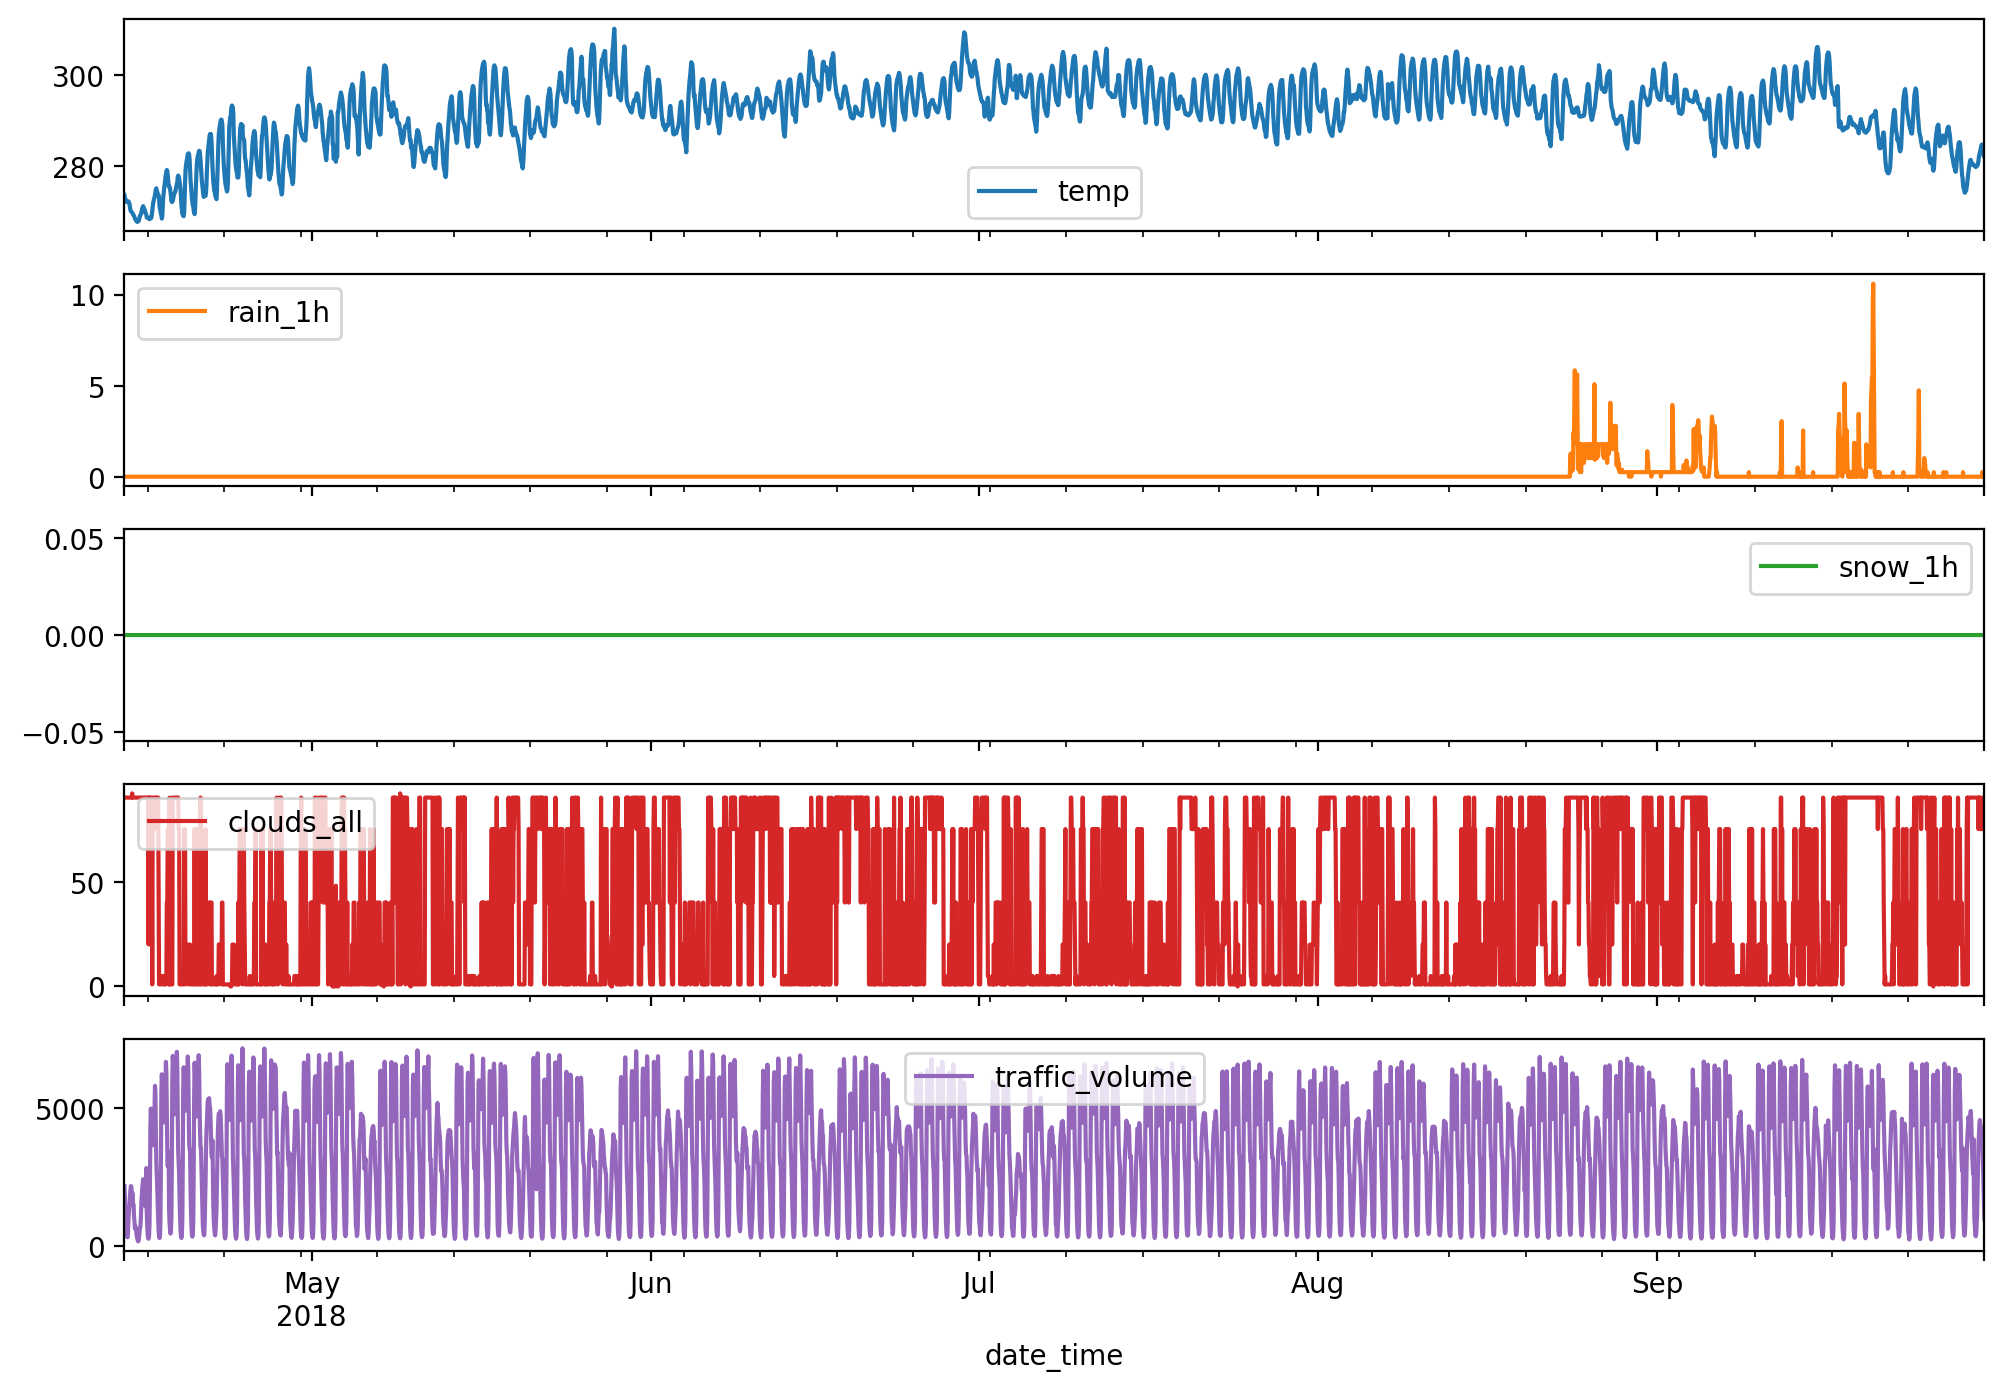

In [65]:
plot_features = test_df[plot_columns]
_ = plot_features.plot(subplots=True, figsize=(12,8))

### Normalize the data


In [66]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [67]:
my_scaler = MinMaxScaler().fit(train_df)
my_scaler_tv = MinMaxScaler().fit(train_df[['traffic_volume']])
scaled_train_df = pd.DataFrame(my_scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
scaled_val_df = pd.DataFrame(my_scaler.transform(val_df), index=val_df.index, columns=val_df.columns)
scaled_test_df = pd.DataFrame(my_scaler.transform(test_df), index=test_df.index, columns=test_df.columns)

#train_df.traffic_volume[0], scaled_train_df.traffic_volume[0], scaled_train_df.traffic_volume[0] / my_scaler.scale_[0]
#train_df.traffic_volume[0], scaled_train_df.traffic_volume[0], scaled_train_df.traffic_volume[0] * my_scaler.scale_[0] + my_scaler.mean_[0]

In [68]:
train_df.traffic_volume[0], scaled_train_df.traffic_volume[0],float(my_scaler_tv.inverse_transform(scaled_train_df[['traffic_volume']])[0])

(5545.0, 0.7616758241758241, 5545.0)

In [69]:
# Single value denormalization
float(my_scaler_tv.inverse_transform(np.array([[.7]])))

5096.0

In [70]:
my_scaler.__class__

sklearn.preprocessing._data.MinMaxScaler

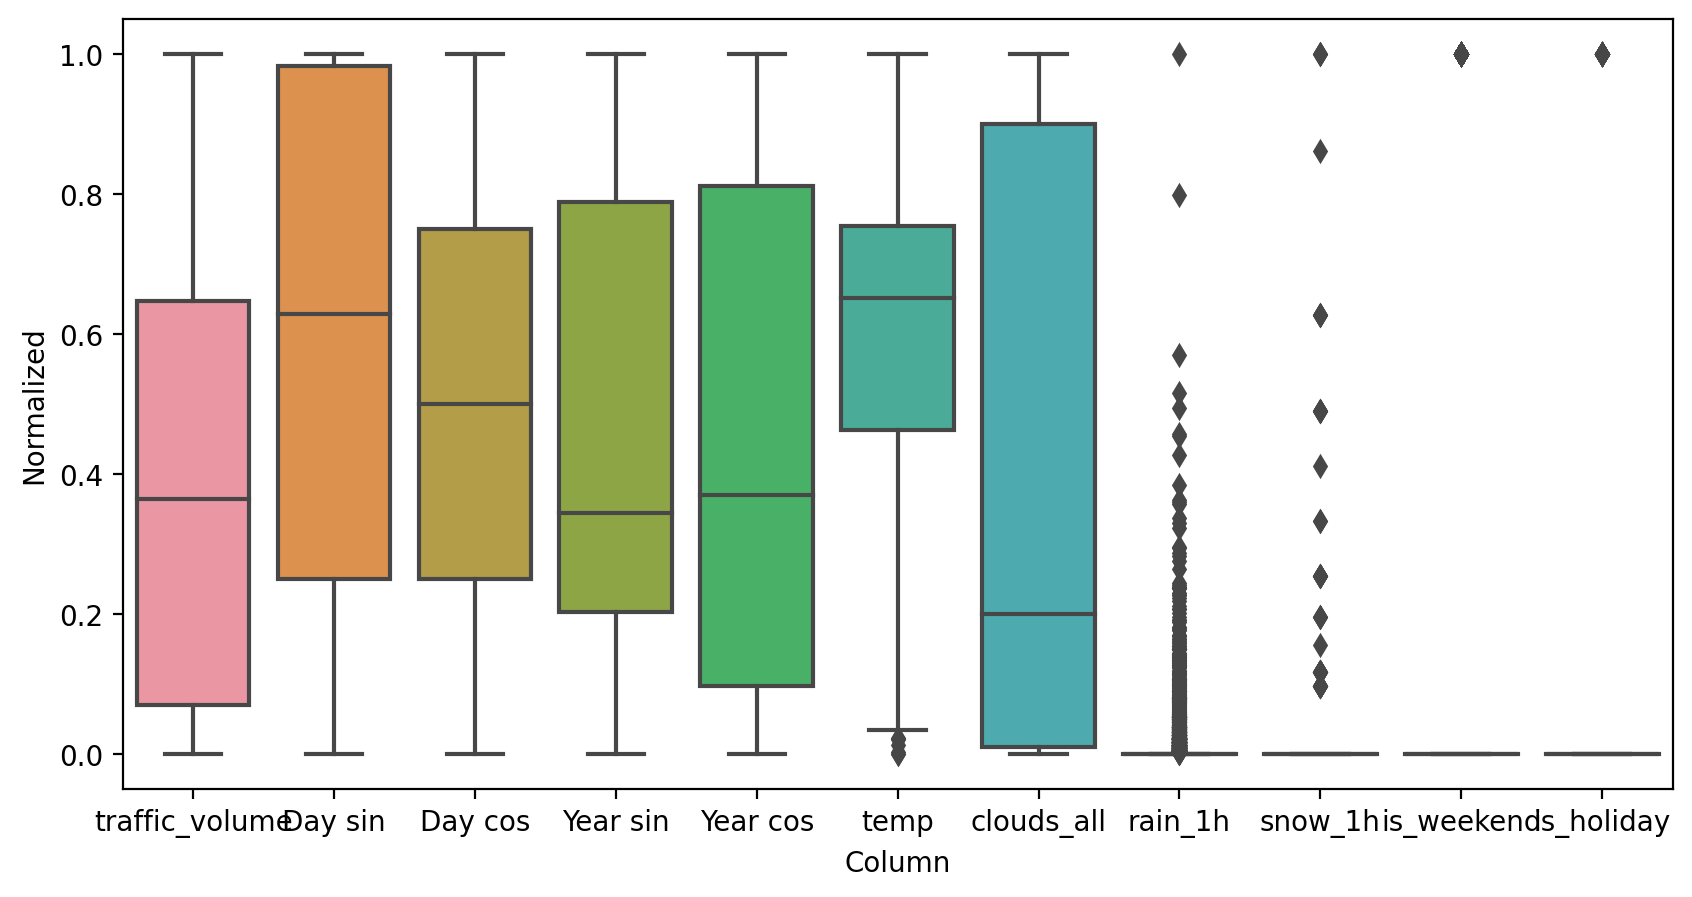

In [71]:
df_scaled = scaled_train_df.iloc[:,:11].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='Column', y='Normalized', data=df_scaled)


The data is showing rain and snow having alot of outliers. 

## Utility functions

In [72]:
# Special Characters for Output Formating
StartBold = "\033[1m"
EndBold = "\033[0m"

### WindowGenerator

In [73]:

class WindowGenerator():
  def __init__(self, input_width, label_width, shift, batch_size=32,
               train_df=scaled_train_df, val_df=scaled_val_df, test_df=scaled_test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.example = None

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    self.batch_size = batch_size

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size} = {self.input_width}+({self.shift-self.label_width}+{self.label_width})',
        f'Batch size: {self.batch_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices} start: [{self.label_start}]',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    '''
      Given a list consecutive inputs, the split_window method will convert
      them to a window of inputs and a window of labels.
    '''
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
    '''
      The plot method that allows a simple visualization of the split window
    '''
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')
    # Maskar: Added this line show that we are only showing n slices
    plt.suptitle(f'Showing only {max_n} slices')

  def make_dataset(self, data):
    '''
      Make_dataset method will take a time series DataFrame and convert it to
      a tf.data.Dataset of (input_window, label_window) pairs using the
      preprocessing.timeseries_dataset_from_array function.
    '''
    data = np.array(data, dtype=float)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False, # Maskar: I changed this to False
        batch_size=self.batch_size, # 32,
        )

    ds = ds.map(self.split_window)

    return ds

  # The WindowGenerator object holds training, validation and test data.
  # Add properties for accessing them as tf.data.Datasets using the above make_dataset method.
  # Also add a standard example batch for easy access and plotting:
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  @example.setter
  def example(self, var):
    self._example = var

### Plotting

In [74]:
def plot_train_validation(history, validation_data, metric='mean_absolute_error'):
  '''
    Function to plot the training and validation accuracy progress with epochs for a single model
  '''
  plt.plot(history.history[metric], label='train')  # For TF2
  plt.plot(history.history['val_'+metric], label='valid.')  # For TF2
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  #plt.xticks(range(1,len(history.history['loss'])+1,2))
  #plt.ylim([0.5, 1])
  plt.title(f'{len(history.history[metric])} epochs')
  plt.grid(color='lightgrey', linestyle=':', linewidth=0.5)
  plt.legend(loc='upper right')
  plt.show()

  # Evaluate the learned model with validation set
  print(f'\n\n{StartBold}Validation Scores:{EndBold}\n')
  _ = history.model.evaluate(validation_data, verbose=2)


In [75]:
class TrainingPlot(Callback):
    '''
      A keras callback helper function to plot
      the taining/validation plot after each epoch
    '''
    def __init__(self, loss_metric='mean_absolute_error'):
      super().__init__()
      self.loss_metric = loss_metric

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and metrics
        self.losses = []
        self.val_losses = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        loss = logs.get(self.loss_metric)
        val_loss = logs.get('val_'+self.loss_metric)
                
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(loss)
        self.val_losses.append(val_loss)
        
        # Plots every n-th epoch
        if epoch > 0 and epoch%1==0:
            
            # Clear the previous plot
            IPython.display.clear_output(wait=True)
            #clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            #plt.style.use("seaborn")            
            #plt.figure(figsize=(10,3))
            plt.xlabel('Epoch')
            plt.ylabel(self.loss_metric)
            plt.plot(N, self.losses, label='train')
            plt.plot(N, self.val_losses, label='valid.')
            plt.grid(color='lightgrey', linestyle=':', linewidth=0.5)
            val_denorm = float(my_scaler_tv.inverse_transform(np.array([[val_loss]])))
            plt.title(f'Last validation value = {val_denorm:.2f}')
            plt.legend(loc='upper right')          
            plt.show()

### Compile and fit

In [76]:
def compile_and_fit(model, window, patience=5, max_epochs=100,
                    model_label='model', log_dict=None):
  plot_metrics = TrainingPlot()

  rlr = ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.5,
      min_delta=0.001,
      patience=patience,
      mode='min',
      verbose=1
      )

  #mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      #min_delta=0.0001,
      patience=patience,
      mode='min',
      restore_best_weights=True
      )

  model.compile(
      optimizer=tf.optimizers.Adam(),
      loss=tf.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.MeanAbsoluteError()]
      )

  history = model.fit(
      window.train,
      #batch_size = window.batch_size,  # Maskar: added reference to the batch size
      epochs=max_epochs,
      validation_data=window.val,
      callbacks=[plot_metrics, early_stopping, rlr]
      )
  
  if log_dict:
    log_dict['my_models'][model_label] = model

    IPython.display.clear_output()

    print(f'\n\n{StartBold}Training vs. Validation:{EndBold}\n')
    plot_train_validation(history, window.val)

    log_dict['multi_val_performance'][model_label] = model.evaluate(window.val, verbose=0)
    log_dict['multi_performance'][model_label] = model.evaluate(window.train, verbose=0)


  predictions = model.predict(window.val)
  evaluate_predictions(val_df.traffic_volume, predictions)
  
  return history

### Evaluate predictions

In [77]:

def evaluate_predictions(y_true, y_pred, plot_start_index=-500):
    print(f'\n\n{StartBold}Predictions Evaluation:{EndBold}\n')
    
    # Reshape and inverse transform predictions for comparison
    y_p = np.asarray(my_scaler_tv.inverse_transform(y_pred.reshape(-1, 1))).ravel()
    
    # Ensure y_true matches the last n predictions for a fair comparison
    n_predictions = len(y_p)
    y = np.asarray(y_true[-n_predictions:]).ravel()
    
    # Check if the shapes match before calculating MAE
    if y.shape != y_p.shape:
        print(f"Shape mismatch: y_true shape {y.shape}, y_pred shape {y_p.shape}")
        return
    
    # Calculate MAE and display
    mae = float(tf.reduce_mean(tf.abs(y - y_p)))
    mae_scaled = float(my_scaler_tv.transform(np.array([[mae]])))
    
    print(f'MAE: {mae:.2f} ({mae_scaled:.4f})')
    
    # Plot comparison of true vs predicted values
    plt.figure(figsize=(15, 2))
    plt.plot(y[plot_start_index:], marker='.', label='true')
    plt.plot(y_p[plot_start_index:], marker='.', label='predicted')
    plt.legend()
    plt.show()


### Export for submission

In [78]:

def export_submission(y_pred, filename='submission.csv'):
  '''
    Function to export the prediction results for submission
  '''
  denorm_predictions = my_scaler_tv.inverse_transform(y_pred)
  df = pd.DataFrame(
      denorm_predictions,
      columns=['prediction'],
      index=pd.RangeIndex(1,len(y_pred)+1, name='id')
      )
  df.to_csv(filename)

In [79]:
def prepare_for_kaggle(predictions, df, kaggle_df, window_size=7):
  a = []
  n = len(kaggle_df) - window_size
  print('Required Predictions:\t', n)
  print('Clean Predictions:\t', predictions.shape[0])
  source_df = df[-predictions.shape[0]:]
  print('\nMissing Days in Kaggle DF due to records collapse:\n')
  for i,y in enumerate(kaggle_df[-n:].index):
    try:
      idx = source_df.index.get_loc(y)
      pred_tv = float(predictions[idx])
      a.append(pred_tv)
    except:
      pass
      print('\t',y)
      a.append(0)

  result = np.array(a)
  print('\nPrepared Predictions:\t',result.shape[0])
  return result.reshape(-1,1)

## The models


### The required window

Total window size: 8 = 6+(1+1)
Batch size: 32
Input indices: [0 1 2 3 4 5]
Label indices: [7] start: [7]
Label column name(s): ['traffic_volume']

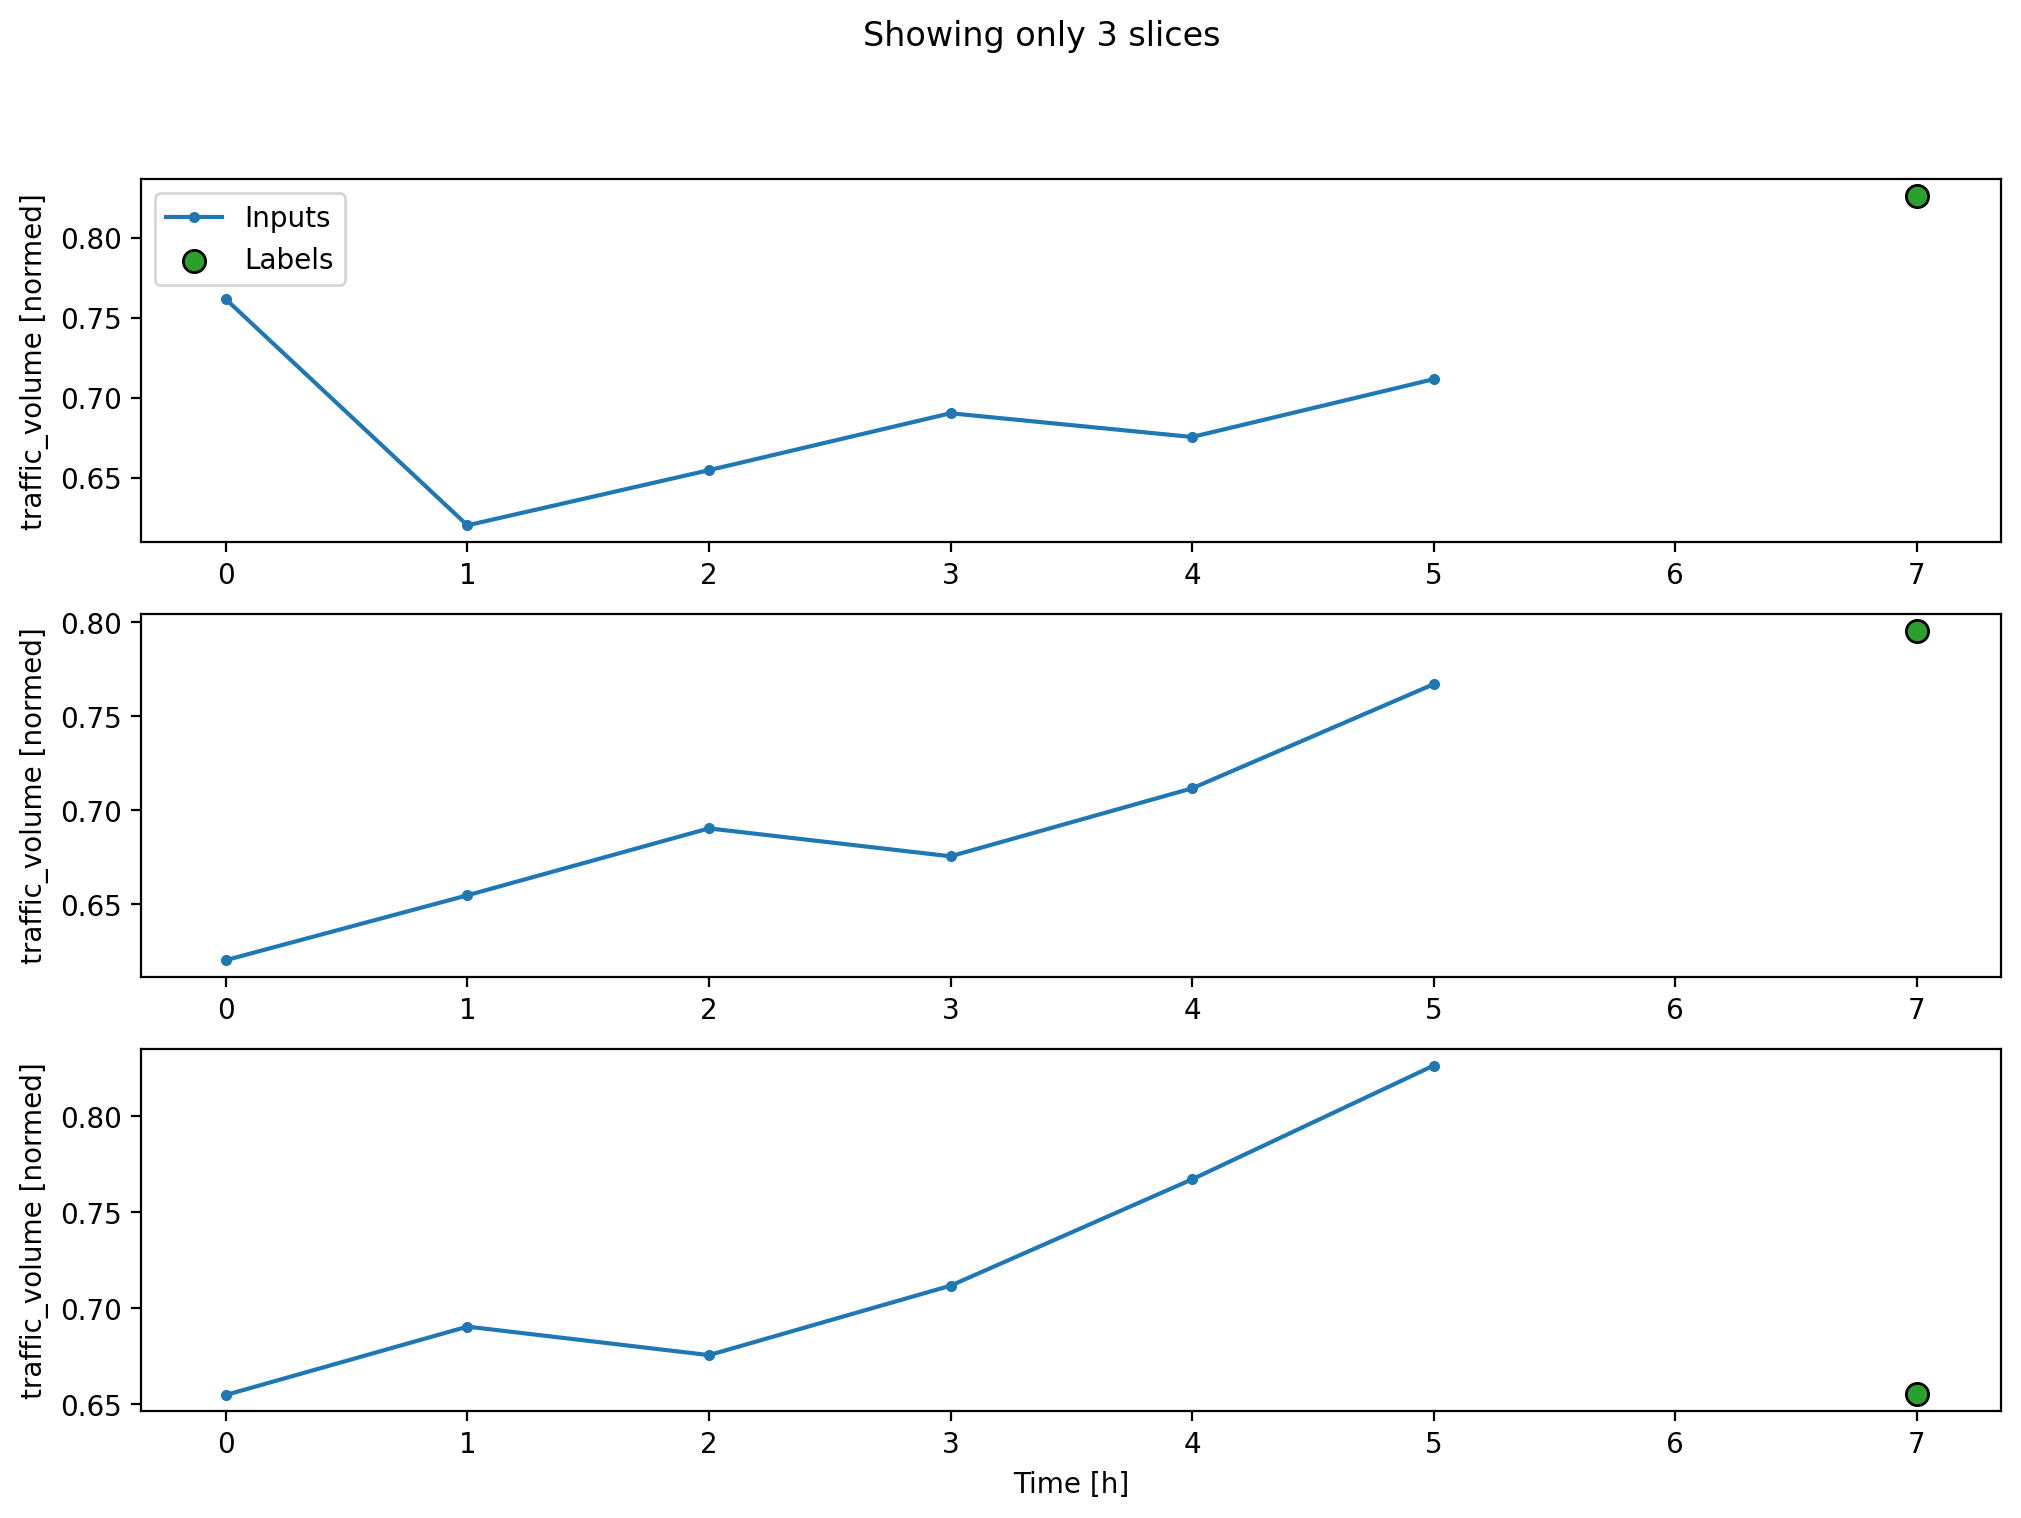

In [80]:
INPUT_WIDTH = 6
OUT_STEPS = 1
SHIFT = 2
base_window = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=SHIFT, label_columns=['traffic_volume'],
                               batch_size=32
                               )

base_window.plot()
base_window

### Baseline Models

In [81]:
multi_val_performance = {}
multi_performance = {}
my_models = {}

my_log = {
    'multi_val_performance':multi_val_performance,
    'multi_performance':multi_performance,
    'my_models':my_models
    }

I set all the models to converge into a single output value, which is the traffic volume at the 8th day based on 6 days input of the full features.

#### Dense

Using only `layers.Dense` between the input and output gives a decent linear model.



Training vs. Validation:



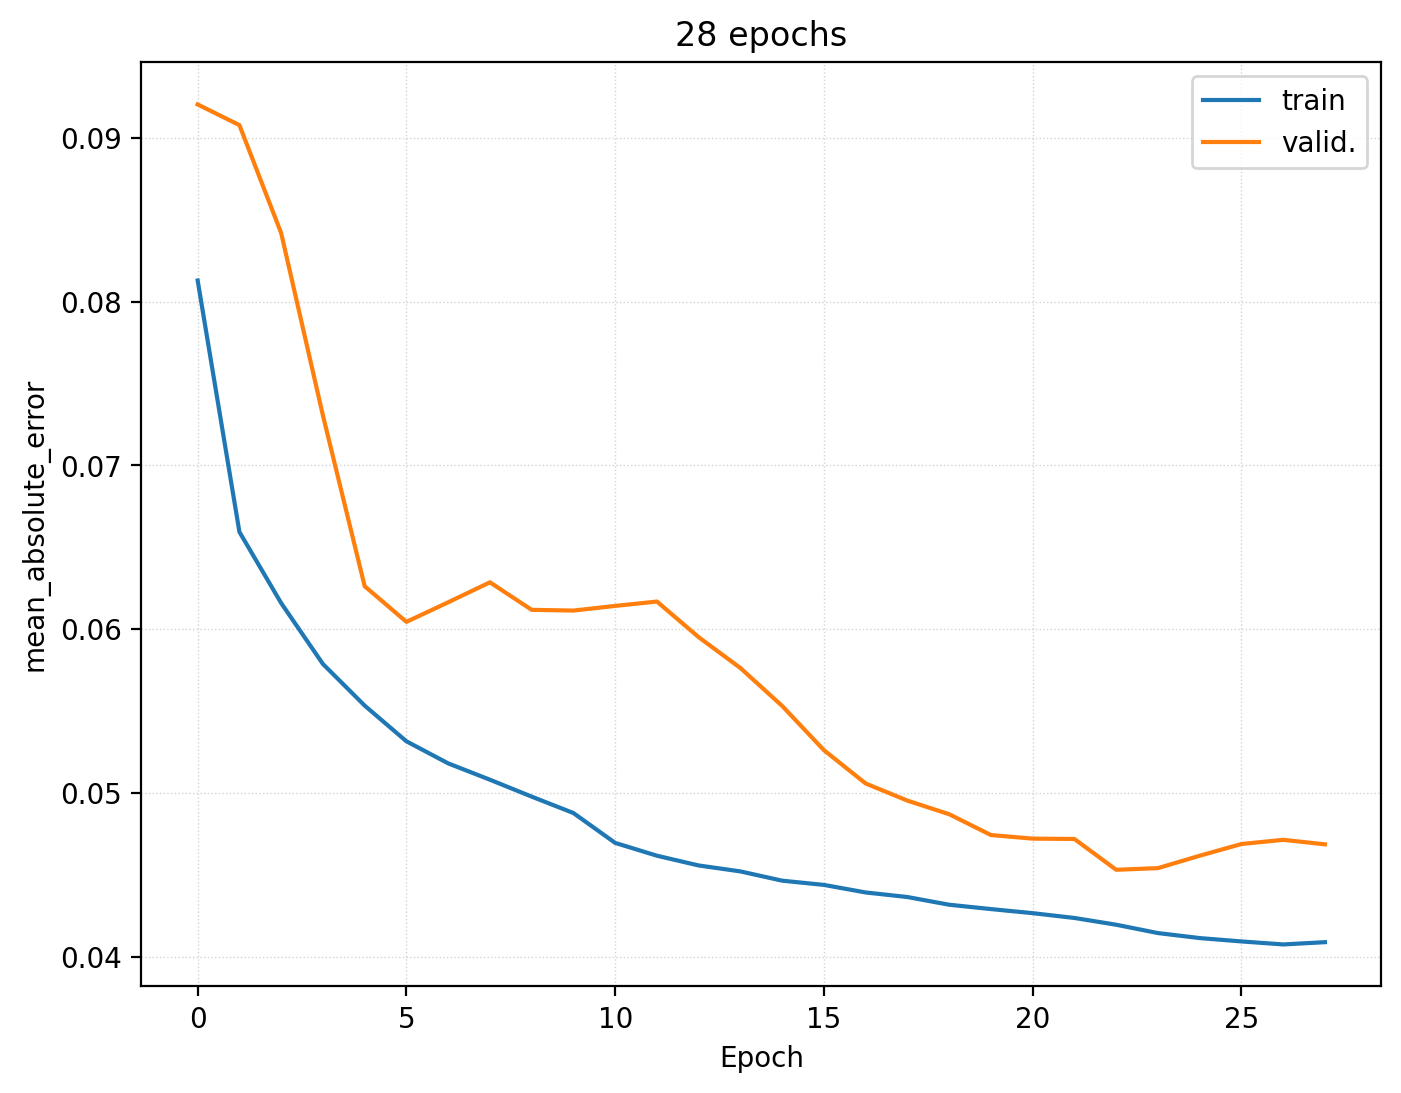



Validation Scores:

261/261 - 0s - loss: 0.0041 - mean_absolute_error: 0.0453 - 250ms/epoch - 959us/step
261/261 [==============================] - 0s 633us/step


Predictions Evaluation:

MAE: 329.88 (0.0453)


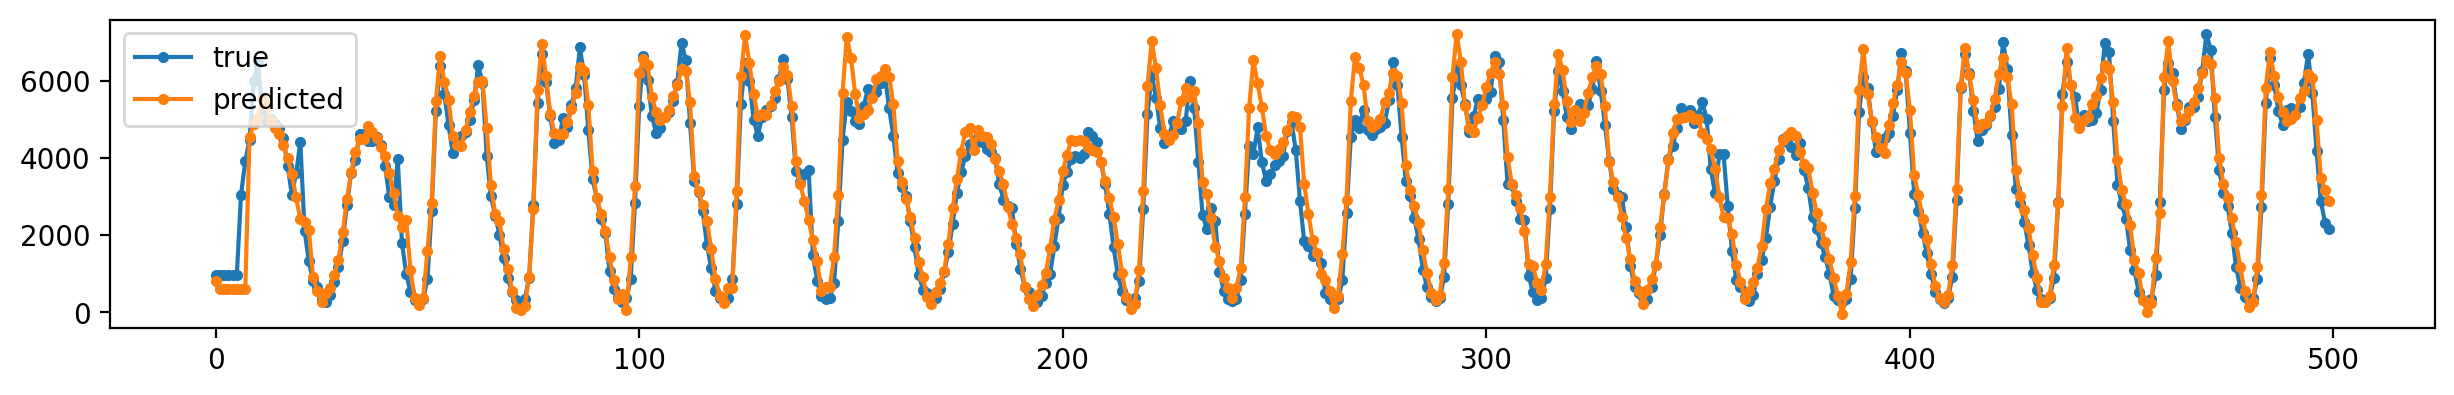

CPU times: user 1min 53s, sys: 51.5 s, total: 2min 44s
Wall time: 45.4 s


In [82]:

model_label = 'Dense '
current_window = base_window

dense_model = tf.keras.Sequential([
    Lambda(lambda x: x[:, -1:, :]),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(dense_model, current_window,
                          model_label=model_label, log_dict=my_log)

#### CNN



Training vs. Validation:



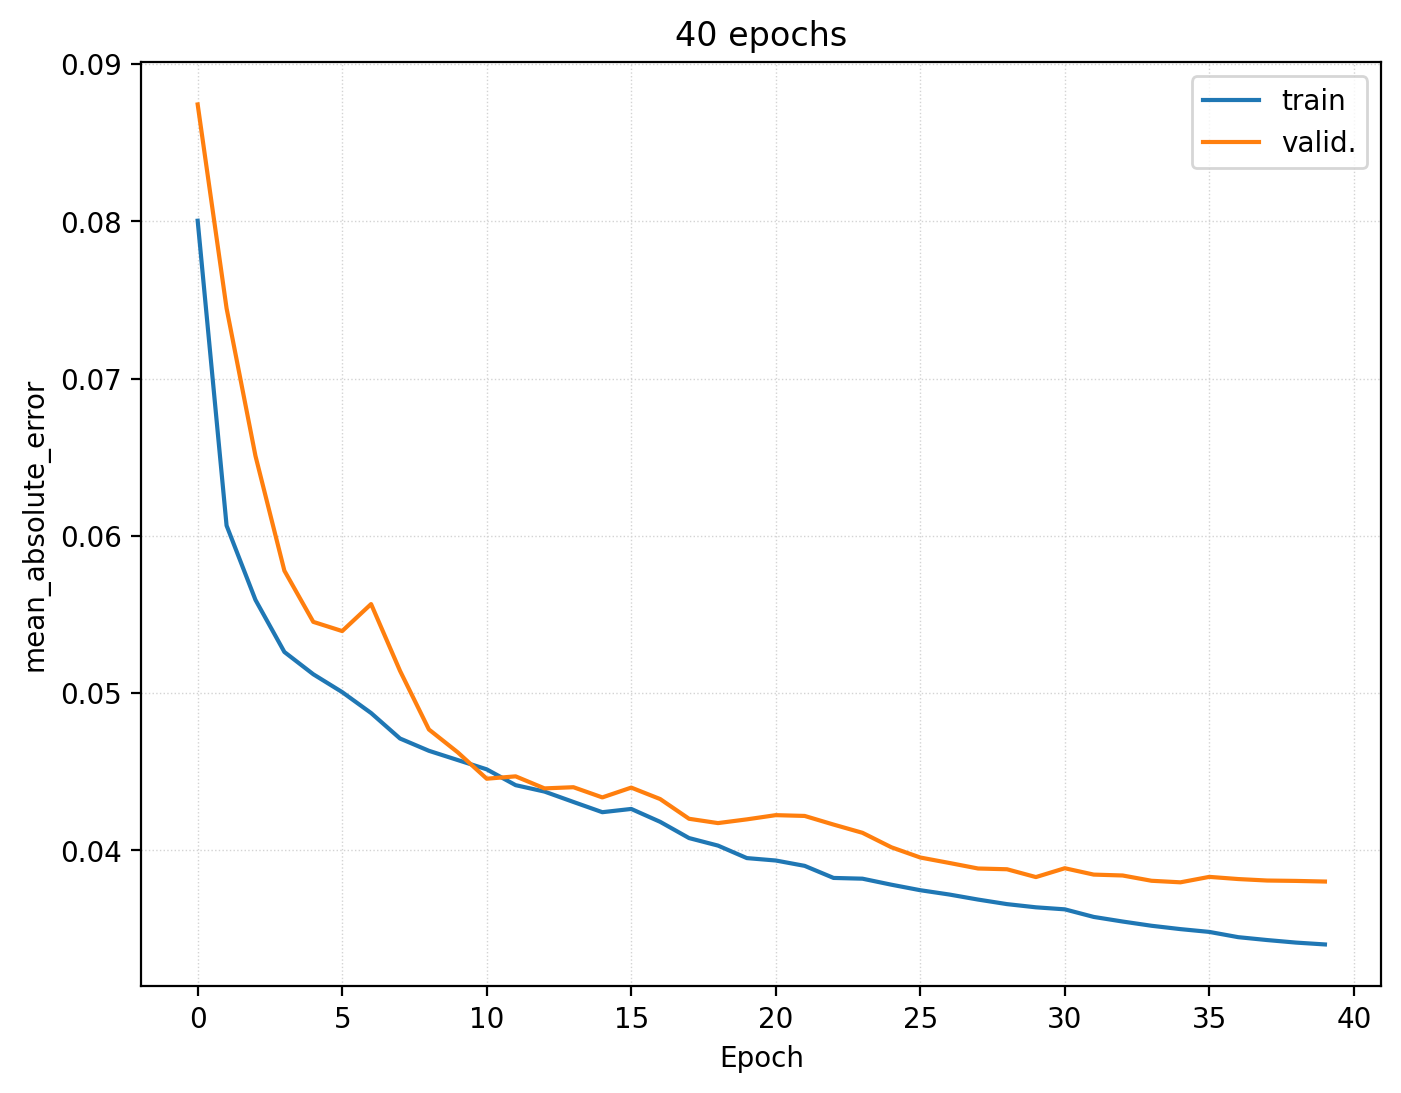



Validation Scores:

261/261 - 0s - loss: 0.0034 - mean_absolute_error: 0.0380 - 280ms/epoch - 1ms/step
261/261 [==============================] - 0s 916us/step


Predictions Evaluation:

MAE: 276.46 (0.0380)


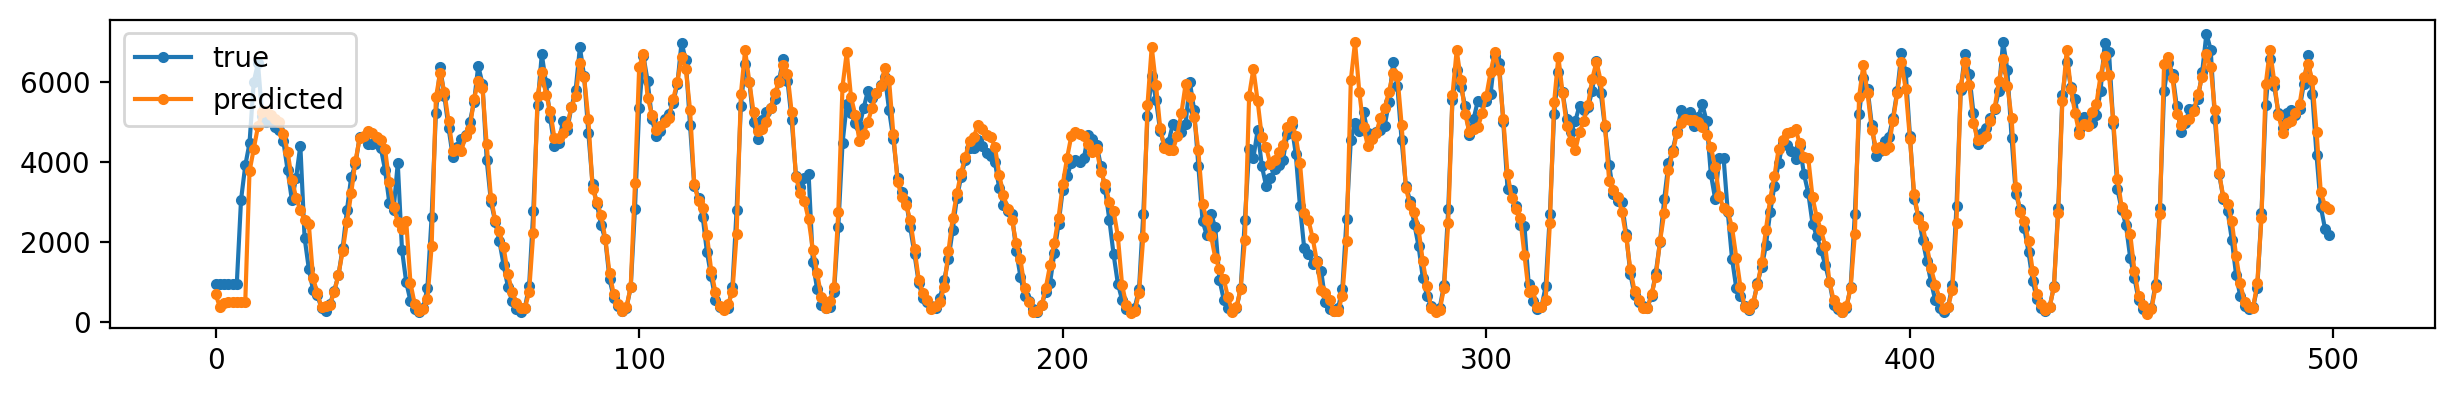

CPU times: user 4min 4s, sys: 1min 56s, total: 6min 1s
Wall time: 1min 58s


In [83]:

model_label = 'Conv'
current_window = base_window

CONV_WIDTH = 3
conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS)
])

history = compile_and_fit(conv_model, current_window,
                          model_label=model_label, log_dict=my_log)

#### RNN



Training vs. Validation:



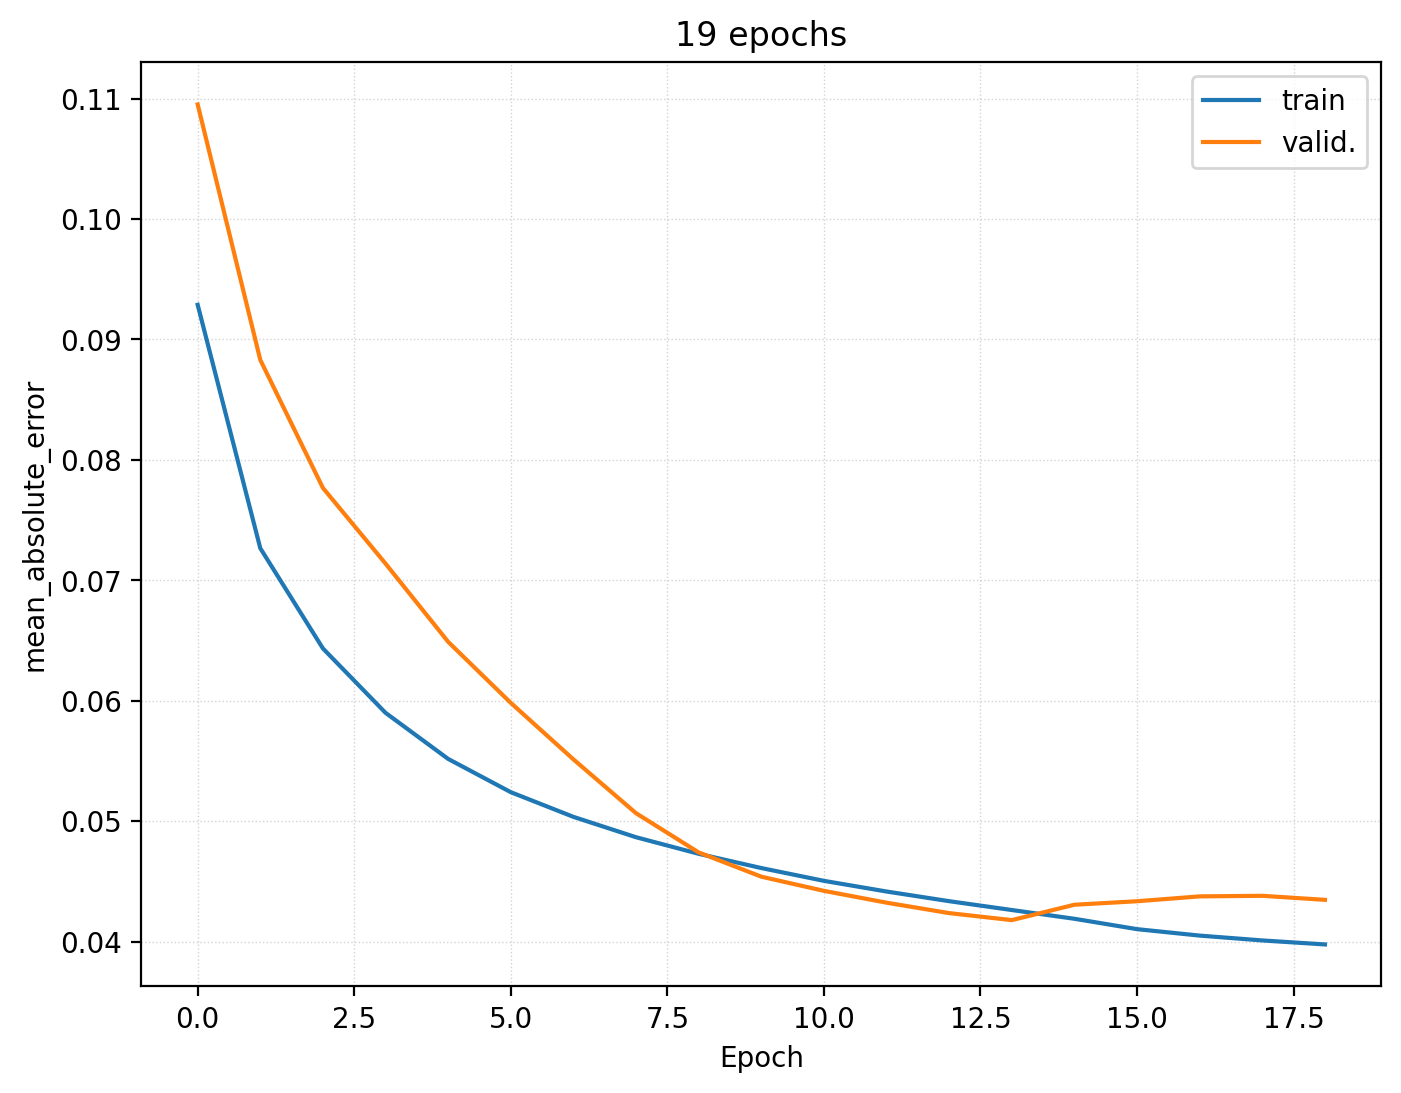



Validation Scores:

261/261 - 0s - loss: 0.0036 - mean_absolute_error: 0.0418 - 268ms/epoch - 1ms/step
261/261 [==============================] - 0s 883us/step


Predictions Evaluation:

MAE: 304.22 (0.0418)


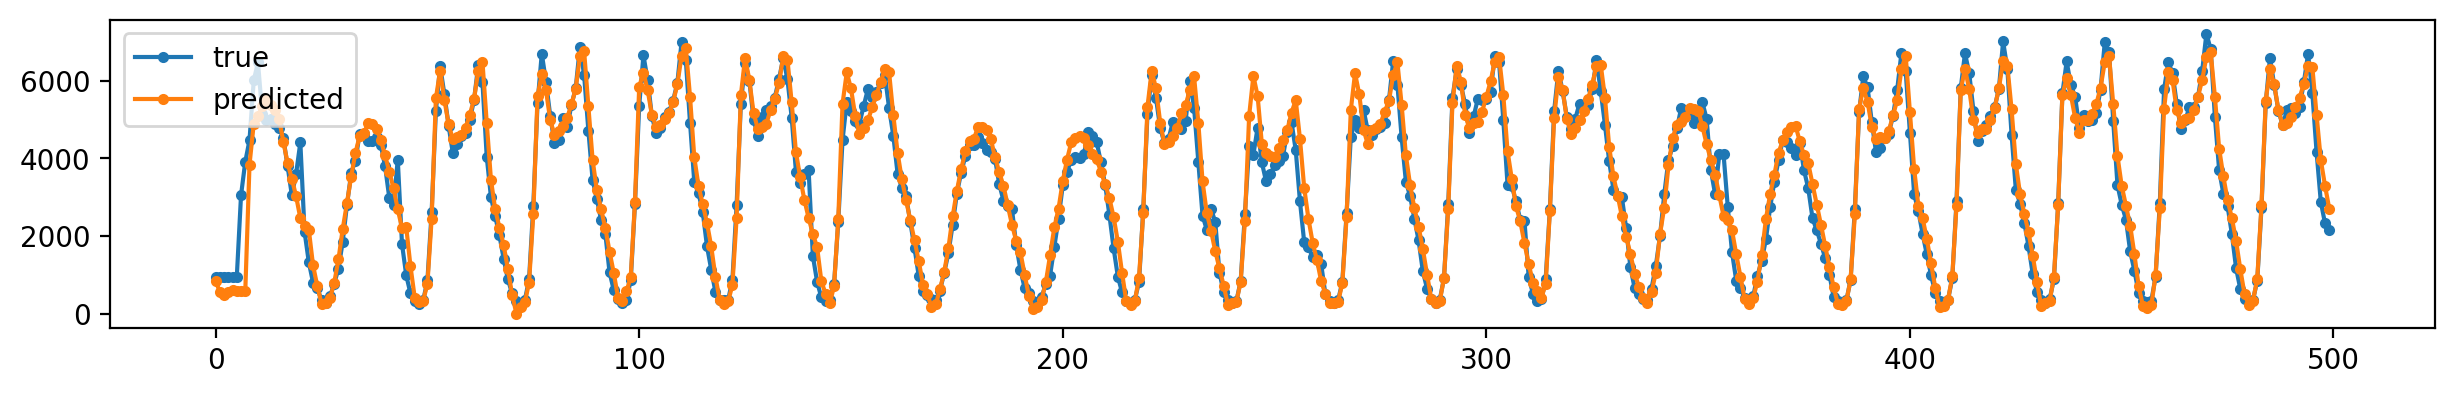

CPU times: user 1min 45s, sys: 39.2 s, total: 2min 24s
Wall time: 51.6 s


In [84]:
%%time
model_label = 'LSTM'
current_window = base_window

lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    LSTM(32, return_sequences=False),
    Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    Dense(OUT_STEPS)
])

history = compile_and_fit(lstm_model, current_window,
                          model_label=model_label, log_dict=my_log)



Training vs. Validation:



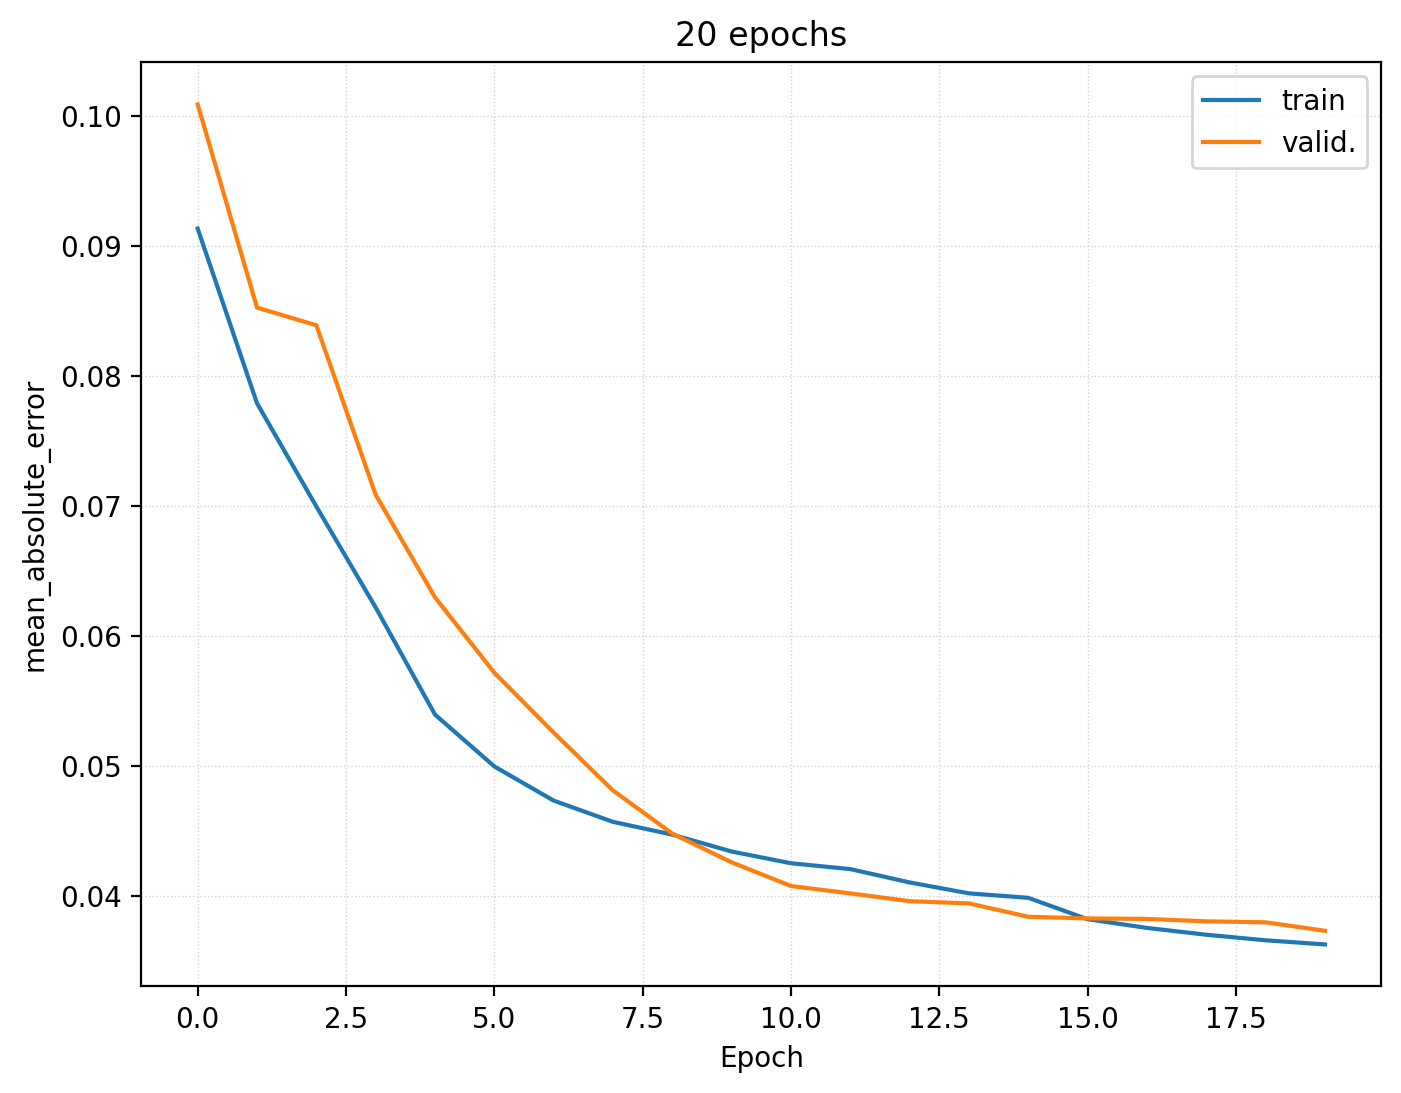



Validation Scores:

261/261 - 2s - loss: 0.0033 - mean_absolute_error: 0.0384 - 2s/epoch - 6ms/step
 18/261 [=>............................] - ETA: 1s

2024-12-01 09:32:10.358603: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


261/261 [==============================] - 2s 5ms/step


Predictions Evaluation:

MAE: 279.59 (0.0384)


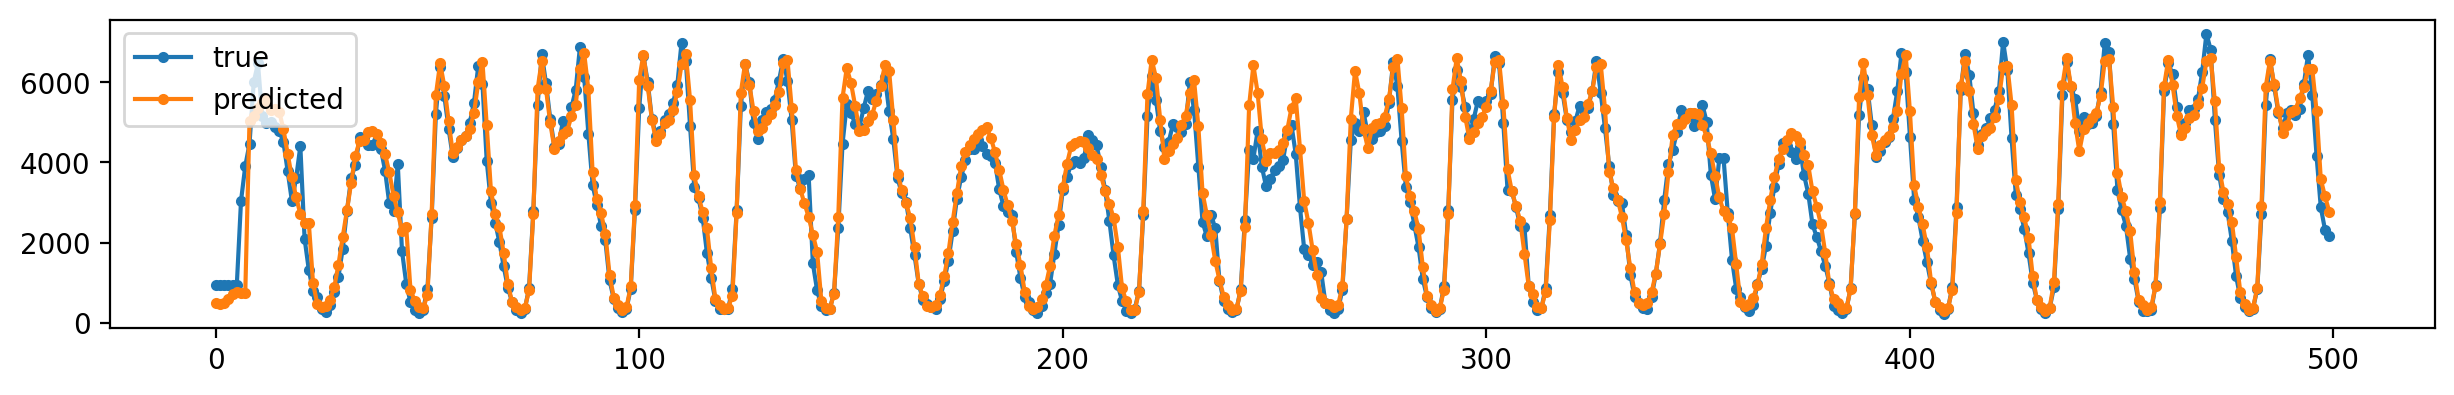

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6, 27)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 6, 256)               290816    ['input_1[0][0]']             
                                                                                                  
 attention (Attention)       (None, 6, 256)               0         ['lstm_1[0][0]',              
                                                                     'lstm_1[0][0]']              
                                                                                                  
 lstm_2 (LSTM)               (None, 128)                  197120    ['attention[0][0]']       

In [85]:
from tensorflow.keras.layers import Attention, Input
from tensorflow.keras.models import Model

# Define the Attention LSTM model
model_label = 'AttentionLSTM'
current_window = base_window

# Input layer
inputs = Input(shape=(current_window.input_width, current_window.train_df.shape[-1]))

# First LSTM layer, return sequences to feed into Attention
lstm_out = LSTM(256, return_sequences=True)(inputs)

# Add an Attention layer to help the model focus on important timesteps
attention_out = Attention()([lstm_out, lstm_out])

# Output LSTM layer to process after Attention
lstm_out_2 = LSTM(128, return_sequences=False)(attention_out)

# Dense layers for prediction
dense_1 = Dense(512, activation='relu')(lstm_out_2)
outputs = Dense(OUT_STEPS)(dense_1)

# Create the model
attention_lstm_model = Model(inputs=inputs, outputs=outputs)

# Compile and fit the model
history = compile_and_fit(attention_lstm_model, current_window,
                          model_label=model_label, log_dict=my_log)

# Summarize the model
attention_lstm_model.summary()




Training vs. Validation:



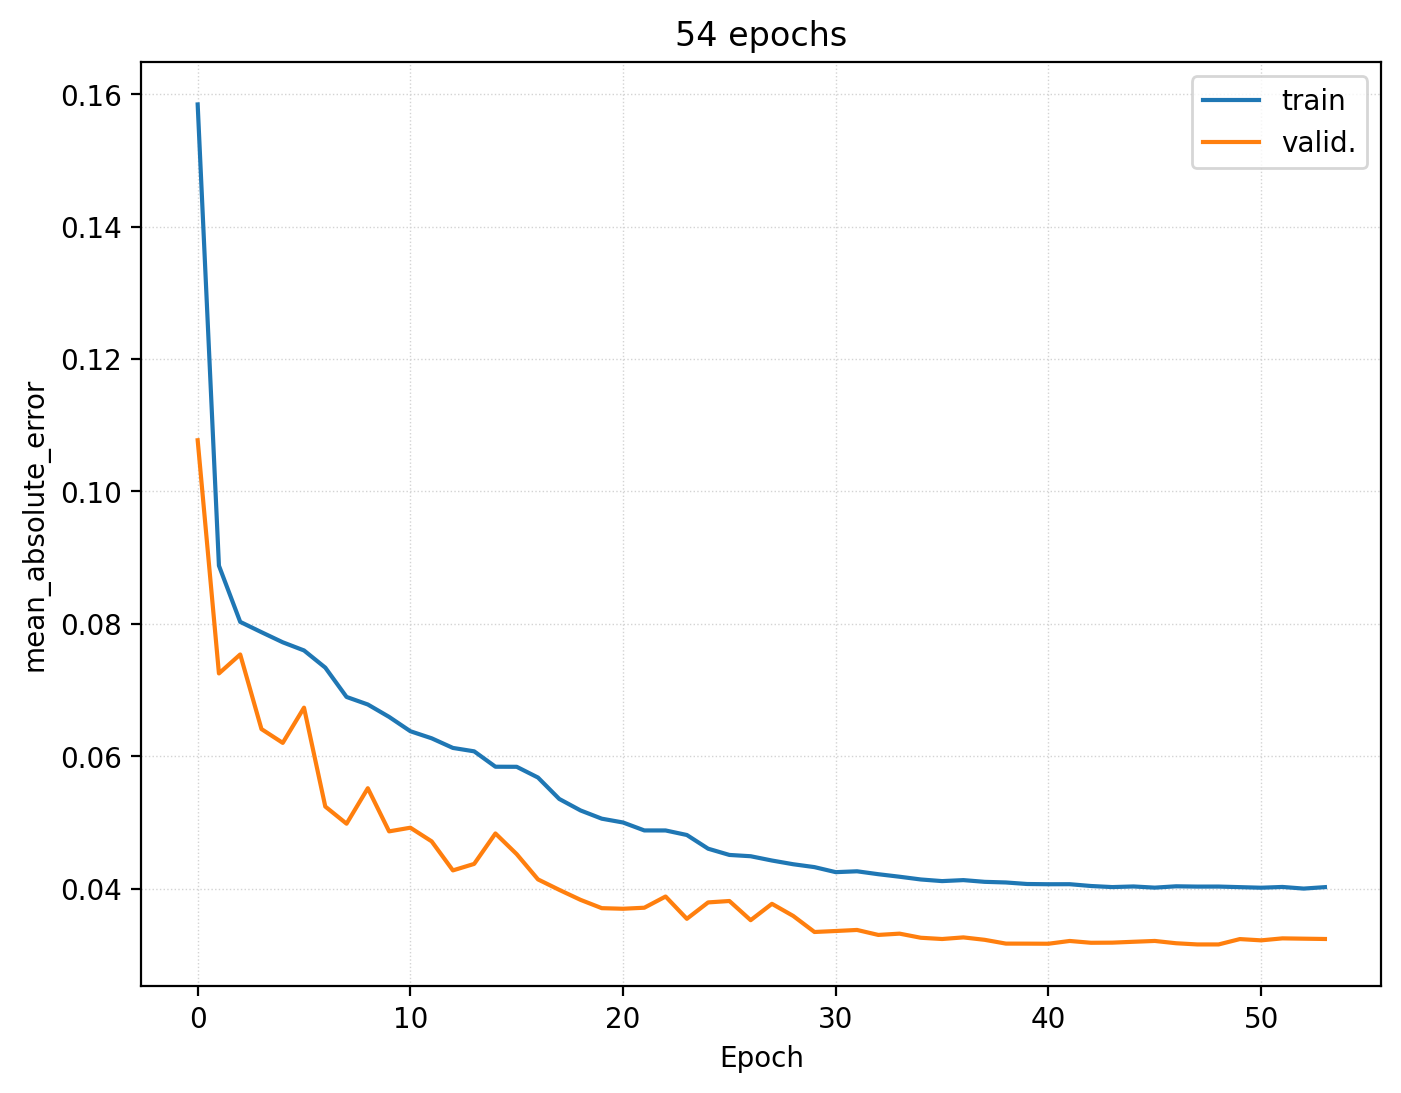



Validation Scores:

261/261 - 2s - loss: 0.0023 - mean_absolute_error: 0.0316 - 2s/epoch - 9ms/step
  8/261 [..............................] - ETA: 2s  

2024-12-01 10:09:42.475415: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


261/261 [==============================] - 3s 8ms/step


Predictions Evaluation:

MAE: 229.92 (0.0316)


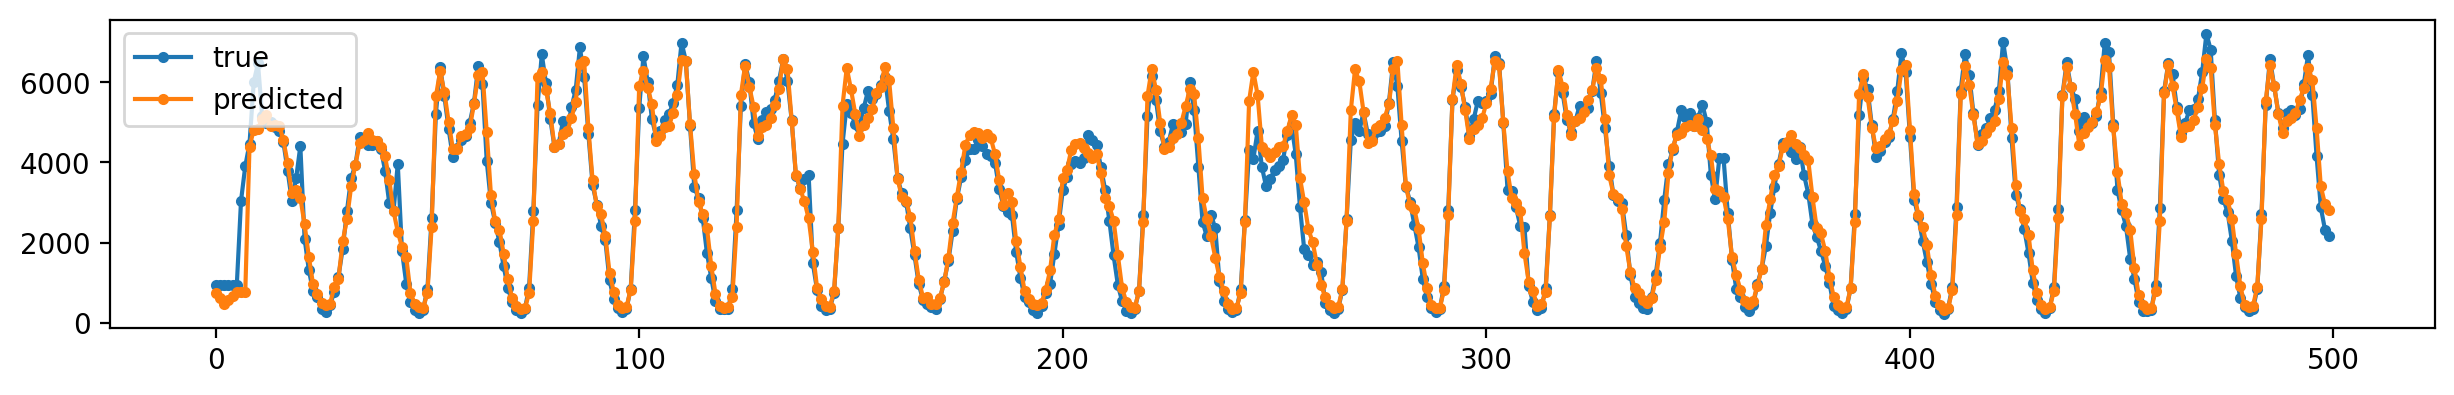

In [86]:
from tensorflow.keras.layers import Attention, LayerNormalization, Dropout, LSTM, Dense, Input, Bidirectional
from tensorflow.keras.models import Model

# Define the improved Attention BiLSTM model
model_label = 'Improved_Attention_BiLSTM'
current_window = base_window  # Assuming this is the window generator instance you defined

# Input layer
inputs = Input(shape=(current_window.input_width, current_window.train_df.shape[-1]))

# First Bidirectional LSTM layer with Layer Normalization
lstm_out = Bidirectional(LSTM(256, return_sequences=True))(inputs)
lstm_out = LayerNormalization()(lstm_out)
lstm_out = Dropout(0.3)(lstm_out)

# Attention layer to focus on important time steps
attention_out = Attention()([lstm_out, lstm_out])

# Second LSTM layer after Attention
lstm_out_2 = Bidirectional(LSTM(128, return_sequences=False))(attention_out)
lstm_out_2 = LayerNormalization()(lstm_out_2)
lstm_out_2 = Dropout(0.3)(lstm_out_2)

# Dense layers for prediction
dense_1 = Dense(512, activation='relu')(lstm_out_2)
dense_1 = Dropout(0.3)(dense_1)  # Adding dropout for regularization
outputs = Dense(OUT_STEPS)(dense_1)

# Create the model
improved_model = Model(inputs=inputs, outputs=outputs)

# Compile and fit the model
history = compile_and_fit(improved_model, current_window,
                          model_label=model_label, log_dict=my_log)




Training vs. Validation:



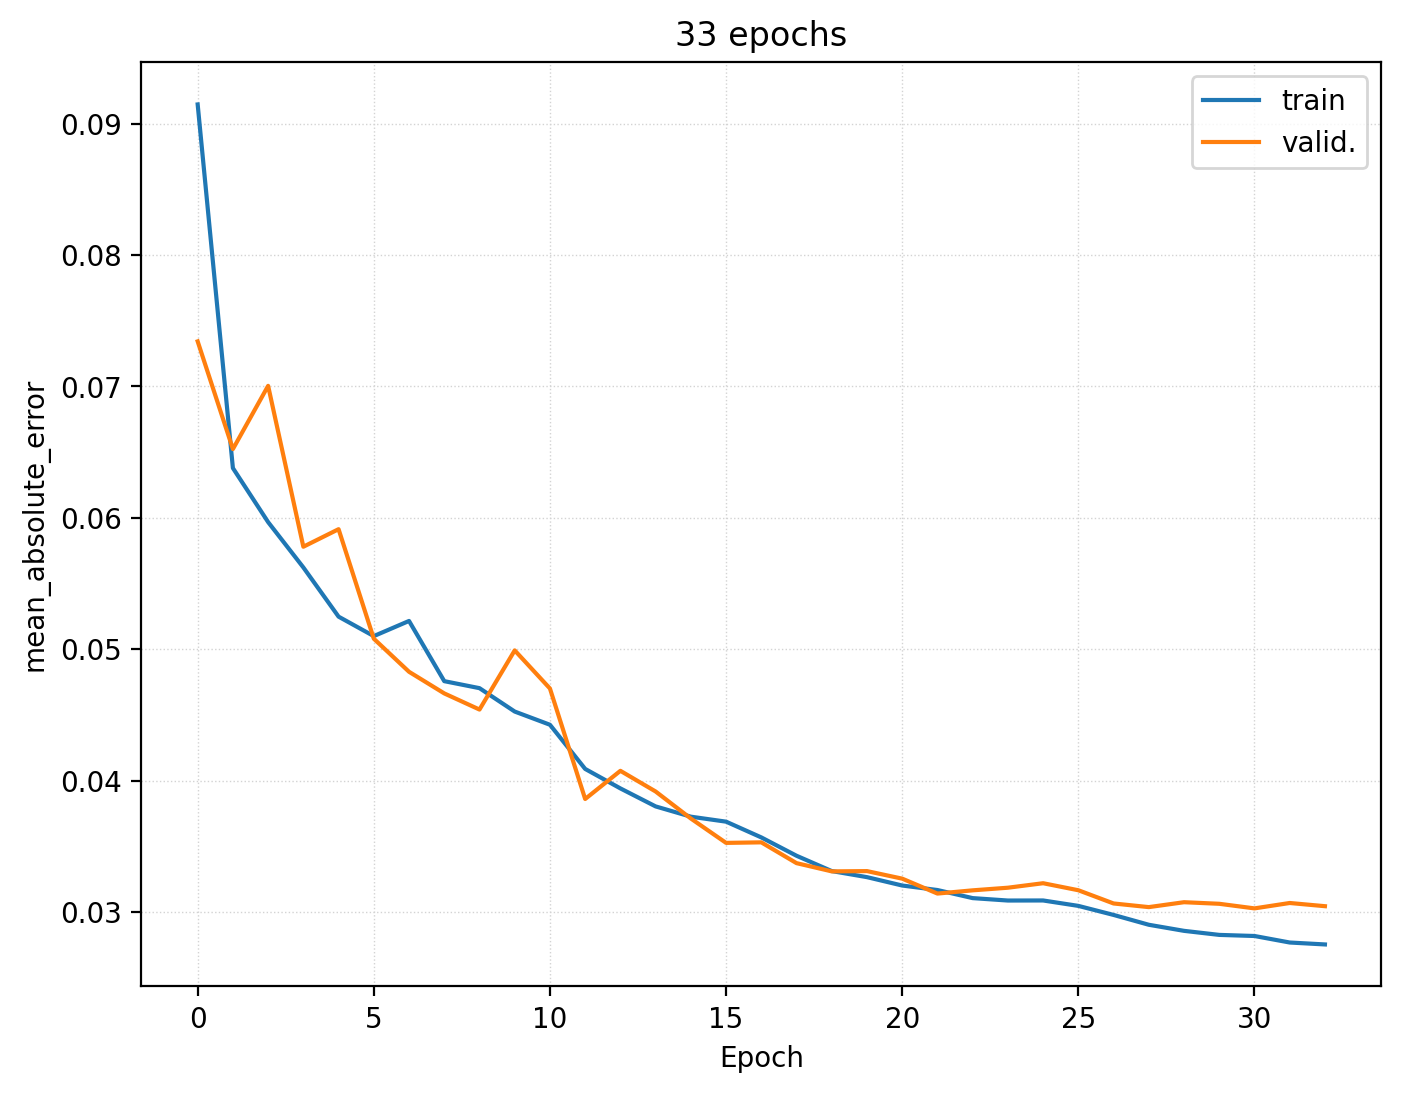



Validation Scores:

261/261 - 12s - loss: 0.0021 - mean_absolute_error: 0.0304 - 12s/epoch - 44ms/step


2024-12-01 12:38:25.011985: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2024-12-01 12:38:25.012663: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 5

261/261 [==============================] - 14s 48ms/step


Predictions Evaluation:

MAE: 221.08 (0.0304)


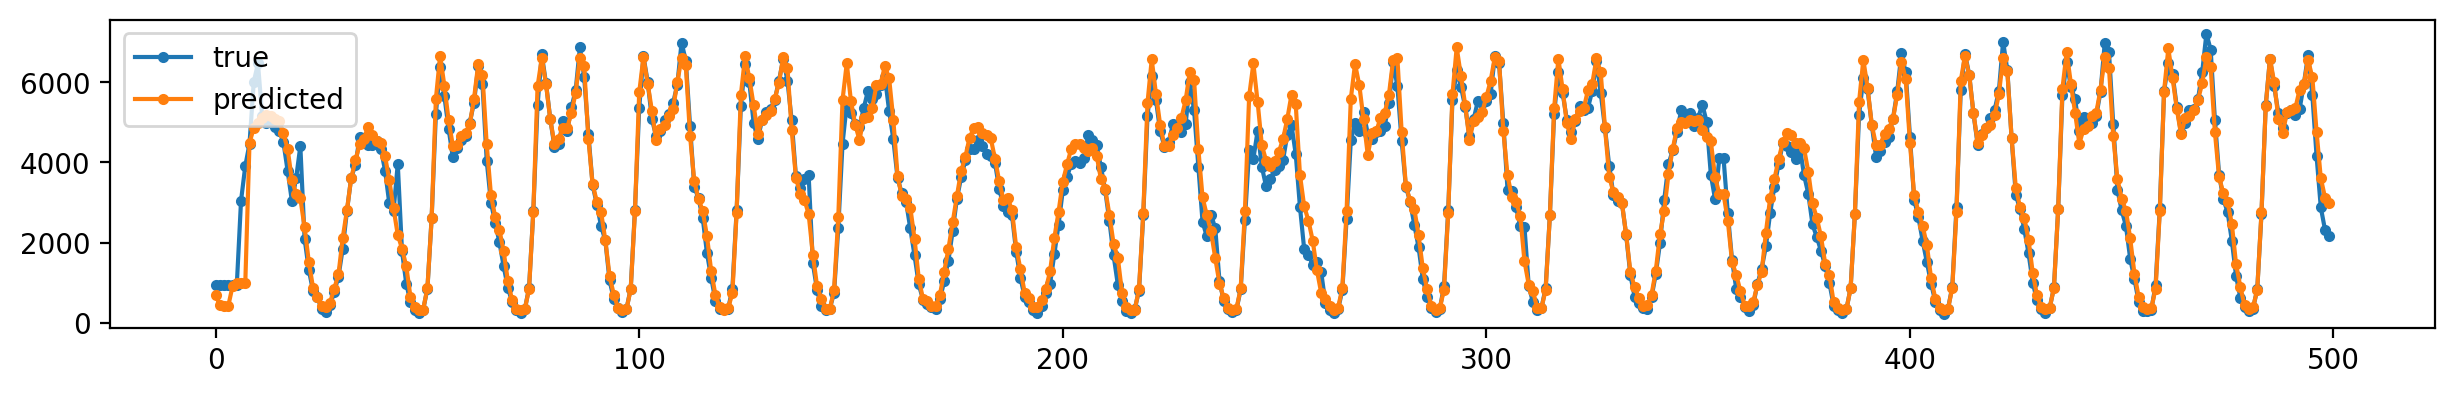

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 6, 27)]              0         []                            
                                                                                                  
 dense_10 (Dense)            (None, 6, 1024)              28672     ['input_3[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 6, 1024)              2211840   ['input_3[0][0]']             
 onal)                                                                                            
                                                                                                  
 add (Add)                   (None, 6, 1024)              0         ['dense_10[0][0]',      

In [87]:
from tensorflow.keras.layers import Add, LayerNormalization, Dense

model_label = 'Enhanced_Attention_BiLSTM'
current_window = base_window

# Input layer
inputs = Input(shape=(current_window.input_width, current_window.train_df.shape[-1]))

# Adjust the shape of `inputs` to match `bilstm_out1` with a Dense layer
adjusted_inputs = Dense(1024)(inputs)

# Initial Bidirectional LSTM layers with residual connections
bilstm_out1 = Bidirectional(LSTM(512, return_sequences=True, dropout=0.3))(inputs)
residual_1 = Add()([adjusted_inputs, bilstm_out1])

# First attention layer
attention_out1 = Attention()([residual_1, residual_1])

# Second BiLSTM layer with normalization and residual connection
bilstm_out2 = Bidirectional(LSTM(512, return_sequences=True, dropout=0.3))(attention_out1)
bilstm_out2 = LayerNormalization()(bilstm_out2)
residual_2 = Add()([attention_out1, bilstm_out2])

# Second attention layer for deeper feature extraction
attention_out2 = Attention()([residual_2, residual_2])

# Output LSTM layer to process after attention, followed by dense layers
lstm_out_final = LSTM(256, return_sequences=False, dropout=0.3)(attention_out2)
dense_1 = Dense(512, activation='relu')(lstm_out_final)
dense_out = Dense(OUT_STEPS)(dense_1)

# Create and compile the model
enhanced_attention_bilstm_model = Model(inputs=inputs, outputs=dense_out)
history = compile_and_fit(enhanced_attention_bilstm_model, current_window, model_label=model_label, log_dict=my_log)

# Model Summary
enhanced_attention_bilstm_model.summary()


## Performance Comparison

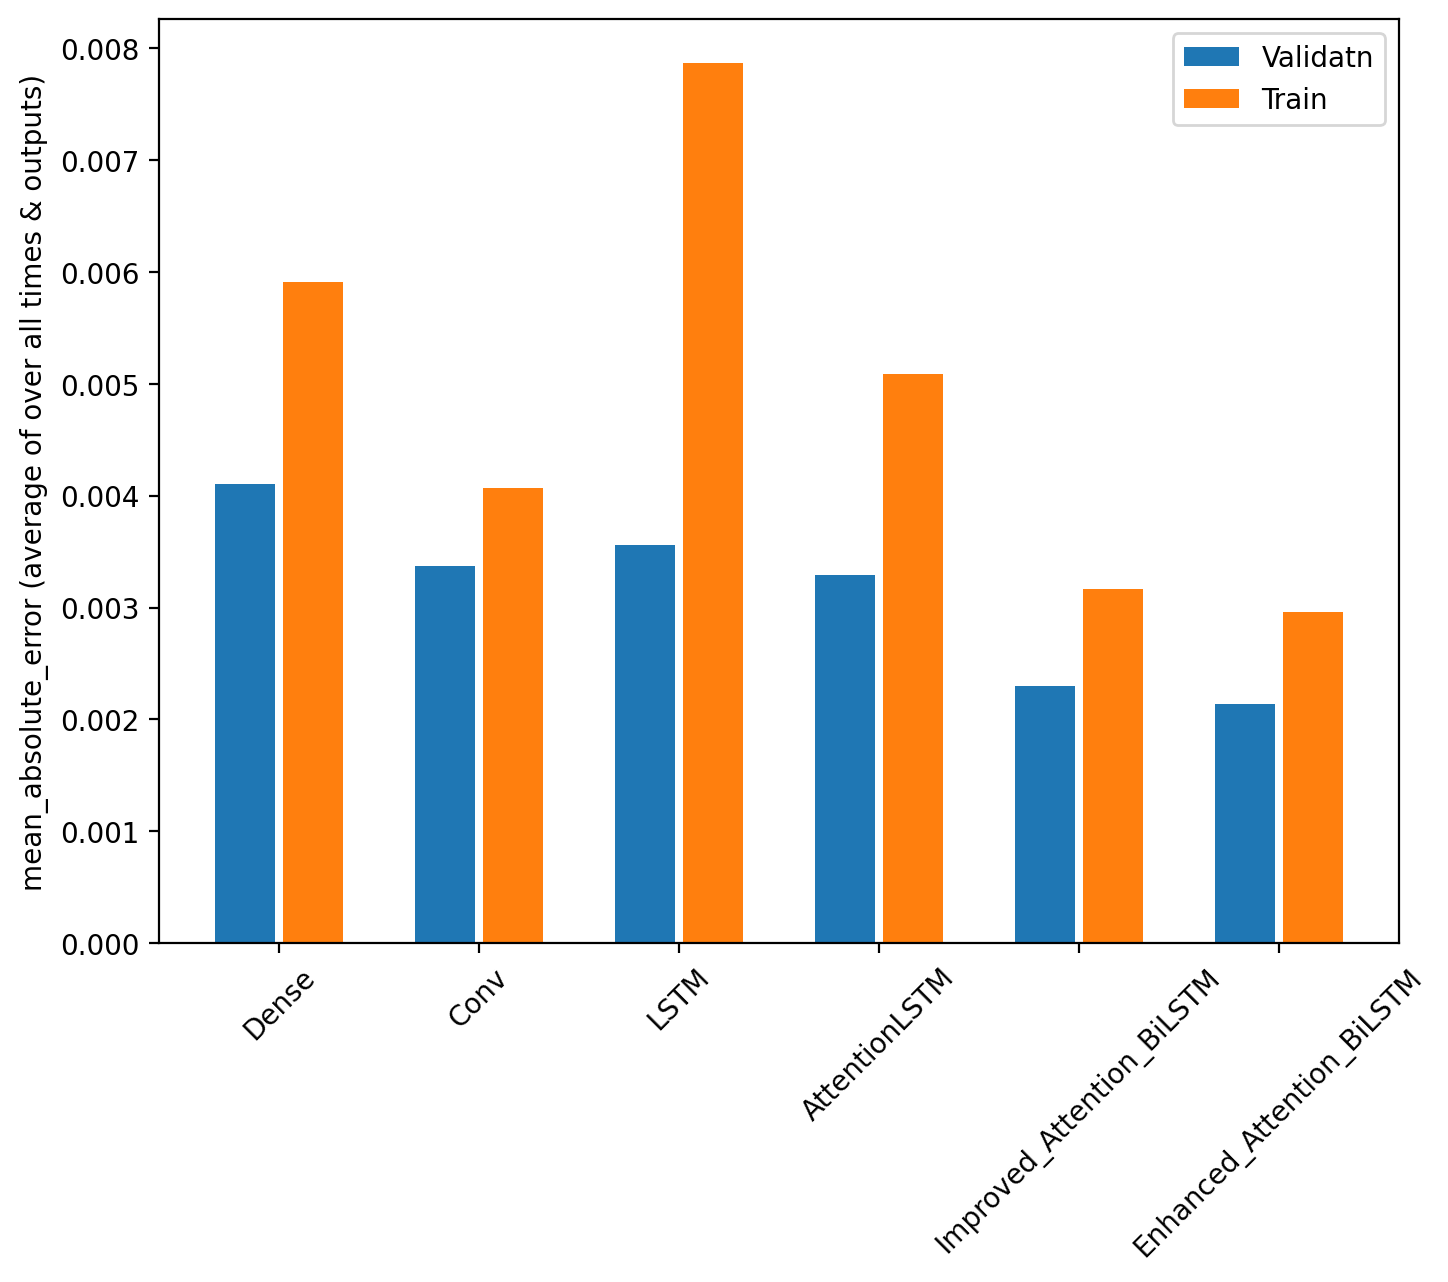

In [98]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = 0 # my_lstm_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validatn')
plt.bar(x + 0.17, test_mae, width, label='Train')
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
plt.ylabel(f'{metric_name} (average of over all times & outputs)')
_ = plt.legend()

In [96]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

print()
for name, value in multi_performance.items():
  z = float(my_scaler_tv.inverse_transform(np.array([[value[1]]])))
  print(f'{name:8s}: {z:0.4f}')

Dense   : 0.0472
Conv    : 0.0394
LSTM    : 0.0648
AttentionLSTM: 0.0458
Improved_Attention_BiLSTM: 0.0339
Enhanced_Attention_BiLSTM: 0.0332

Dense   : 343.9439
Conv    : 287.0242
LSTM    : 471.4105
AttentionLSTM: 333.4808
Improved_Attention_BiLSTM: 246.5567
Enhanced_Attention_BiLSTM: 241.3576
